# GLORYS

In [1]:
import copernicusmarine
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import geopandas
import cmocean.cm as cmo
import glob
from scipy.stats import linregress
import cartopy
import gsw
from datetime import timedelta as delta
from dask.diagnostics import ProgressBar
from scipy.signal import butter,filtfilt
from scipy.interpolate import interp1d
import scipy.stats
import geopy.distance
import cartopy.crs as ccrs
from oceans.ocfis import uv2spdir
from pyproj import Geod
import cmocean
import matplotlib
from matplotlib.lines import Line2D
from eofs.xarray import Eof
from scipy.signal import welch


## Load Caribbean shapefile for more precise clipping
fname ='/Users/joegradone/SynologyDrive/Drive/Rutgers/Research/data/carib/new.shp'
carib = geopandas.read_file(fname)

## Load Atlantic shapefile for more precise clipping
fname ='/Users/joegradone/SynologyDrive/Drive/Rutgers/Research/data/atl/iho.shp'
atl = geopandas.read_file(fname)




def water_mass_decomposition(old_salt,old_temp,old_den,new_salt,new_temp,new_den,new_depth):
    ## Calculate dz
    dz = np.diff(new_depth)[0]

    ## Change in isopycnal depth
    drho = np.empty(len(new_depth))    
    for x in np.arange(0,len(new_depth)):
        if np.sum(np.isnan(np.abs(np.abs(old_den[x]-new_den)))) == len(new_den):
            break
        else:
            drho[x] = (new_depth[np.nanargmin(np.abs(old_den[x]-new_den))]-new_depth[x])

    ## Local vertical change in temp/salt 
    dtheta_dz = np.gradient(new_temp,dz)
    dsalt_dz = np.gradient(new_salt,dz)

    ## Heave component of the change in temp/salt
    heave_temp = (dtheta_dz*drho)
    heave_salt = (dsalt_dz*drho)

    ## Change in temp/salt on isopycnal
    spice_salt = np.empty(len(new_depth))
    spice_temp = np.empty(len(new_depth))
    isopyc_depth_delta = np.empty(len(new_depth))
    
    for x in np.arange(0,len(new_depth)):
        if np.sum(np.isnan(np.abs(old_den[x]-new_den))) == len(new_den):
            break
        else:
            ## First find the index the isopycnal changed to
            ind = np.nanargmin(np.abs(old_den[x]-new_den))
            ## Then diff the temps/salts on that isopycnal
            spice_temp[x] = new_temp[ind]-old_temp[x]
            spice_salt[x] = new_salt[ind]-old_salt[x]
            ## How much that isopycnal has moved vertically
            isopyc_depth_delta[x] = new_depth[ind]-new_depth[x]

    ## Total temp/salt differences
    temp_diff = new_temp-old_temp
    salt_diff = new_salt-old_salt

    ## Residuals
    temp_resid = temp_diff-(spice_temp-heave_temp)
    salt_resid = salt_diff-(spice_salt-heave_salt)

    ## Combine into a df
    d = {'depth': new_depth, 'temp_diff': temp_diff, 'heave_temp': heave_temp,
    'spice_temp': spice_temp, 'temp_resid': temp_resid, 'salt_diff': salt_diff,
    'heave_salt': heave_salt, 'spice_salt': spice_salt, 'salt_resid': salt_resid,'isopyc_depth_delta':isopyc_depth_delta}

    df = pd.DataFrame(data=d)


    return df

    

/Users/joegradone/anaconda3/envs/rutgers-phd/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# copernicusmarine.login()

In [3]:
# with ProgressBar():
#     years = np.arange(1998,2024,1)
#     for year in years:
#         if year < 2021:
#             ds_id = "cmems_mod_glo_phy_my_0.083deg_P1M-m"
#         elif year > 2021:
#             ds_id = "cmems_mod_glo_phy_myint_0.083deg_P1M-m"
        
#         start_datetime = ''.join([str(year),"-01-01T00:00:00"])
#         end_datetime   = ''.join([str(year),"-12-31T00:00:00"])
        
#         ds = copernicusmarine.open_dataset(
#             dataset_id=ds_id,
#             dataset_version="202311",
#             variables=["so","thetao","uo","vo"],
#             minimum_longitude=-98,
#             maximum_longitude=-14,
#             minimum_latitude=8,
#             maximum_latitude=30,
#             start_datetime=start_datetime,
#             end_datetime=end_datetime
#         )
        
#         save_fname = ''.join(['/Users/joegradone/SynologyDrive/Drive/Rutgers/Research/data/GLORYS/Mean_GLORYS_Carib_',str(year),'.nc'])
#         ds.to_netcdf(save_fname)
#         print(''.join(['Done: ',str(year)]))


## 2021 is stupid and special

In [4]:
# ds1 = copernicusmarine.open_dataset(
#     dataset_id="cmems_mod_glo_phy_my_0.083deg_P1M-m",
#     dataset_version="202311",
#     variables=["so","thetao","uo","vo"],
#     minimum_longitude=-98,
#     maximum_longitude=-14,
#     minimum_latitude=8,
#     maximum_latitude=30,
#     start_datetime="2021-01-01T00:00:00",
#     end_datetime="2021-07-01T00:00:00",
# )

# ds2 = copernicusmarine.open_dataset(
#     dataset_id="cmems_mod_glo_phy_myint_0.083deg_P1M-m",
#     dataset_version="202311",
#     variables=["so","thetao","uo","vo"],
#     minimum_longitude=-98,
#     maximum_longitude=-14,
#     minimum_latitude=8,
#     maximum_latitude=30,
#     start_datetime="2021-07-01T00:00:00",
#     end_datetime="2022-01-01T00:00:00",
# )

# # ## Combine
# ds = xr.merge([ds1,ds2])

# save_fname = ''.join(['/Users/joegradone/SynologyDrive/Drive/Rutgers/Research/data/GLORYS/Mean_GLORYS_Carib_',str(2021),'.nc'])
# ds.to_netcdf(save_fname)


## Load all

In [5]:
fnames = glob.glob('/Users/joegradone/SynologyDrive/Drive/Rutgers/Research/data/GLORYS/*.nc')
ds = xr.open_mfdataset(fnames,data_vars='minimal',coords='minimal',compat='override',chunks='auto')

## Convert to TEOS-10
pressure = gsw.p_from_z(-ds.depth,ds.latitude)
ds['absolute_salinity'] = gsw.SA_from_SP(ds.so, pressure, ds.longitude, ds.latitude)    
ds['conservative_temperature'] = gsw.CT_from_pt(ds.so, ds.thetao)
ds['potential_density'] = gsw.sigma0(ds.absolute_salinity, ds.conservative_temperature)+1000
## Update attributes
ds.absolute_salinity.attrs['long_name'] = 'Absolute Salinity'
ds.absolute_salinity.attrs['unit_long'] = 'Absolute Salinity'
ds.absolute_salinity.attrs['units'] = 'g kg$^{-1}$'
ds.conservative_temperature.attrs['long_name'] = 'Conservative Temperature'
ds.conservative_temperature.attrs['unit_long'] = 'Conservative Temperature'
ds.conservative_temperature.attrs['units'] = '°C'
ds.potential_density.attrs['long_name'] = 'Potential Density'
ds.potential_density.attrs['unit_long'] = 'Potential Density'
ds.potential_density.attrs['units'] = 'kg m$^{-3}$'


ds

<xarray.Dataset>
Dimensions:                   (depth: 50, latitude: 265, longitude: 1009,
                               time: 373)
Coordinates:
  * depth                     (depth) float32 0.494 1.541 ... 5.728e+03
  * latitude                  (latitude) float32 8.0 8.083 8.167 ... 29.92 30.0
  * longitude                 (longitude) float32 -98.0 -97.92 ... -14.08 -14.0
  * time                      (time) datetime64[ns] 1993-01-01 ... 2023-12-01
Data variables:
    so                        (time, depth, latitude, longitude) float32 dask.array<chunksize=(8, 33, 181, 699), meta=np.ndarray>
    thetao                    (time, depth, latitude, longitude) float32 dask.array<chunksize=(8, 33, 181, 699), meta=np.ndarray>
    uo                        (time, depth, latitude, longitude) float32 dask.array<chunksize=(8, 33, 181, 699), meta=np.ndarray>
    vo                        (time, depth, latitude, longitude) float32 dask.array<chunksize=(8, 33, 181, 699), meta=np.ndarray>
    absolute_salinity         (time, depth, latitude, longitude) float64 dask.array<chunksize=(8, 33, 181, 699), meta=np.ndarray>
    conservative_temperature  (time, depth, latitude, longitude) float64 dask.array<chunksize=(8, 33, 181, 699), meta=np.ndarray>
    potential_density         (time, depth, latitude, longitude) float64 dask.array<chunksize=(8, 33, 181, 699), meta=np.ndarray>
Attributes: (12/14)
    Conventions:                   CF-1.6
    area:                          GLOBAL
    contact:                       servicedesk.cmems@mercator-ocean.eu
    credit:                        E.U. Copernicus Marine Service Information...
    dataset:                       global-reanalysis-001-030-monthly
    institution:                   Mercator Ocean
    ...                            ...
    product:                       GLOBAL_REANALYSIS_001_030
    product_user_manual:           http://marine.copernicus.eu/documents/PUM/...
    quality_information_document:  http://marine.copernicus.eu/documents/QUID...
    references:                    http://marine.copernicus.eu
    source:                        MERCATOR GLORYS12V1
    title:                         Monthly mean fields for product GLOBAL_REA...

## Clip to shapefile

In [6]:
## Load Atlantic shapefile for more precise clipping
fname ='/Users/joegradone/SynologyDrive/Drive/Rutgers/Research/data/atl/iho.shp'
atl = geopandas.read_file(fname)
## Load Caribbean shapefile for more precise clipping
fname ='/Users/joegradone/SynologyDrive/Drive/Rutgers/Research/data/carib/new.shp'
carib = geopandas.read_file(fname)
## Load western Caribbean shapefile for more precise clipping
fname ='/Users/joegradone/SynologyDrive/Drive/Rutgers/Research/data/northwest_carib/northwest.shp'
nwcarib = geopandas.read_file(fname)
## Load southeastern Caribbean shapefile for more precise clipping
fname ='/Users/joegradone/SynologyDrive/Drive/Rutgers/Research/data/eastern_carib/eastern.shp'
ecarib = geopandas.read_file(fname)
## Load central Caribbean shapefile for more precise clipping
fname ='/Users/joegradone/SynologyDrive/Drive/Rutgers/Research/data/central_carib/central.shp'
central_carib = geopandas.read_file(fname)


## Need to do this to play nice with geopandas/rio
ds = ds.rename({'longitude': 'x','latitude': 'y'})
## Clip to Atlantic shapefile
ds = ds.rio.write_crs('WGS84', inplace=True)
ds = ds.rio.clip(atl.geometry.values, atl.crs)

## Clip to Carib
carib_ds = ds.rio.clip(carib.geometry.values, carib.crs)
west_carib_ds = ds.rio.clip(nwcarib.geometry.values, nwcarib.crs)
east_carib_ds = ds.rio.clip(ecarib.geometry.values, ecarib.crs)
central_carib_ds = ds.rio.clip(central_carib.geometry.values, central_carib.crs)


## Do this for plotting significant points
lonmesh, latmesh = np.meshgrid(ds.x,ds.y)
lonmesh_carib, latmesh_carib = np.meshgrid(carib_ds.x,carib_ds.y)

## Replace inf values with nan because blowingup the spatial means
east_carib_ds = east_carib_ds.map(lambda x: x.where(np.isfinite(x), np.nan))
central_carib_ds = central_carib_ds.map(lambda x: x.where(np.isfinite(x), np.nan))
west_carib_ds = west_carib_ds.map(lambda x: x.where(np.isfinite(x), np.nan))


## Rename

In [7]:
ds = ds.rename({'uo': 'uvel','vo': 'vvel'})
east_carib_ds = east_carib_ds.rename({'uo': 'uvel','vo': 'vvel'})
central_carib_ds = central_carib_ds.rename({'uo': 'uvel','vo': 'vvel'})
west_carib_ds = west_carib_ds.rename({'uo': 'uvel','vo': 'vvel'})
carib_ds = carib_ds.rename({'uo': 'uvel','vo': 'vvel'})


In [8]:
## Colors for consistent plotting

ec_col = '#2ca1db' # eastern carib
cc_col = '#f44323' # central carib
wc_col = '#112047' # western carib


In [13]:
carib_ds.where(carib_ds.x==-63,drop=True).x[0]


<xarray.DataArray 'x' ()>
array(-63., dtype=float32)
Coordinates:
    x            float32 -63.0
    spatial_ref  int64 0
Attributes:
    axis:           X
    long_name:      longitude
    standard_name:  longitude
    step:           0.0833282470703125
    unit_long:      Degrees East
    units:          degrees_east
    valid_max:      -14.0
    valid_min:      -98.0

In [26]:
3/12+0.5

0.75

/Users/joegradone/anaconda3/envs/rutgers-phd/lib/python3.11/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/Users/joegradone/anaconda3/envs/rutgers-phd/lib/python3.11/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


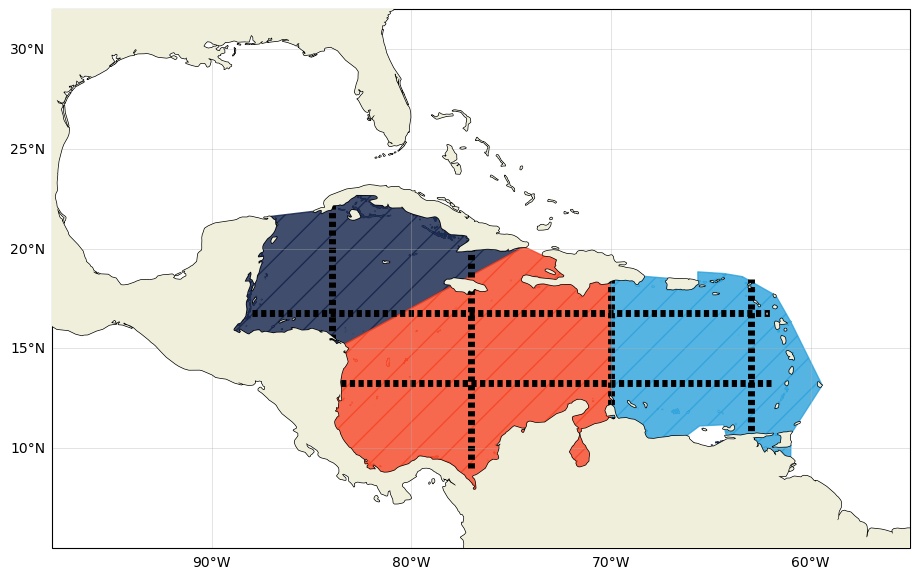

In [32]:
fig, ax = plt.subplots(figsize=(14,7),subplot_kw=dict(projection=cartopy.crs.PlateCarree()))

ax.coastlines(linewidth=1.0,zorder=10)
ax.add_feature(cartopy.feature.LAND,zorder=10)
glb = ax.gridlines(draw_labels=True, alpha=0.5, linewidth=.5 )
glb.xlabels_top = glb.ylabels_right = False

ax.add_geometries(nwcarib.geometry, crs=ccrs.PlateCarree(),facecolor=wc_col, edgecolor=wc_col,hatch='/',alpha=0.8)
ax.add_geometries(central_carib.geometry, crs=ccrs.PlateCarree(),facecolor=cc_col, edgecolor=cc_col,hatch='/',alpha=0.8)
ax.add_geometries(ecarib.geometry, crs=ccrs.PlateCarree(),facecolor=ec_col, edgecolor=ec_col,hatch='/',alpha=0.8)

ax.set_ylim(5,32)
ax.set_xlim(-98,-55)

ax.plot([-63,-63], [10,18.5],color='black',linestyle='--',dashes=(0.75,0.5),linewidth=5,transform=cartopy.crs.PlateCarree())
ax.plot([-70,-70], [10,18.5],color='black',linestyle='--',dashes=(0.75,0.5),linewidth=5,transform=cartopy.crs.PlateCarree())
ax.plot([-77,-77], [9,20],color='black',linestyle='--',dashes=(0.75,0.5),linewidth=5,transform=cartopy.crs.PlateCarree())
ax.plot([-84,-84], [15,22.5],color='black',linestyle='--',dashes=(0.75,0.5),linewidth=5,transform=cartopy.crs.PlateCarree())

ax.plot([-88,-62], [16.75,16.75],color='black',linestyle='--',dashes=(0.75,0.5),linewidth=5,transform=cartopy.crs.PlateCarree())
ax.plot([-84,-62], [13.25,13.25],color='black',linestyle='--',dashes=(0.75,0.5),linewidth=5,transform=cartopy.crs.PlateCarree())

plt.savefig('/Users/joegradone/SynologyDrive/Drive/Rutgers/Research/figures/Python/Model/GLORYS/Map_w_regions_n_slices.png', bbox_inches='tight',dpi=300,facecolor='white')


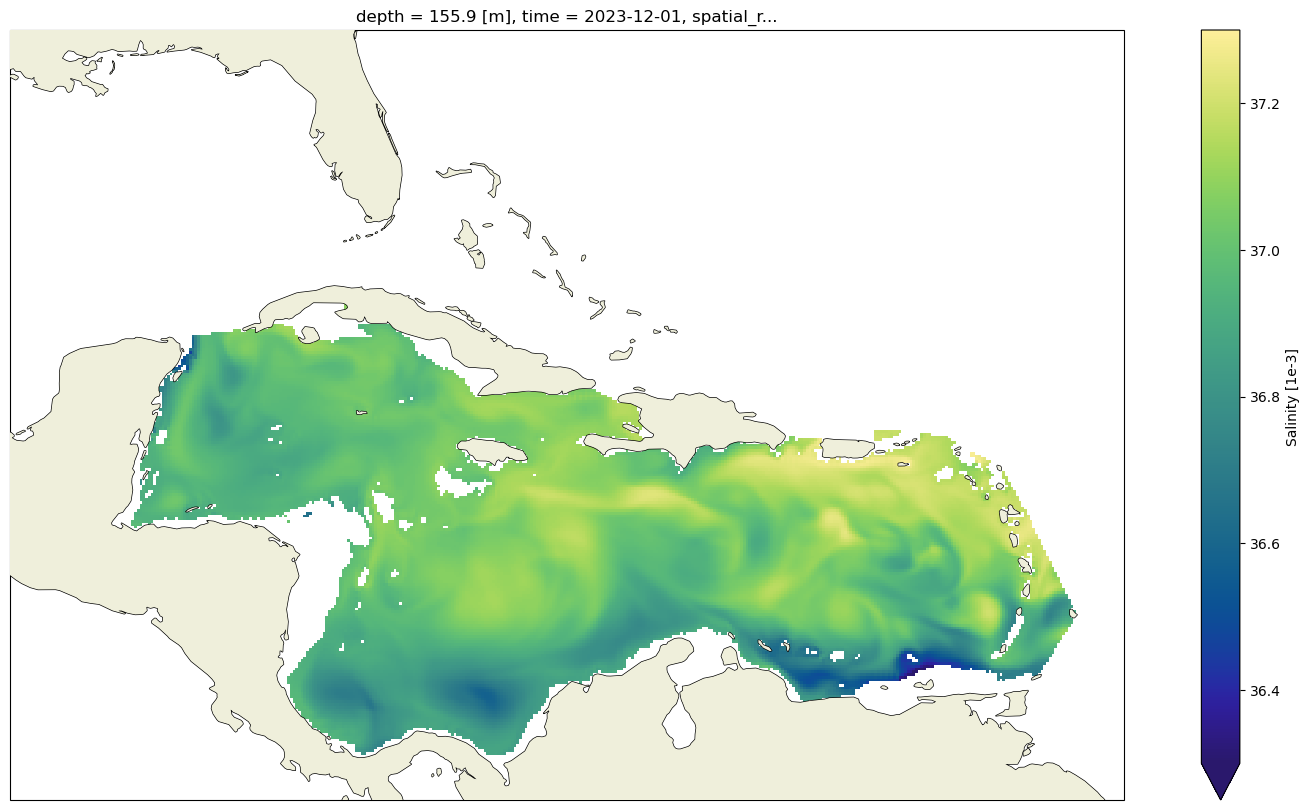

In [10]:
fig, ax = plt.subplots(figsize=(20, 10), subplot_kw=dict(projection=cartopy.crs.PlateCarree()))
carib_ds.so.isel(time=-1,depth=24).plot(vmin=36.3,vmax=37.3,cmap=cmo.haline)

########################################################################################################
ax.set_extent([-92, -58, 7.5, 30])
ax.coastlines(linewidth=1.0,zorder=10)
ax.add_feature(cartopy.feature.LAND,zorder=10)

## Load EN4 data for comparison

In [33]:
EN4_fnames = glob.glob('/Users/joegradone/SynologyDrive/Drive/Rutgers/Research/data/EN4/Monthly_Means/*.nc')
en4 = xr.open_mfdataset(EN4_fnames,combine='nested', concat_dim='time')
## This is to dask plays nicely
en4 = en4.load()
en4 = en4.sortby('time')
## Add density
en4['potential_density'] = gsw.sigma0(en4.absolute_salinity, en4.conservative_temperature)+1000
## Only argo era
en4 = en4.where(((en4.time.dt.year>=1993)&(en4.time.dt.year<=2023)),drop=True)
en4

<xarray.Dataset>
Dimensions:                   (time: 336, depth: 74, latitude: 28, longitude: 58)
Coordinates:
  * longitude                 (longitude) float64 -88.25 -87.75 ... -59.75
  * latitude                  (latitude) float64 8.75 9.25 9.75 ... 21.75 22.25
  * depth                     (depth) int64 0 5 10 15 20 ... 6050 6300 6550 6800
  * time                      (time) datetime64[ns] 1993-02-01 ... 2023-11-01
Data variables:
    spatial_ref               (time) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    conservative_temperature  (depth, latitude, longitude, time) float64 nan ...
    absolute_salinity         (depth, latitude, longitude, time) float64 nan ...
    num_profs                 (latitude, longitude, time) float64 nan ... nan
    potential_density         (depth, latitude, longitude, time) float64 nan ...

## Clip

In [34]:
en4 = en4.rename({'longitude': 'x','latitude': 'y'})
en4 = en4.rio.write_crs('WGS84', inplace=True)
en4_carib = en4.rio.clip(carib.geometry.values, carib.crs)
west_carib_en4 = en4.rio.clip(nwcarib.geometry.values, nwcarib.crs)
east_carib_en4 = en4.rio.clip(ecarib.geometry.values, ecarib.crs)
central_carib_en4 = en4.rio.clip(central_carib.geometry.values, central_carib.crs)


## Compare

In [35]:
#### glorys
# Pull put means: glorys
east_glorys_mean_profile = east_carib_ds.mean(dim='time',skipna=True).mean(dim=['x','y'],skipna=True).compute()
central_glorys_mean_profile = central_carib_ds.mean(dim='time',skipna=True).mean(dim=['x','y'],skipna=True).compute()
west_glorys_mean_profile = west_carib_ds.mean(dim='time',skipna=True).mean(dim=['x','y'],skipna=True).compute()
# Pull out std: glorys
east_glorys_mean_profile_std = east_carib_ds.std(dim='time',skipna=True).mean(dim=['x','y'],skipna=True).compute()
central_glorys_mean_profile_std = central_carib_ds.std(dim='time',skipna=True).mean(dim=['x','y'],skipna=True).compute()
west_glorys_mean_profile_std = west_carib_ds.std(dim='time',skipna=True).mean(dim=['x','y'],skipna=True).compute()

#### EN4
# Pull put means: en4
east_en4_mean_profile = east_carib_en4.mean(dim=['y','x','time'],skipna=True).compute()
central_en4_mean_profile = central_carib_en4.mean(dim=['y','x','time'],skipna=True).compute()
west_en4_mean_profile = west_carib_en4.mean(dim=['y','x','time'],skipna=True).compute()
# Pull out std: en4
east_en4_mean_profile_std = east_carib_en4.mean(dim=['x','y'],skipna=True).std(dim='time',skipna=True).compute()
central_en4_mean_profile_std = central_carib_en4.mean(dim=['x','y'],skipna=True).std(dim='time',skipna=True).compute()
west_en4_mean_profile_std = west_carib_en4.mean(dim=['x','y'],skipna=True).std(dim='time',skipna=True).compute()


/Users/joegradone/anaconda3/envs/rutgers-phd/lib/python3.11/site-packages/dask/array/numpy_compat.py:51: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/Users/joegradone/anaconda3/envs/rutgers-phd/lib/python3.11/site-packages/dask/array/numpy_compat.py:51: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/Users/joegradone/anaconda3/envs/rutgers-phd/lib/python3.11/site-packages/dask/array/numpy_compat.py:51: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)


In [36]:
# font_size =12
# lwd = 4

# fig,ax = plt.subplots(3,2,figsize=(12,18))

# ax[0,0].plot(east_glorys_mean_profile.conservative_temperature,-east_glorys_mean_profile.depth,color=ec_col,linewidth=lwd)
# ax[0,0].plot(central_glorys_mean_profile.conservative_temperature,-central_glorys_mean_profile.depth,color=cc_col,linewidth=lwd)
# ax[0,0].plot(west_glorys_mean_profile.conservative_temperature,-west_glorys_mean_profile.depth,color=wc_col,linewidth=lwd)
# ax[0,0].set_ylim(-750,0)
# ax[0,0].set_xlim(4,30)
# ax[0,0].grid()
# ax[0,0].set_ylabel('Depth [m]',fontsize = font_size)
# ax[0,0].set_title('GLORYS Model', fontsize = font_size)
# ax[0,0].set_xlabel('Conservative Temperature [°C]',fontsize = font_size)



# ax[0,1].plot(east_en4_mean_profile.conservative_temperature,-east_en4_mean_profile.depth,color=ec_col,linewidth=lwd)
# ax[0,1].plot(central_en4_mean_profile.conservative_temperature,-central_en4_mean_profile.depth,color=cc_col,linewidth=lwd)
# ax[0,1].plot(west_en4_mean_profile.conservative_temperature,-west_en4_mean_profile.depth,color=wc_col,linewidth=lwd)
# ax[0,1].set_ylim(-750,0)
# ax[0,1].set_xlim(4,30)
# ax[0,1].grid()
# ax[0,1].set_ylabel('Depth [m]',fontsize = font_size)
# ax[0,1].set_title('EN4 Observations', fontsize = font_size)
# ax[0,1].set_xlabel('Conservative Temperature [°C]',fontsize = font_size)

# ax[1,0].plot(east_glorys_mean_profile.absolute_salinity,-east_glorys_mean_profile.depth,color=ec_col,linewidth=lwd)
# ax[1,0].plot(central_glorys_mean_profile.absolute_salinity,-central_glorys_mean_profile.depth,color=cc_col,linewidth=lwd)
# ax[1,0].plot(west_glorys_mean_profile.absolute_salinity,-west_glorys_mean_profile.depth,color=wc_col,linewidth=lwd)
# ax[1,0].set_ylim(-750,0)
# ax[1,0].set_xlim(34.8,37.3)
# ax[1,0].grid()
# ax[1,0].set_xlabel('Absolute Salinity [g kg$^{-1}$]',fontsize = font_size)

# ax[1,1].plot(east_en4_mean_profile.absolute_salinity,-east_en4_mean_profile.depth,color=ec_col,linewidth=lwd,label='East Caribbean')
# ax[1,1].plot(central_en4_mean_profile.absolute_salinity,-central_en4_mean_profile.depth,color=cc_col,linewidth=lwd,label='Central Caribbean')
# ax[1,1].plot(west_en4_mean_profile.absolute_salinity,-west_en4_mean_profile.depth,color=wc_col,linewidth=lwd,label='West Caribbean')
# ax[1,1].set_ylim(-750,0)
# ax[1,1].set_xlim(34.8,37.3)
# ax[1,1].grid()
# ax[1,1].set_xlabel('Absolute Salinity [g kg$^{-1}$]',fontsize = font_size)





# ax[2,0].plot(east_glorys_mean_profile.potential_density,-east_glorys_mean_profile.depth,color=ec_col,linewidth=lwd)
# ax[2,0].plot(central_glorys_mean_profile.potential_density,-central_glorys_mean_profile.depth,color=cc_col,linewidth=lwd)
# ax[2,0].plot(west_glorys_mean_profile.potential_density,-west_glorys_mean_profile.depth,color=wc_col,linewidth=lwd)
# ax[2,0].set_ylim(-750,0)
# #ax[2,0].set_xlim(34.8,37.3)
# ax[2,0].grid()
# ax[2,0].set_xlabel('Potential Density [kg m$^{-3}$]',fontsize = font_size)

# ax[2,1].plot(east_en4_mean_profile.potential_density,-east_en4_mean_profile.depth,color=ec_col,linewidth=lwd,label='East Caribbean')
# ax[2,1].plot(central_en4_mean_profile.potential_density,-central_en4_mean_profile.depth,color=cc_col,linewidth=lwd,label='Central Caribbean')
# ax[2,1].plot(west_en4_mean_profile.potential_density,-west_en4_mean_profile.depth,color=wc_col,linewidth=lwd,label='West Caribbean')
# ax[2,1].set_ylim(-750,0)
# #ax[2,1].set_xlim(34.8,37.3)
# ax[2,1].grid()
# ax[2,1].legend()
# ax[2,1].set_xlabel('Potential Density [kg m$^{-3}$]',fontsize = font_size)






# plt.savefig('/Users/joegradone/SynologyDrive/Drive/Rutgers/Research/figures/Python/Model/GLORYS/GLORYS_EN4_Temp_Sal_Den_Profile_Comps_Regions.png', bbox_inches='tight',dpi=300,facecolor='white')


In [37]:
# font_size=12
# lwd=3

# fig,ax = plt.subplots(2,3,figsize=(17,15))

# ####################### Temperature
# ## Plot west
# ax[0,0].plot(west_en4_mean_profile.conservative_temperature,-west_en4_mean_profile.depth,color='tab:blue',linewidth=lwd)
# ax[0,0].fill_betweenx(-west_en4_mean_profile.depth,west_en4_mean_profile.conservative_temperature+west_en4_mean_profile_std.conservative_temperature,west_en4_mean_profile.conservative_temperature-west_en4_mean_profile_std.conservative_temperature,alpha=0.2,color='tab:blue')
# ax[0,0].plot(west_glorys_mean_profile.conservative_temperature,-west_glorys_mean_profile.depth,color='tab:orange',linewidth=lwd)
# ax[0,0].fill_betweenx(-west_glorys_mean_profile.depth,west_glorys_mean_profile.conservative_temperature+west_glorys_mean_profile_std.conservative_temperature,west_glorys_mean_profile.conservative_temperature-west_glorys_mean_profile_std.absolute_salinity,alpha=0.2,color='tab:orange')
# ax[0,0].set_xlim(4,30)
# ax[0,0].set_ylim(-750,0)
# ax[0,0].grid()
# ax[0,0].set_ylabel('Depth [m]',fontsize = font_size)
# ax[0,0].set_xlabel('Conservative Temperature [°C]',fontsize = font_size)
# ax[0,0].set_title('Western Caribbean', fontsize=font_size+3)

# ## Plot central
# ax[0,1].plot(central_en4_mean_profile.conservative_temperature,-central_en4_mean_profile.depth,color='tab:blue',linewidth=lwd)
# ax[0,1].fill_betweenx(-central_en4_mean_profile.depth,central_en4_mean_profile.conservative_temperature+central_en4_mean_profile_std.conservative_temperature,central_en4_mean_profile.conservative_temperature-central_en4_mean_profile_std.conservative_temperature,alpha=0.2,color='tab:blue')
# ax[0,1].plot(central_glorys_mean_profile.conservative_temperature,-central_glorys_mean_profile.depth,color='tab:orange',linewidth=lwd)
# ax[0,1].fill_betweenx(-central_glorys_mean_profile.depth,central_glorys_mean_profile.conservative_temperature+central_glorys_mean_profile_std.conservative_temperature,central_glorys_mean_profile.conservative_temperature-central_glorys_mean_profile_std.conservative_temperature,alpha=0.2,color='tab:orange')
# ax[0,1].set_xlim(4,30)
# ax[0,1].set_ylim(-750,0)
# ax[0,1].grid()
# ax[0,1].set_xlabel('Conservative Temperature [°C]',fontsize = font_size)
# ax[0,1].set_title('Central Caribbean', fontsize=font_size+3)

# ## Plot east
# ax[0,2].plot(east_en4_mean_profile.conservative_temperature,-west_en4_mean_profile.depth,color='tab:blue',linewidth=lwd)
# ax[0,2].fill_betweenx(-east_en4_mean_profile.depth,east_en4_mean_profile.conservative_temperature+east_en4_mean_profile_std.conservative_temperature,east_en4_mean_profile.conservative_temperature-east_en4_mean_profile_std.conservative_temperature,alpha=0.2,color='tab:blue')
# ax[0,2].plot(east_glorys_mean_profile.conservative_temperature,-west_glorys_mean_profile.depth,color='tab:orange',linewidth=lwd)
# ax[0,2].fill_betweenx(-east_glorys_mean_profile.depth,east_glorys_mean_profile.conservative_temperature+east_glorys_mean_profile_std.conservative_temperature,east_glorys_mean_profile.conservative_temperature-east_glorys_mean_profile_std.conservative_temperature,alpha=0.2,color='tab:orange')
# ax[0,2].set_xlim(4,30)
# ax[0,2].set_ylim(-750,0)
# ax[0,2].grid()
# ax[0,2].set_xlabel('Conservative Temperature [°C]',fontsize = font_size)
# ax[0,2].set_title('Eastern Caribbean', fontsize=font_size+3)


# ####################### Salinity
# ## Plot west
# ax[1,0].plot(west_en4_mean_profile.absolute_salinity,-west_en4_mean_profile.depth,color='tab:blue',linewidth=lwd)
# ax[1,0].fill_betweenx(-west_en4_mean_profile.depth,west_en4_mean_profile.absolute_salinity+west_en4_mean_profile_std.absolute_salinity,west_en4_mean_profile.absolute_salinity-west_en4_mean_profile_std.absolute_salinity,alpha=0.2,color='tab:blue')
# ax[1,0].plot(west_glorys_mean_profile.absolute_salinity,-west_glorys_mean_profile.depth,color='tab:orange',linewidth=lwd)
# ax[1,0].fill_betweenx(-west_glorys_mean_profile.depth,west_glorys_mean_profile.absolute_salinity+west_glorys_mean_profile_std.absolute_salinity,west_glorys_mean_profile.absolute_salinity-west_glorys_mean_profile_std.absolute_salinity,alpha=0.2,color='tab:orange')
# ax[1,0].set_xlim(34.8,37.3)
# ax[1,0].set_ylim(-750,-0)
# ax[1,0].grid()
# ax[1,0].set_xlabel('Absolute Salinity [g kg$^{-1}$]',fontsize = font_size)
# ax[1,0].set_ylabel('Depth [m]',fontsize = font_size)

# ## Plot central
# ax[1,1].plot(central_en4_mean_profile.absolute_salinity,-central_en4_mean_profile.depth,color='tab:blue',linewidth=lwd)
# ax[1,1].fill_betweenx(-central_en4_mean_profile.depth,central_en4_mean_profile.absolute_salinity+central_en4_mean_profile_std.absolute_salinity,central_en4_mean_profile.absolute_salinity-central_en4_mean_profile_std.absolute_salinity,alpha=0.2,color='tab:blue')
# ax[1,1].plot(central_glorys_mean_profile.absolute_salinity,-central_glorys_mean_profile.depth,color='tab:orange',linewidth=lwd)
# ax[1,1].fill_betweenx(-central_glorys_mean_profile.depth,central_glorys_mean_profile.absolute_salinity+central_glorys_mean_profile_std.absolute_salinity,central_glorys_mean_profile.absolute_salinity-central_glorys_mean_profile_std.absolute_salinity,alpha=0.2,color='tab:orange')
# ax[1,1].set_xlim(34.8,37.3)
# ax[1,1].set_ylim(-750,0)
# ax[1,1].grid()
# ax[1,1].set_xlabel('Absolute Salinity [g kg$^{-1}$]',fontsize = font_size)

# ## Plot east
# ax[1,2].plot(east_en4_mean_profile.absolute_salinity,-east_en4_mean_profile.depth,color='tab:blue',label='EN4',linewidth=lwd)
# ax[1,2].fill_betweenx(-east_en4_mean_profile.depth,east_en4_mean_profile.absolute_salinity+east_en4_mean_profile_std.absolute_salinity,east_en4_mean_profile.absolute_salinity-east_en4_mean_profile_std.absolute_salinity,alpha=0.2,color='tab:blue')
# ax[1,2].plot(east_glorys_mean_profile.absolute_salinity,-east_glorys_mean_profile.depth,color='tab:orange',label='GLORYS ',linewidth=lwd)
# ax[1,2].fill_betweenx(-east_glorys_mean_profile.depth,east_glorys_mean_profile.absolute_salinity+east_glorys_mean_profile_std.absolute_salinity,east_glorys_mean_profile.absolute_salinity-east_glorys_mean_profile_std.absolute_salinity,alpha=0.2,color='tab:orange')
# ax[1,2].set_xlim(34.8,37.3)
# ax[1,2].set_ylim(-750,0)
# ax[1,2].grid()
# ax[1,2].legend(loc='lower right',fontsize=font_size)
# ax[1,2].set_xlabel('Absolute Salinity [g kg$^{-1}$]',fontsize = font_size)


# ax[0,0].tick_params(axis='both', which='major', labelsize=font_size)
# ax[0,1].tick_params(axis='both', which='major', labelsize=font_size)
# ax[0,2].tick_params(axis='both', which='major', labelsize=font_size)
# ax[1,0].tick_params(axis='both', which='major', labelsize=font_size)
# ax[1,1].tick_params(axis='both', which='major', labelsize=font_size)
# ax[1,2].tick_params(axis='both', which='major', labelsize=font_size)

# fig.tight_layout()

# plt.savefig('/Users/joegradone/SynologyDrive/Drive/Rutgers/Research/figures/Python/Model/GLORYS/GLORYS_vs_EN4_Eastern_Central_Western_T_S_Profiles.png', bbox_inches='tight',dpi=300,facecolor='white')


In [38]:
# plt.figure(figsize=(8,8))
# plt.plot(west_en4_mean_profile.absolute_salinity,west_en4_mean_profile.conservative_temperature,color=wc_col,label='EN4 Western Caribbean',linewidth=4)
# plt.plot(west_glorys_mean_profile.absolute_salinity,west_glorys_mean_profile.conservative_temperature,'--',color=wc_col,label='GLORYS Western Caribbean',linewidth=2)


# plt.plot(central_en4_mean_profile.absolute_salinity,central_en4_mean_profile.conservative_temperature,color=cc_col,label='EN4 Central Caribbean',linewidth=4)
# plt.plot(central_glorys_mean_profile.absolute_salinity,central_glorys_mean_profile.conservative_temperature,'--',color=cc_col,label='GLORYS Central Caribbean',linewidth=2)


# plt.plot(east_en4_mean_profile.absolute_salinity,east_en4_mean_profile.conservative_temperature,color=ec_col,label='EN4 Eastern Caribbean',linewidth=4)
# plt.plot(east_glorys_mean_profile.absolute_salinity,east_glorys_mean_profile.conservative_temperature,'--',color=ec_col,label='GLORYS Eastern Caribbean',linewidth=2)



# ######## This plots the contours
# mint=1
# maxt=30
# mins=34
# maxs=37.5
# n =499
# tempL=np.linspace(mint-1,maxt+1,n)
# salL=np.linspace(mins-1,maxs+1,n)
# Tg, Sg = np.meshgrid(tempL,salL)

# z=np.linspace(-1000,0,n)
# p = gsw.p_from_z(z,lat=0)

# sigma_theta = gsw.sigma0(Sg, Tg)+1000

# cnt = np.linspace(sigma_theta.min(), sigma_theta.max(),n)
# ind = np.argwhere(sigma_theta > 1015.7)
# st_short = sigma_theta[ind]

# ## Thin bois
# cs = plt.contour(Sg, Tg, sigma_theta, colors='grey', alpha=0.3,linestyles='dashed', zorder=1 ,levels=np.arange(1021,1030,0.5))
# levels = cs.levels
# manual_locations = [(0, 0), (0, 0),(0, 0), (34.75, 28),(34.8, 27.6), (35.25,24), (35.5, 24), (35, 25),(34.75, 17), (35, 16),(35.25,14), (0,0), (35,12),(0,0),(36.35,13.5), (0,0), (35.5,8),(35.75,6),(36.25,6),(36.75,5)]
# plt.clabel(cs,levels, fontsize=12,inline=True,fmt='%.1f', manual=manual_locations)

# ## Thick bois
# cs = plt.contour(Sg, Tg, sigma_theta, colors='black', zorder=1 ,levels=[1024.5,1026.3,1026.8,1027.1,1027.6])
# levels = cs.levels
# manual_locations = [(36, 22), (35.5, 15), (37.2,18), (36.9,15), (36.65,12)]
# plt.clabel(cs,levels, fontsize=font_size,inline=True,fmt='%.1f', manual=manual_locations)

# plt.ylim(10,29)
# plt.xlim(35,37.5)
# plt.ylabel('Conservative Temperature [°C]',size=font_size)
# plt.xlabel('Absolute Salinity [g kg$^{-1}$]',size=font_size)
# plt.gca().tick_params(axis='both', which='major', labelsize=font_size)
# plt.legend()

(34.75, 37.25)

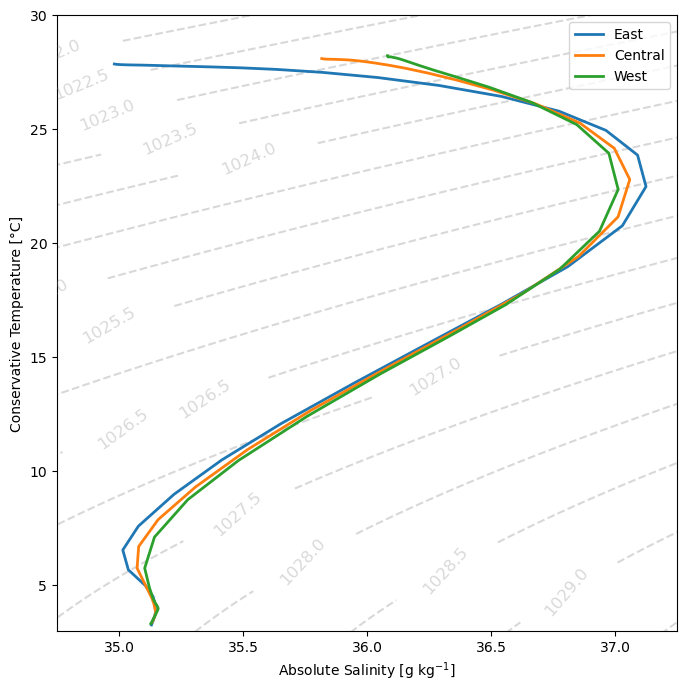

In [17]:
lwd=2

plt.figure(figsize=(8,8))

######## This plots the contours
mint=1
maxt=30
mins=34
maxs=37.5
n =499
tempL=np.linspace(mint-1,maxt+1,n)
salL=np.linspace(mins-1,maxs+1,n)
Tg, Sg = np.meshgrid(tempL,salL)

z=np.linspace(-1000,0,n)
p = gsw.p_from_z(z,lat=0)

sigma_theta = gsw.sigma0(Sg, Tg)+1000

cnt = np.linspace(sigma_theta.min(), sigma_theta.max(),n)
ind = np.argwhere(sigma_theta > 1015.7)
st_short = sigma_theta[ind]

## Thin bois
cs = plt.contour(Sg, Tg, sigma_theta, colors='grey', alpha=0.3,linestyles='dashed', zorder=1 ,levels=np.arange(1022,1030,0.5))
levels = cs.levels
manual_locations = [(34.75, 28),(34.8, 27.6), (35.25,24), (35.5, 24), (35, 25),(34.75, 17), (35, 16),(35.25,14), (0,0), (35,12),(0,0),(36.35,13.5), (0,0), (35.5,8),(35.75,6),(36.25,6),(36.75,5)]
plt.clabel(cs,levels, fontsize=12,inline=True,fmt='%.1f', manual=manual_locations)

# ## Thick bois
# cs = plt.contour(Sg, Tg, sigma_theta, colors='black', zorder=1 ,levels=[1024.5,1026.3,1026.8,1027.1,1027.6])
# levels = cs.levels
# manual_locations = [(36, 22), (35.5, 15), (37.2,18), (36.9,15), (36.65,12)]
# plt.clabel(cs,levels, fontsize=font_size,inline=True,fmt='%.1f', manual=manual_locations)


plt.plot(east_glorys_mean_profile.absolute_salinity,east_glorys_mean_profile.conservative_temperature,label='East',linewidth=lwd)
plt.plot(central_glorys_mean_profile.absolute_salinity,central_glorys_mean_profile.conservative_temperature,label='Central',linewidth=lwd)
plt.plot(west_glorys_mean_profile.absolute_salinity,west_glorys_mean_profile.conservative_temperature,label='West',linewidth=lwd)
plt.legend()
plt.xlabel('Absolute Salinity [g kg$^{-1}$]')
plt.ylabel('Conservative Temperature [°C]')
plt.ylim(3,30)
plt.xlim(34.75,37.25)


## Document variability in water mass structure

/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_50057/1014444453.py:12: UserWarning: The following kwargs were not used by contour: 'linewidth'
  cs = ax[0].contour(carib_ds.y,carib_ds.depth,carib_ds.where(carib_ds.x==x,drop=True).absolute_salinity.isel(x=0).mean(dim='time'),contour_levels,colors='black',linewidth=5)
/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_50057/1014444453.py:23: UserWarning: The following kwargs were not used by contour: 'linewidth'
  cs = ax[1].contour(carib_ds.y,carib_ds.depth,carib_ds.where(carib_ds.x==x,drop=True).absolute_salinity.isel(x=0).mean(dim='time'),contour_levels,colors='black',linewidth=5)
/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_50057/1014444453.py:34: UserWarning: The following kwargs were not used by contour: 'linewidth'
  cs = ax[2].contour(carib_ds.y,carib_ds.depth,carib_ds.where(carib_ds.x==x,drop=True).absolute_salinity.isel(x=0).mean(dim='time'),contour_levels,colors='black',linewidth=5)
/var/folde

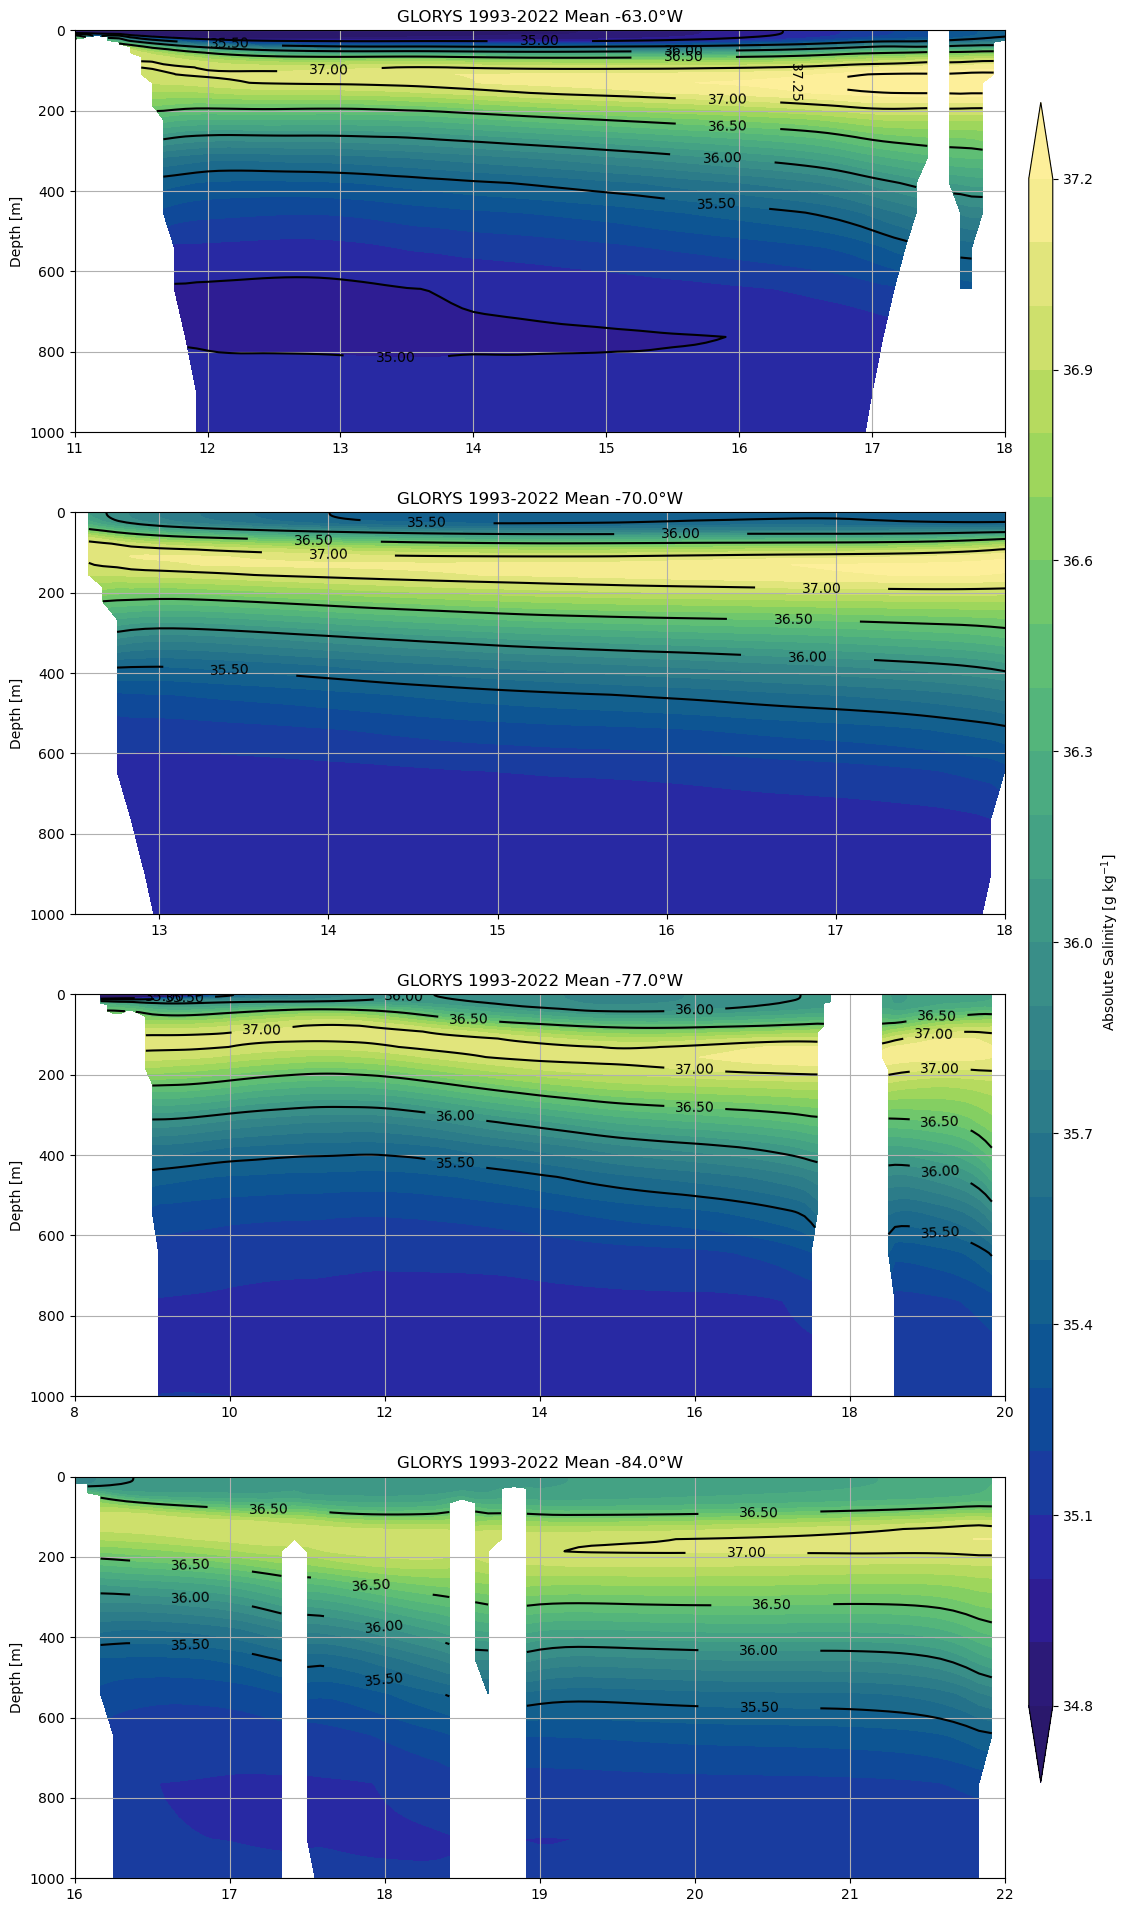

In [26]:
font_size = 12

levels = np.arange(34.8,37.3,0.1)
contour_levels = [35,35.5,36,36.5,37,37.25]


fig,ax = plt.subplots(4,1,figsize=(12,24))

x=-63

ax[0].contourf(carib_ds.y,carib_ds.depth,carib_ds.where(carib_ds.x==x,drop=True).absolute_salinity.isel(x=0).mean(dim='time'),levels=levels,extend='both',cmap=cmo.haline)
cs = ax[0].contour(carib_ds.y,carib_ds.depth,carib_ds.where(carib_ds.x==x,drop=True).absolute_salinity.isel(x=0).mean(dim='time'),contour_levels,colors='black',linewidth=5)
ax[0].clabel(cs, inline=True, fontsize=10)
ax[0].set_ylabel('Depth [m]')
ax[0].set_ylim(1000,0)
ax[0].set_xlim(11,18)
ax[0].grid()
ax[0].set_title(f'GLORYS 1993-2022 Mean {np.round(carib_ds.where(carib_ds.x==x,drop=True).x.values[0],0)}°W', fontsize=font_size)

x=-70

ax[1].contourf(carib_ds.y,carib_ds.depth,carib_ds.where(carib_ds.x==x,drop=True).absolute_salinity.isel(x=0).mean(dim='time'),levels=levels,extend='both',cmap=cmo.haline)
cs = ax[1].contour(carib_ds.y,carib_ds.depth,carib_ds.where(carib_ds.x==x,drop=True).absolute_salinity.isel(x=0).mean(dim='time'),contour_levels,colors='black',linewidth=5)
ax[1].clabel(cs, inline=True, fontsize=10)
ax[1].set_ylabel('Depth [m]')
ax[1].set_ylim(1000,0)
ax[1].set_xlim(12.5,18)
ax[1].grid()
ax[1].set_title(f'GLORYS 1993-2022 Mean {np.round(carib_ds.where(carib_ds.x==x,drop=True).x.values[0],0)}°W', fontsize=font_size)

x=-77

ax[2].contourf(carib_ds.y,carib_ds.depth,carib_ds.where(carib_ds.x==x,drop=True).absolute_salinity.isel(x=0).mean(dim='time'),levels=levels,extend='both',cmap=cmo.haline)
cs = ax[2].contour(carib_ds.y,carib_ds.depth,carib_ds.where(carib_ds.x==x,drop=True).absolute_salinity.isel(x=0).mean(dim='time'),contour_levels,colors='black',linewidth=5)
ax[2].clabel(cs, inline=True, fontsize=10)
ax[2].set_ylabel('Depth [m]')
ax[2].set_ylim(1000,0)
ax[2].set_xlim(8,20)
ax[2].grid()
ax[2].set_title(f'GLORYS 1993-2022 Mean {np.round(carib_ds.where(carib_ds.x==x,drop=True).x.values[0],0)}°W', fontsize=font_size)

x=-84

d = ax[3].contourf(carib_ds.y,carib_ds.depth,carib_ds.where(carib_ds.x==x,drop=True).absolute_salinity.isel(x=0).mean(dim='time'),levels=levels,extend='both',cmap=cmo.haline)
cs = ax[3].contour(carib_ds.y,carib_ds.depth,carib_ds.where(carib_ds.x==x,drop=True).absolute_salinity.isel(x=0).mean(dim='time'),contour_levels,colors='black',linewidth=5)
ax[3].clabel(cs, inline=True, fontsize=10)
ax[3].set_ylabel('Depth [m]')
ax[3].set_ylim(1000,0)
ax[3].set_xlim(16,22)
ax[3].grid()
ax[3].set_title(f'GLORYS 1993-2022 Mean {np.round(carib_ds.where(carib_ds.x==x,drop=True).x.values[0],0)}°W', fontsize=font_size)



cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
fig.colorbar(d, cax=cbar_ax,label='Absolute Salinity [g kg$^{-1}$]')

# Adjust layout
plt.subplots_adjust(right=0.9)
plt.savefig('/Users/joegradone/SynologyDrive/Drive/Rutgers/Research/figures/Python/Model/GLORYS/GLORYS_Salinity_Longitudinal_Slices.png', bbox_inches='tight',dpi=300,facecolor='white')


In [ ]:
levels = np.arange(5,30,0.2)
contour_levels = [6,8,10,12,14,16,18,20,22,24,26,28]


fig,ax = plt.subplots(4,1,figsize=(12,24))

x=-63

ax[0].contourf(carib_ds.y,carib_ds.depth,carib_ds.where(carib_ds.x==x,drop=True).conservative_temperature.isel(x=0).mean(dim='time'),levels=levels,extend='both',cmap=cmo.thermal)
cs = ax[0].contour(carib_ds.y,carib_ds.depth,carib_ds.where(carib_ds.x==x,drop=True).conservative_temperature.isel(x=0).mean(dim='time'),contour_levels,colors='black',linewidth=5)
ax[0].clabel(cs, inline=True, fontsize=10)
ax[0].set_ylabel('Depth [m]')
ax[0].set_ylim(1000,0)
ax[0].set_xlim(11,18)
ax[0].grid()
ax[0].set_title(f'GLORYS 1993-2022 Mean {np.round(carib_ds.where(carib_ds.x==x,drop=True).x.values[0],0)}°W', fontsize=font_size)

x=-70

ax[1].contourf(carib_ds.y,carib_ds.depth,carib_ds.where(carib_ds.x==x,drop=True).conservative_temperature.isel(x=0).mean(dim='time'),levels=levels,extend='both',cmap=cmo.thermal)
cs = ax[1].contour(carib_ds.y,carib_ds.depth,carib_ds.where(carib_ds.x==x,drop=True).conservative_temperature.isel(x=0).mean(dim='time'),contour_levels,colors='black',linewidth=5)
ax[1].clabel(cs, inline=True, fontsize=10)
ax[1].set_ylabel('Depth [m]')
ax[1].set_ylim(1000,0)
ax[1].set_xlim(12.5,18)
ax[1].grid()
ax[1].set_title(f'GLORYS 1993-2022 Mean {np.round(carib_ds.where(carib_ds.x==x,drop=True).x.values[0],0)}°W', fontsize=font_size)

x=-77

ax[2].contourf(carib_ds.y,carib_ds.depth,carib_ds.where(carib_ds.x==x,drop=True).conservative_temperature.isel(x=0).mean(dim='time'),levels=levels,extend='both',cmap=cmo.thermal)
cs = ax[2].contour(carib_ds.y,carib_ds.depth,carib_ds.where(carib_ds.x==x,drop=True).conservative_temperature.isel(x=0).mean(dim='time'),contour_levels,colors='black',linewidth=5)
ax[2].clabel(cs, inline=True, fontsize=10)
ax[2].set_ylabel('Depth [m]')
ax[2].set_ylim(1000,0)
ax[2].set_xlim(8,20)
ax[2].grid()
ax[2].set_title(f'GLORYS 1993-2022 Mean {np.round(carib_ds.where(carib_ds.x==x,drop=True).x.values[0],0)}°W', fontsize=font_size)

x=-84

d = ax[3].contourf(carib_ds.y,carib_ds.depth,carib_ds.where(carib_ds.x==x,drop=True).conservative_temperature.isel(x=0).mean(dim='time'),levels=levels,extend='both',cmap=cmo.thermal)
cs = ax[3].contour(carib_ds.y,carib_ds.depth,carib_ds.where(carib_ds.x==x,drop=True).conservative_temperature.isel(x=0).mean(dim='time'),contour_levels,colors='black',linewidth=5)
ax[3].clabel(cs, inline=True, fontsize=10)
ax[3].set_ylabel('Depth [m]')
ax[3].set_ylim(1000,0)
ax[3].set_xlim(16,22)
ax[3].grid()
ax[3].set_title(f'GLORYS 1993-2022 Mean {np.round(carib_ds.where(carib_ds.x==x,drop=True).x.values[0],0)}°W', fontsize=font_size)



cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
fig.colorbar(d, cax=cbar_ax,label='Conservative Temperature [°C]')

# Adjust layout
plt.subplots_adjust(right=0.9)
plt.savefig('/Users/joegradone/SynologyDrive/Drive/Rutgers/Research/figures/Python/Model/GLORYS/GLORYS_Temperature_Longitudinal_Slices.png', bbox_inches='tight',dpi=300,facecolor='white')


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_2256/699299821.py:12: UserWarning: The following kwargs were not used by contour: 'linewidth'
  cs = ax[0].contour(carib_ds.x,carib_ds.depth,carib_ds.where(carib_ds.y==y,drop=True).absolute_salinity.isel(y=0).mean(dim='time'),contour_levels,colors='black',linewidth=5)
/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_2256/699299821.py:23: UserWarning: The following kwargs were not used by contour: 'linewidth'
  cs = ax[1].contour(carib_ds.x,carib_ds.depth,carib_ds.where(carib_ds.y==y,drop=True).absolute_salinity.isel(y=0).mean(dim='time'),contour_levels,colors='black',linewidth=5)


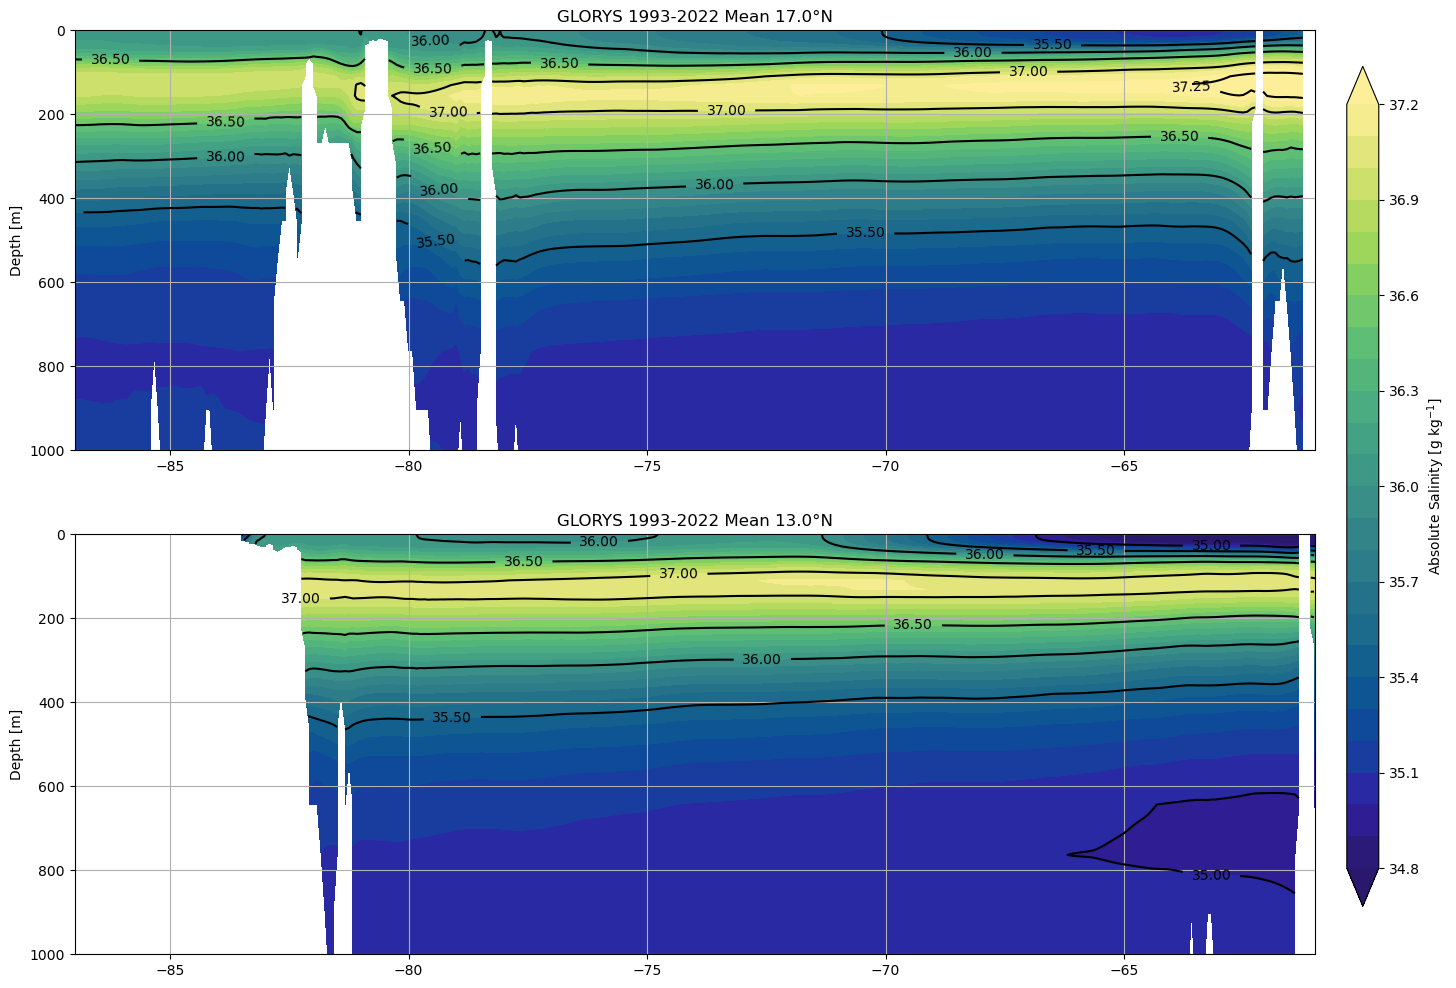

In [42]:
font_size = 12

levels = np.arange(34.8,37.3,0.1)
contour_levels = [35,35.5,36,36.5,37,37.25]


fig,ax = plt.subplots(2,1,figsize=(16,12))

y=16.75

ax[0].contourf(carib_ds.x,carib_ds.depth,carib_ds.where(carib_ds.y==y,drop=True).absolute_salinity.isel(y=0).mean(dim='time'),levels=levels,extend='both',cmap=cmo.haline)
cs = ax[0].contour(carib_ds.x,carib_ds.depth,carib_ds.where(carib_ds.y==y,drop=True).absolute_salinity.isel(y=0).mean(dim='time'),contour_levels,colors='black',linewidth=5)
ax[0].clabel(cs, inline=True, fontsize=10)
ax[0].set_ylabel('Depth [m]')
ax[0].set_ylim(1000,0)
ax[0].set_xlim(-87,-61)
ax[0].grid()
ax[0].set_title(f'GLORYS 1993-2022 Mean {np.round(carib_ds.where(carib_ds.y==y,drop=True).y.values[0],0)}°N', fontsize=font_size)

y=13.25

d = ax[1].contourf(carib_ds.x,carib_ds.depth,carib_ds.where(carib_ds.y==y,drop=True).absolute_salinity.isel(y=0).mean(dim='time'),levels=levels,extend='both',cmap=cmo.haline)
cs = ax[1].contour(carib_ds.x,carib_ds.depth,carib_ds.where(carib_ds.y==y,drop=True).absolute_salinity.isel(y=0).mean(dim='time'),contour_levels,colors='black',linewidth=5)
ax[1].clabel(cs, inline=True, fontsize=10)
ax[1].set_ylabel('Depth [m]')
ax[1].set_ylim(1000,0)
ax[1].set_xlim(-87,-61)
ax[1].grid()
ax[1].set_title(f'GLORYS 1993-2022 Mean {np.round(carib_ds.where(carib_ds.y==y,drop=True).y.values[0],0)}°N', fontsize=font_size)


cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
fig.colorbar(d, cax=cbar_ax,label='Absolute Salinity [g kg$^{-1}$]')

# Adjust layout
plt.subplots_adjust(right=0.9)
plt.savefig('/Users/joegradone/SynologyDrive/Drive/Rutgers/Research/figures/Python/Model/GLORYS/GLORYS_Salinity_Latitudinal_Slices.png', bbox_inches='tight',dpi=300,facecolor='white')


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_2256/1729715252.py:12: UserWarning: The following kwargs were not used by contour: 'linewidth'
  cs = ax[0].contour(carib_ds.x,carib_ds.depth,carib_ds.where(carib_ds.y==y,drop=True).conservative_temperature.isel(y=0).mean(dim='time'),contour_levels,colors='black',linewidth=5)
/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_2256/1729715252.py:23: UserWarning: The following kwargs were not used by contour: 'linewidth'
  cs = ax[1].contour(carib_ds.x,carib_ds.depth,carib_ds.where(carib_ds.y==y,drop=True).conservative_temperature.isel(y=0).mean(dim='time'),contour_levels,colors='black',linewidth=5)


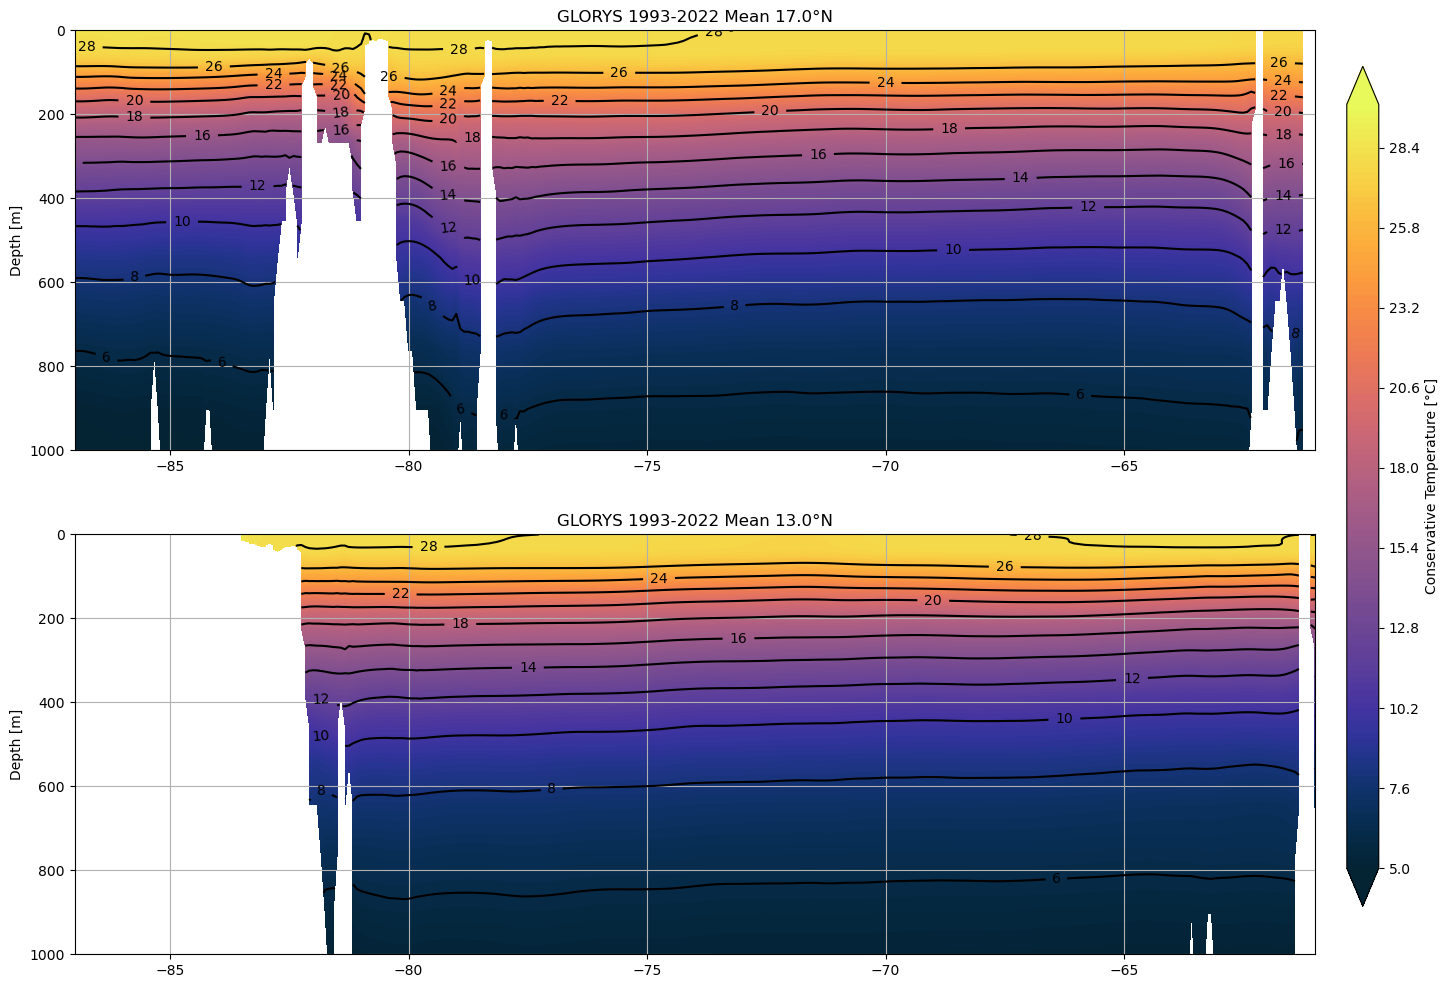

In [43]:
font_size = 12

levels = np.arange(5,30,0.2)
contour_levels = [6,8,10,12,14,16,18,20,22,24,26,28]


fig,ax = plt.subplots(2,1,figsize=(16,12))

y=16.75

ax[0].contourf(carib_ds.x,carib_ds.depth,carib_ds.where(carib_ds.y==y,drop=True).conservative_temperature.isel(y=0).mean(dim='time'),levels=levels,extend='both',cmap=cmo.thermal)
cs = ax[0].contour(carib_ds.x,carib_ds.depth,carib_ds.where(carib_ds.y==y,drop=True).conservative_temperature.isel(y=0).mean(dim='time'),contour_levels,colors='black',linewidth=5)
ax[0].clabel(cs, inline=True, fontsize=10)
ax[0].set_ylabel('Depth [m]')
ax[0].set_ylim(1000,0)
ax[0].set_xlim(-87,-61)
ax[0].grid()
ax[0].set_title(f'GLORYS 1993-2022 Mean {np.round(carib_ds.where(carib_ds.y==y,drop=True).y.values[0],0)}°N', fontsize=font_size)

y=13.25

d = ax[1].contourf(carib_ds.x,carib_ds.depth,carib_ds.where(carib_ds.y==y,drop=True).conservative_temperature.isel(y=0).mean(dim='time'),levels=levels,extend='both',cmap=cmo.thermal)
cs = ax[1].contour(carib_ds.x,carib_ds.depth,carib_ds.where(carib_ds.y==y,drop=True).conservative_temperature.isel(y=0).mean(dim='time'),contour_levels,colors='black',linewidth=5)
ax[1].clabel(cs, inline=True, fontsize=10)
ax[1].set_ylabel('Depth [m]')
ax[1].set_ylim(1000,0)
ax[1].set_xlim(-87,-61)
ax[1].grid()
ax[1].set_title(f'GLORYS 1993-2022 Mean {np.round(carib_ds.where(carib_ds.y==y,drop=True).y.values[0],0)}°N', fontsize=font_size)


cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
fig.colorbar(d, cax=cbar_ax,label='Conservative Temperature [°C]')

# Adjust layout
plt.subplots_adjust(right=0.9)
plt.savefig('/Users/joegradone/SynologyDrive/Drive/Rutgers/Research/figures/Python/Model/GLORYS/GLORYS_Temperature_Latitudinal_Slices.png', bbox_inches='tight',dpi=300,facecolor='white')


## Salinity maximum depth

In [ ]:
carib_ds['salinity_max_depth'] = carib_ds.absolute_salinity.isel(depth=slice(21,31)).idxmax(dim='depth')


In [ ]:

fig, ax = plt.subplots(figsize=(14,7),subplot_kw=dict(projection=cartopy.crs.PlateCarree()))

im = ax.contourf(carib_ds.x,carib_ds.y,carib_ds.salinity_max_depth.mean(dim='time'),transform =cartopy.crs.PlateCarree(),cmap=cmo.deep,levels=np.arange(100,181,1))
plt.colorbar(im, ax=ax,label='Mean Depth of Salinity Maximum [meters]',fraction=0.022)
cs = plt.contour(carib_ds.x,carib_ds.y,carib_ds.salinity_max_depth.mean(dim='time'),[110,120,130,140,150,160,170],colors='black',linewidth=5,transform =cartopy.crs.PlateCarree())
plt.clabel(cs, inline=True, fontsize=10)

ax.coastlines(linewidth=1.0,zorder=10)
ax.add_feature(cartopy.feature.LAND,zorder=10)
glb = ax.gridlines(draw_labels=True, alpha=0.5, linewidth=.5 )
glb.xlabels_top = glb.ylabels_right = False

plt.savefig('/Users/joegradone/SynologyDrive/Drive/Rutgers/Research/figures/Python/Model/GLORYS/GLORYS_Salinity_Max_Depth_Map_Carib.png', bbox_inches='tight',dpi=300,facecolor='white')


In [ ]:
ds['salinity_max_depth'] = ds.absolute_salinity.isel(depth=slice(21,31)).idxmax(dim='depth')


In [ ]:

fig, ax = plt.subplots(figsize=(14,7),subplot_kw=dict(projection=cartopy.crs.PlateCarree()))

im = ax.contourf(ds.x,ds.y,ds.salinity_max_depth.mean(dim='time'),transform =cartopy.crs.PlateCarree(),cmap=cmo.deep,levels=np.arange(100,181,1))
plt.colorbar(im, ax=ax,label='Mean Depth of Salinity Maximum [meters]')
cs = plt.contour(ds.x,ds.y,ds.salinity_max_depth.mean(dim='time'),[110,120,130,140,150,160,170],colors='black',linewidth=5,transform =cartopy.crs.PlateCarree())
plt.clabel(cs, inline=True, fontsize=10)

ax.coastlines(linewidth=1.0,zorder=10)
ax.add_feature(cartopy.feature.LAND,zorder=10)
glb = ax.gridlines(draw_labels=True, alpha=0.5, linewidth=.5 )
glb.xlabels_top = glb.ylabels_right = False
ax.set_extent([-92, -58, 7.5, 30])

plt.savefig('/Users/joegradone/SynologyDrive/Drive/Rutgers/Research/figures/Python/Model/GLORYS/GLORYS_Salinity_Max_Depth_Map.png', bbox_inches='tight',dpi=300,facecolor='white')


## 26deg Isotherm

In [ ]:
carib_ds['twentysix_isotherm'] = np.abs(26-carib_ds.conservative_temperature).idxmin(dim='depth')
ds['twentysix_isotherm'] = np.abs(26-ds.conservative_temperature).idxmin(dim='depth')

In [ ]:
fig, ax = plt.subplots(figsize=(14,7),subplot_kw=dict(projection=cartopy.crs.PlateCarree()))

im = ax.contourf(carib_ds.x,carib_ds.y,carib_ds.twentysix_isotherm.mean(dim='time'),transform =cartopy.crs.PlateCarree(),cmap=cmo.deep,levels=np.arange(40,121,1))
ax.coastlines(linewidth=1.0,zorder=10)
ax.add_feature(cartopy.feature.LAND,zorder=10)
plt.colorbar(im, ax=ax,label='Mean Depth of the 26 Degree Isotherm [meters]',fraction=0.022)
glb = ax.gridlines(draw_labels=True, alpha=0.5, linewidth=.5 )
glb.xlabels_top = glb.ylabels_right = False

cs = plt.contour(carib_ds.x,carib_ds.y,carib_ds.twentysix_isotherm.mean(dim='time'),[40,50,60,70,80,90,100,110],colors='black',linewidth=5,transform =cartopy.crs.PlateCarree())
plt.clabel(cs, inline=True, fontsize=10)

plt.savefig('/Users/joegradone/SynologyDrive/Drive/Rutgers/Research/figures/Python/Model/GLORYS/ECCO_26_Deg_Isotherm_Depth_Map_Carib.png', bbox_inches='tight',dpi=300,facecolor='white')


In [ ]:
fig, ax = plt.subplots(figsize=(14,7),subplot_kw=dict(projection=cartopy.crs.PlateCarree()))

im = ax.contourf(ds.x,ds.y,ds.twentysix_isotherm.mean(dim='time'),transform =cartopy.crs.PlateCarree(),cmap=cmo.deep,levels=np.arange(40,121,1))
ax.coastlines(linewidth=1.0,zorder=10)
ax.add_feature(cartopy.feature.LAND,zorder=10)
plt.colorbar(im, ax=ax,label='Mean Depth of the 26 Degree Isotherm [meters]')
glb = ax.gridlines(draw_labels=True, alpha=0.5, linewidth=.5 )
glb.xlabels_top = glb.ylabels_right = False

cs = plt.contour(ds.x,ds.y,ds.twentysix_isotherm.mean(dim='time'),[40,50,60,70,80,90,100,110],colors='black',linewidth=5,transform =cartopy.crs.PlateCarree())
plt.clabel(cs, inline=True, fontsize=10)
ax.set_extent([-92, -58, 7.5, 30])

plt.savefig('/Users/joegradone/SynologyDrive/Drive/Rutgers/Research/figures/Python/Model/GLORYS/GLORYS_26_Deg_Isotherm_Depth_Map.png', bbox_inches='tight',dpi=300,facecolor='white')


## West-East Deltas

In [ ]:
ew_glorys_mean_profile_delta = west_glorys_mean_profile-east_glorys_mean_profile
ew_glorys_mean_profile_delta

## Standard deviations

In [ ]:
ew_glorys_mean_profile_delta_std = np.sqrt(west_glorys_mean_profile_std**2 + east_glorys_mean_profile_std**2)
ew_glorys_mean_profile_delta_std

In [ ]:
fig,ax = plt.subplots(1,3,figsize=(12,6))

ax[0].plot(ew_glorys_mean_profile_delta.conservative_temperature,ew_glorys_mean_profile_delta.depth,color='tab:blue')
ax[0].fill_betweenx(ew_glorys_mean_profile_delta.depth,ew_glorys_mean_profile_delta.conservative_temperature+ew_glorys_mean_profile_delta_std.conservative_temperature,ew_glorys_mean_profile_delta.conservative_temperature-ew_glorys_mean_profile_delta_std.conservative_temperature,color='tab:blue',alpha=0.4)
ax[0].set_ylabel('Depth [m]')
ax[0].set_ylim(1000,0)
ax[0].set_xlabel('Conservative Temperature Difference [°C]')
ax[0].grid()

ax[1].plot(ew_glorys_mean_profile_delta.absolute_salinity,ew_glorys_mean_profile_delta.depth,color='tab:blue')
ax[1].fill_betweenx(ew_glorys_mean_profile_delta.depth,ew_glorys_mean_profile_delta.absolute_salinity+ew_glorys_mean_profile_delta_std.absolute_salinity,ew_glorys_mean_profile_delta.absolute_salinity-ew_glorys_mean_profile_delta_std.absolute_salinity,color='tab:blue',alpha=0.4)
ax[1].set_ylim(1000,0)
ax[1].set_xlabel('Absolute Salinity Difference [g kg$^{-1}$]')
ax[1].grid()
ax[1].set_title('Mean Western Caribbean Profiles minus Mean Eastern Caribbean Profiles')

ax[2].plot(ew_glorys_mean_profile_delta.potential_density,ew_glorys_mean_profile_delta.depth,color='tab:blue')
ax[2].fill_betweenx(ew_glorys_mean_profile_delta.depth,ew_glorys_mean_profile_delta.potential_density+ew_glorys_mean_profile_delta_std.potential_density,ew_glorys_mean_profile_delta.potential_density-ew_glorys_mean_profile_delta_std.potential_density,color='tab:blue',alpha=0.4)
ax[2].set_ylim(1000,0)
ax[2].set_xlabel('Potential Density Difference [kg m$^{-3}$]')
ax[2].grid()


## Water Mass Decomposition

In [ ]:
dz = 1
grid_depth = np.arange(0.5, np.nanmax(east_glorys_mean_profile.depth.values), dz)

def interp_along_depth(depth, var, grid_depth):
    interp_func = interp1d(depth, var, kind='linear',fill_value=np.nan,bounds_error=False)
    return interp_func(grid_depth)


east_glorys_mean_temp_interp = interp_along_depth(east_glorys_mean_profile.depth,east_glorys_mean_profile.conservative_temperature,grid_depth)
east_glorys_mean_salt_interp = interp_along_depth(east_glorys_mean_profile.depth,east_glorys_mean_profile.absolute_salinity,grid_depth)
east_glorys_mean_den_interp = interp_along_depth(east_glorys_mean_profile.depth,east_glorys_mean_profile.potential_density,grid_depth)

west_glorys_mean_temp_interp = interp_along_depth(west_glorys_mean_profile.depth,west_glorys_mean_profile.conservative_temperature,grid_depth)
west_glorys_mean_salt_interp = interp_along_depth(west_glorys_mean_profile.depth,west_glorys_mean_profile.absolute_salinity,grid_depth)
west_glorys_mean_den_interp = interp_along_depth(west_glorys_mean_profile.depth,west_glorys_mean_profile.potential_density,grid_depth)

ew_decomposition = water_mass_decomposition(east_glorys_mean_salt_interp,east_glorys_mean_temp_interp,east_glorys_mean_den_interp,west_glorys_mean_salt_interp,west_glorys_mean_temp_interp,west_glorys_mean_den_interp,grid_depth)
ew_decomposition

In [ ]:

title_size = 19
font_size = 15

sal_major_ticks = np.arange(-1, 1.01, 0.5)
sal_minor_ticks = np.arange(-1, 1.01, 0.25)
temp_major_ticks = np.arange(-2, 2.01, 1)
temp_minor_ticks = np.arange(-2.5, 2.51, 0.5)

depth_ticks = np.arange(0, 950, 100)


fig, axs = plt.subplots(1, 2,figsize=(10, 8))

axs[0].plot(ew_decomposition.temp_resid, ew_decomposition.depth, label='Residual',linewidth=1, color='black')
axs[0].plot(ew_decomposition.heave_temp, ew_decomposition.depth, label='Heave',linewidth=lwd,color='tab:cyan')
axs[0].plot(ew_decomposition.spice_temp, ew_decomposition.depth, label='Spice',linewidth=lwd,color='tab:orange')    
axs[0].plot(ew_decomposition.temp_diff, ew_decomposition.depth, label='Total',linewidth=lwd,color='tab:blue')
axs[0].grid()
axs[0].set_ylim(990,0)
axs[0].set_xlim(-2.5,2.5)
axs[0].set_xlabel('Conservative Temperature\nDifference [°C]',fontsize=font_size)
axs[0].set_ylabel('Depth [m]',fontsize=font_size)
axs[0].tick_params(axis='both', which='major', labelsize=font_size)
axs[0].text(0.005,0.95,'(a)', transform=axs[0].transAxes, size=title_size, weight='bold')

axs[1].plot(ew_decomposition.salt_resid, ew_decomposition.depth, label='Residual',linewidth=1, color='black')
axs[1].plot(ew_decomposition.heave_salt, ew_decomposition.depth, label='Heave',linewidth=lwd,color='tab:cyan')
axs[1].plot(ew_decomposition.spice_salt, ew_decomposition.depth, label='Spice',linewidth=lwd,color='tab:orange')
axs[1].plot(ew_decomposition.salt_diff, ew_decomposition.depth, label='Total',linewidth=lwd,color='tab:blue')

axs[1].grid()
axs[1].set_ylim(990,0)
axs[1].set_xlim(-1,1)
axs[1].set_xlabel('Absolute Salinity\nDifference [g kg$^{-1}$]',fontsize=font_size)
axs[1].legend(loc=(0,-0.01),frameon=False,fontsize=font_size)
axs[1].tick_params(axis='both', which='major', labelsize=font_size)
axs[1].text(0.005,0.95,'(b)', transform=axs[1].transAxes, size=title_size, weight='bold')

## Grid stuff
axs[0].set_yticks(depth_ticks)
axs[1].set_yticks(depth_ticks)
axs[0].set_xticks(temp_major_ticks)
axs[0].set_xticks(temp_minor_ticks, minor=True)
axs[0].grid(which='minor', alpha=0.2)
axs[0].grid(which='major', alpha=0.9)
axs[1].set_xticks(sal_major_ticks)
axs[1].set_xticks(sal_minor_ticks, minor=True)
axs[1].grid(which='minor', alpha=0.2)
axs[1].grid(which='major', alpha=0.9)
plt.suptitle('Mean Western Caribbean Profiles minus Eastern Caribbean Profiles',y=0.92,fontsize=font_size)


## In density space now

In [ ]:
drho = 0.01
grid_den = np.arange(np.nanmin(east_glorys_mean_profile_den.density.values), np.nanmax(east_glorys_mean_profile_den.density.values), drho)

# Define a function that applies np.gradient along the depth dimension
def interp_along_density(density, var, grid_den):
    interp_func = interp1d(density, var, kind='linear',fill_value=np.nan,bounds_error=False)
    return interp_func(grid_den)


east_glorys_mean_temp_by_den = interp_along_density(east_glorys_mean_profile_den.density,east_glorys_mean_profile_den.conservative_temperature,grid_den)
east_glorys_mean_salt_by_den = interp_along_density(east_glorys_mean_profile_den.density,east_glorys_mean_profile_den.absolute_salinity,grid_den)
east_glorys_mean_depth_by_den = interp_along_density(east_glorys_mean_profile_den.density,east_glorys_mean_profile.depth,grid_den)
east_glorys_mean_temp_by_den_std = interp_along_density(east_glorys_mean_profile.potential_density,east_glorys_mean_profile_std.conservative_temperature,grid_den)
east_glorys_mean_salt_by_den_std = interp_along_density(east_glorys_mean_profile.potential_density,east_glorys_mean_profile_std.absolute_salinity,grid_den)


central_glorys_mean_temp_by_den = interp_along_density(central_glorys_mean_profile_den.density,central_glorys_mean_profile_den.conservative_temperature,grid_den)
central_glorys_mean_salt_by_den = interp_along_density(central_glorys_mean_profile_den.density,central_glorys_mean_profile_den.absolute_salinity,grid_den)
central_glorys_mean_depth_by_den = interp_along_density(central_glorys_mean_profile_den.density,central_glorys_mean_profile.depth,grid_den)
central_glorys_mean_temp_by_den_std = interp_along_density(central_glorys_mean_profile.potential_density,central_glorys_mean_profile_std.conservative_temperature,grid_den)
central_glorys_mean_salt_by_den_std = interp_along_density(central_glorys_mean_profile.potential_density,central_glorys_mean_profile_std.absolute_salinity,grid_den)

west_glorys_mean_temp_by_den = interp_along_density(west_glorys_mean_profile_den.density,west_glorys_mean_profile_den.conservative_temperature,grid_den)
west_glorys_mean_salt_by_den = interp_along_density(west_glorys_mean_profile_den.density,west_glorys_mean_profile_den.absolute_salinity,grid_den)
west_glorys_mean_depth_by_den = interp_along_density(west_glorys_mean_profile_den.density,west_glorys_mean_profile.depth,grid_den)
west_glorys_mean_temp_by_den_std = interp_along_density(west_glorys_mean_profile.potential_density,west_glorys_mean_profile_std.conservative_temperature,grid_den)
west_glorys_mean_salt_by_den_std = interp_along_density(west_glorys_mean_profile.potential_density,west_glorys_mean_profile_std.absolute_salinity,grid_den)


## Not sure how to deal with depth and how density surfaces vary with depth...

In [ ]:
east_carib_ds.mean(dim=['x','y']).assign_coords(density = east_carib_ds.mean(dim=['x','y']).potential_density)

In [ ]:
lwd = 3
plt.figure(figsize=(10,8))
plt.plot(east_glorys_mean_salt_by_den,grid_den,label='east',linewidth=lwd)
plt.plot(central_glorys_mean_salt_by_den,grid_den,label='central',linewidth=lwd)
plt.plot(west_glorys_mean_salt_by_den,grid_den,label='west',linewidth=lwd)
plt.ylim(1028,1022)
plt.legend()
plt.grid()
plt.ylabel('Density [kg m$^{-3}$]')
plt.xlabel('Absolute Salinity [g kg$^{-1}$]')

In [ ]:
lwd = 3
plt.figure(figsize=(10,8))
plt.plot(east_glorys_mean_temp_by_den,grid_den,label='east',linewidth=lwd)
plt.plot(central_glorys_mean_temp_by_den,grid_den,label='central',linewidth=lwd)
plt.plot(west_glorys_mean_temp_by_den,grid_den,label='west',linewidth=lwd)
plt.ylim(1028,1022)
plt.legend()
plt.grid()
plt.ylabel('Density [kg m$^{-3}$]')
plt.xlabel('Conservative Temperature [°C]')

## West-East Delta Profiles

In [ ]:
ew_mean_salt_profile_delta_den = west_glorys_mean_salt_by_den-east_glorys_mean_salt_by_den
ew_mean_temp_profile_delta_den = west_glorys_mean_temp_by_den-east_glorys_mean_temp_by_den
ew_mean_depth_profile_delta_den = west_glorys_mean_depth_by_den-east_glorys_mean_depth_by_den

ew_mean_temp_profile_delta_std = np.sqrt(west_glorys_mean_temp_by_den**2 + east_glorys_mean_temp_by_den**2)
ew_mean_salt_profile_delta_std = np.sqrt(west_glorys_mean_salt_by_den**2 + east_glorys_mean_salt_by_den**2)


In [ ]:
lwd = 3


plt.figure(figsize=(10,8))
plt.plot(ew_mean_salt_profile_delta_den,grid_den,linewidth=lwd)
plt.ylim(1028,1022)
plt.xlim(-0.32,0.32)
plt.grid()
plt.ylabel('Density [kg m$^{-3}$]')
plt.xlabel('Absolute Salinity Delta [g kg$^{-1}$]')
plt.title('Mean Western Caribbean Profiles minus Mean Eastern Caribbean Profiles in Density Space')


In [ ]:
fig,ax = plt.subplots(1,3,figsize=(12,6))

ax[0].plot(ew_mean_temp_profile_delta_den,grid_den,color='tab:blue')
ax[0].set_ylabel('Depth [m]')
ax[0].set_ylim(1028,1023)
ax[0].set_xlim(-1,1)
ax[0].set_xlabel('Conservative Temperature Difference [°C]')
ax[0].grid()

ax[1].plot(ew_mean_salt_profile_delta_den,grid_den,color='tab:blue')
ax[1].set_xlim(-0.3,0.3)
ax[1].set_ylim(1028,1023)
ax[1].set_xlabel('Absolute Salinity Difference [g kg$^{-1}$]')
ax[1].grid()
ax[1].set_title('Mean Western Caribbean Profiles minus Mean Eastern Caribbean Profiles in Density Space')

ax[2].plot(ew_mean_depth_profile_delta_den,grid_den,color='tab:blue')
ax[2].set_ylim(1028,1023)
ax[2].set_xlim(-75,75)
ax[2].set_xlabel('Depth Difference [m]')
ax[2].grid()


In [ ]:
carib_ds.groupby(carib_ds.time.dt.month).mean().mean(dim='y').absolute_salinity_anomaly.isel(depth=10).plot(vmin=-1,vmax=1,cmap='RdBu_r')

In [ ]:
carib_ds.groupby(carib_ds.time.dt.month).mean().mean(dim='y').absolute_salinity_anomaly.isel(depth=19).plot(vmin=-0.2,vmax=0.2,cmap='RdBu_r')

In [ ]:
carib_ds.groupby(carib_ds.time.dt.month).mean().mean(dim='y').absolute_salinity_anomaly.isel(depth=20).plot(vmin=-0.2,vmax=0.2,cmap='RdBu_r')

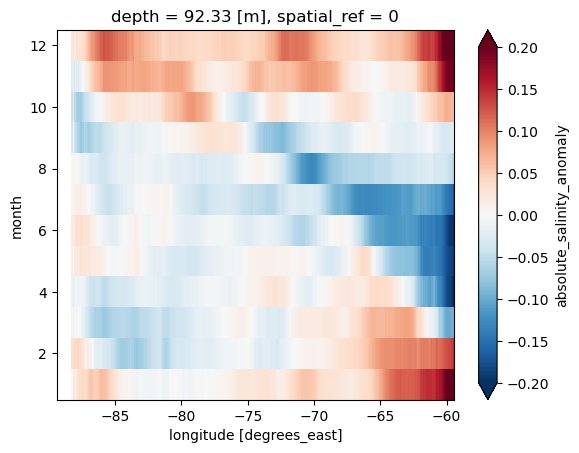

In [392]:
carib_ds.groupby(carib_ds.time.dt.month).mean().mean(dim='y').absolute_salinity_anomaly.isel(depth=21).plot(vmin=-0.2,vmax=0.2,cmap='RdBu_r')

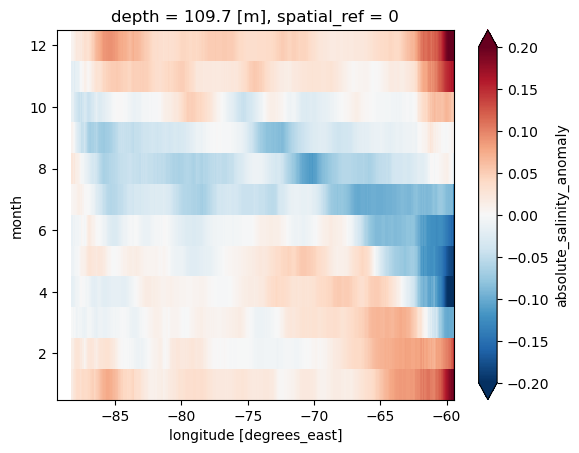

In [389]:
carib_ds.groupby(carib_ds.time.dt.month).mean().mean(dim='y').absolute_salinity_anomaly.isel(depth=22).plot(vmin=-0.2,vmax=0.2,cmap='RdBu_r')

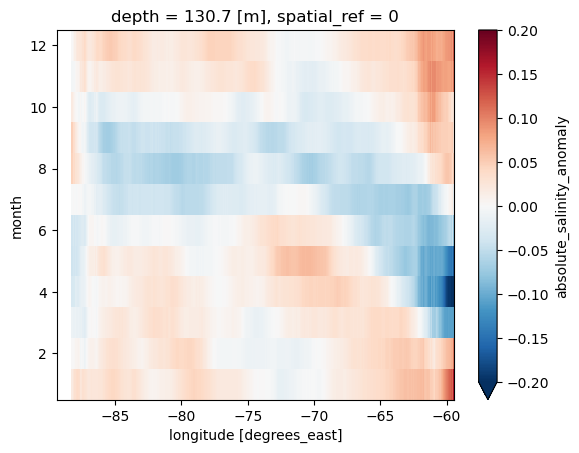

In [388]:
carib_ds.groupby(carib_ds.time.dt.month).mean().mean(dim='y').absolute_salinity_anomaly.isel(depth=23).plot(vmin=-0.2,vmax=0.2,cmap='RdBu_r')

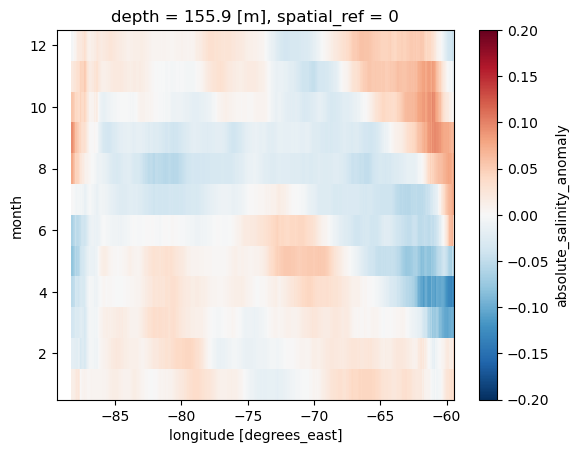

In [390]:
carib_ds.groupby(carib_ds.time.dt.month).mean().mean(dim='y').absolute_salinity_anomaly.isel(depth=24).plot(vmin=-0.2,vmax=0.2,cmap='RdBu_r')

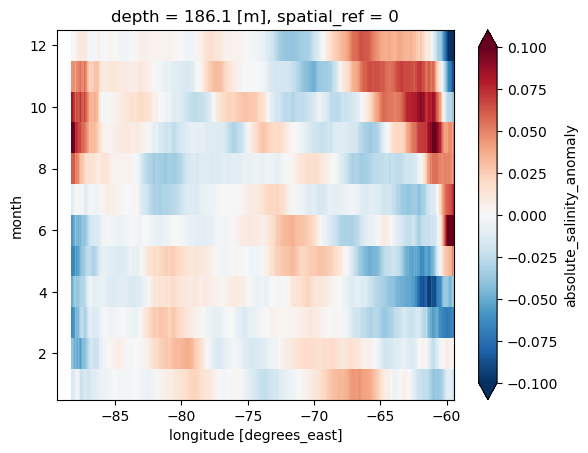

In [406]:
carib_ds.groupby(carib_ds.time.dt.month).mean().mean(dim='y').absolute_salinity_anomaly.isel(depth=25).plot(vmin=-0.1,vmax=0.1,cmap='RdBu_r')

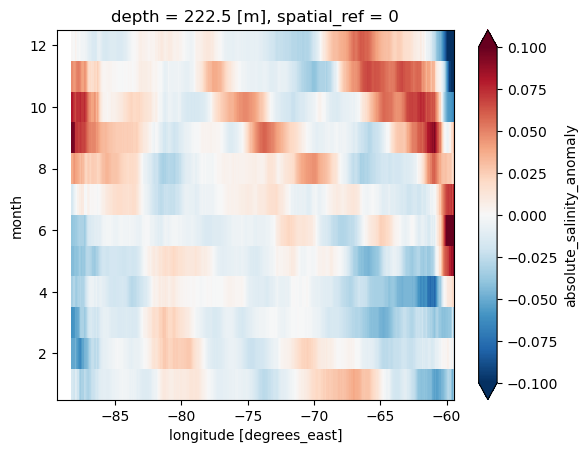

In [405]:
carib_ds.groupby(carib_ds.time.dt.month).mean().mean(dim='y').absolute_salinity_anomaly.isel(depth=26).plot(vmin=-0.1,vmax=0.1,cmap='RdBu_r')

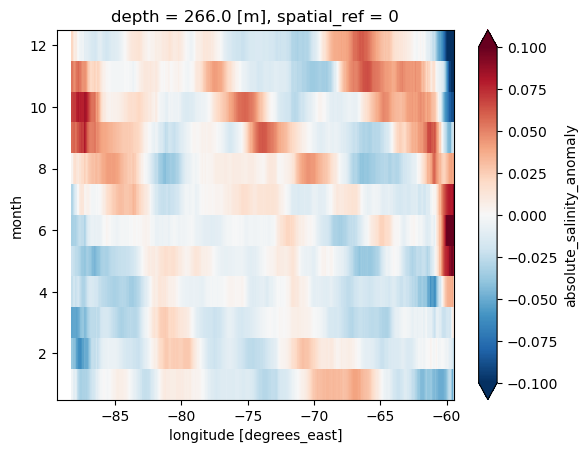

In [407]:
carib_ds.groupby(carib_ds.time.dt.month).mean().mean(dim='y').absolute_salinity_anomaly.isel(depth=27).plot(vmin=-0.1,vmax=0.1,cmap='RdBu_r')

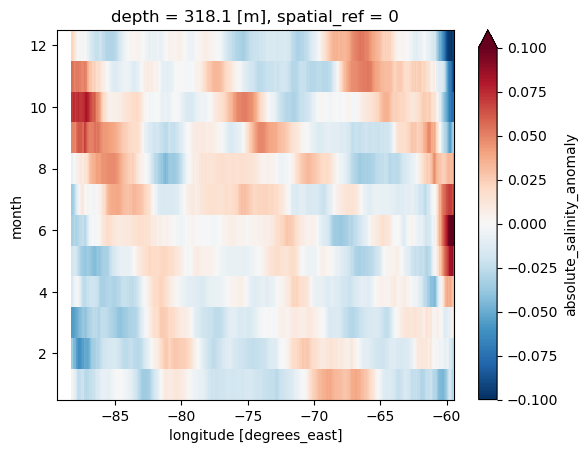

In [403]:
carib_ds.groupby(carib_ds.time.dt.month).mean().mean(dim='y').absolute_salinity_anomaly.isel(depth=28).plot(vmin=-0.1,vmax=0.1,cmap='RdBu_r')

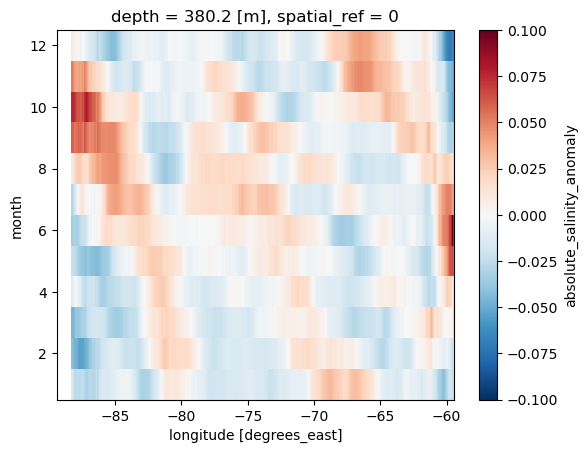

In [404]:
carib_ds.groupby(carib_ds.time.dt.month).mean().mean(dim='y').absolute_salinity_anomaly.isel(depth=29).plot(vmin=-0.1,vmax=0.1,cmap='RdBu_r')

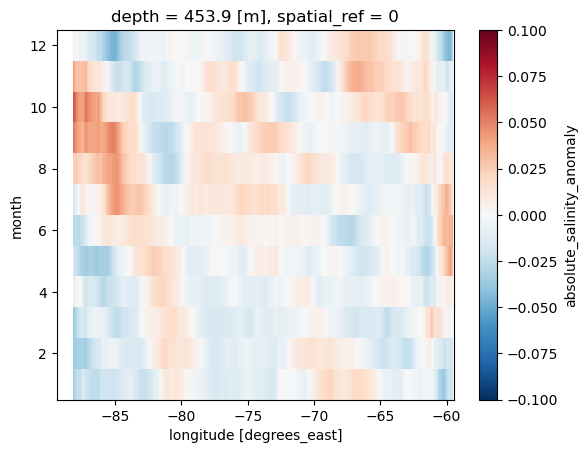

In [408]:
carib_ds.groupby(carib_ds.time.dt.month).mean().mean(dim='y').absolute_salinity_anomaly.isel(depth=30).plot(vmin=-0.1,vmax=0.1,cmap='RdBu_r')

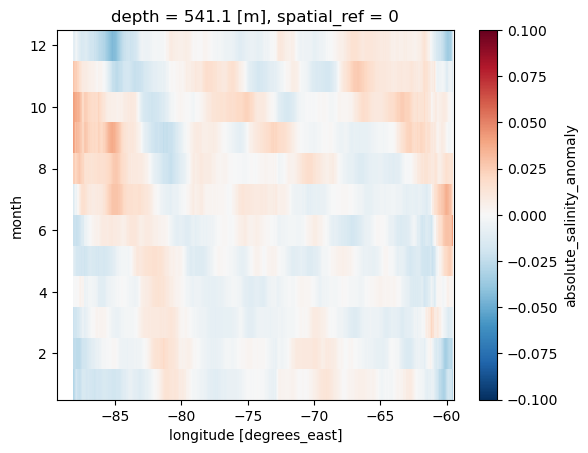

In [421]:
carib_ds.groupby(carib_ds.time.dt.month).mean().mean(dim='y').absolute_salinity_anomaly.isel(depth=31).plot(vmin=-0.1,vmax=0.1,cmap='RdBu_r')

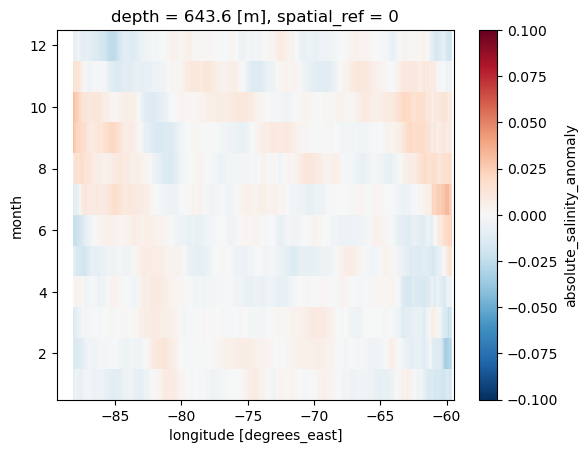

In [420]:
carib_ds.groupby(carib_ds.time.dt.month).mean().mean(dim='y').absolute_salinity_anomaly.isel(depth=32).plot(vmin=-0.1,vmax=0.1,cmap='RdBu_r')

## Now temperature

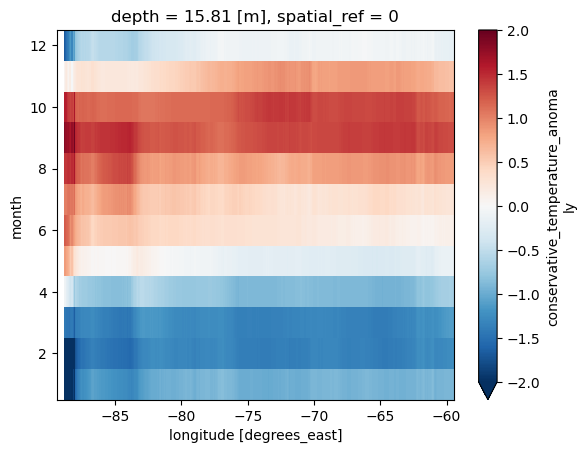

In [424]:
carib_ds.groupby(carib_ds.time.dt.month).mean().mean(dim='y').conservative_temperature_anomaly.isel(depth=10).plot(vmin=-2,vmax=2,cmap='RdBu_r')

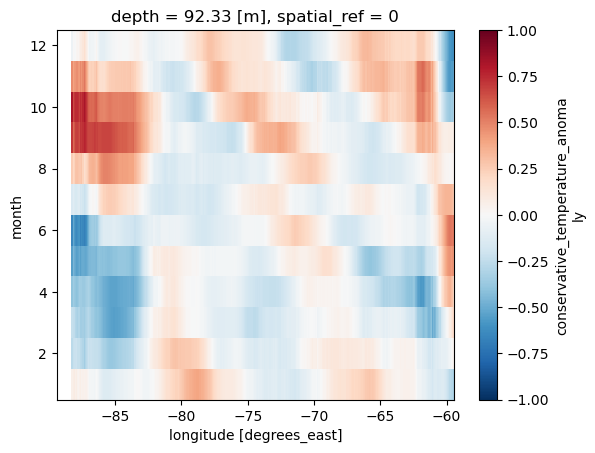

In [428]:
carib_ds.groupby(carib_ds.time.dt.month).mean().mean(dim='y').conservative_temperature_anomaly.isel(depth=21).plot(vmin=-1,vmax=1,cmap='RdBu_r')

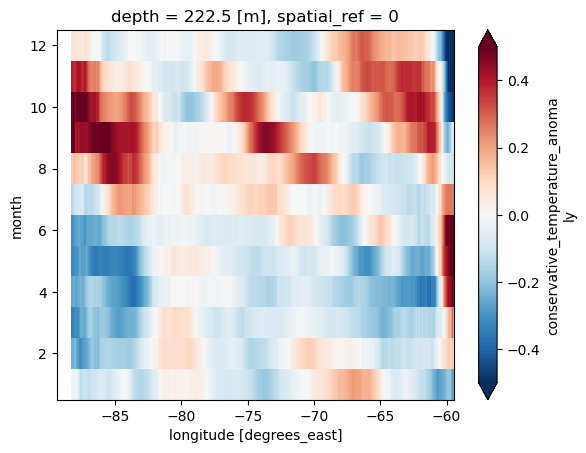

In [443]:
carib_ds.groupby(carib_ds.time.dt.month).mean().mean(dim='y').conservative_temperature_anomaly.isel(depth=26).plot(vmin=-0.5,vmax=0.5,cmap='RdBu_r')

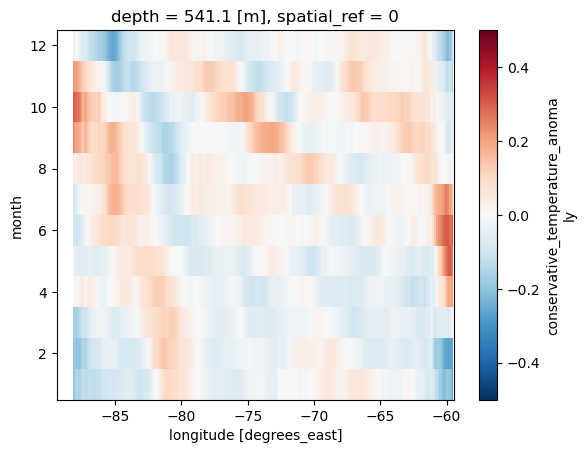

In [445]:
carib_ds.groupby(carib_ds.time.dt.month).mean().mean(dim='y').conservative_temperature_anomaly.isel(depth=31).plot(vmin=-0.5,vmax=0.5,cmap='RdBu_r')

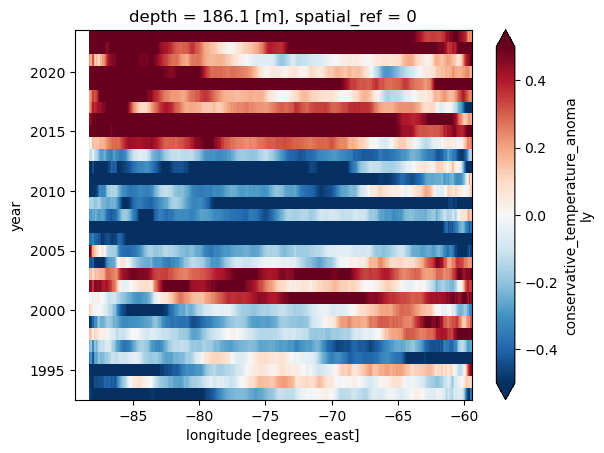

In [455]:
carib_ds.groupby(carib_ds.time.dt.year).mean().mean(dim='y').conservative_temperature_anomaly.isel(depth=25).plot(vmin=-0.5,vmax=0.5,cmap='RdBu_r')

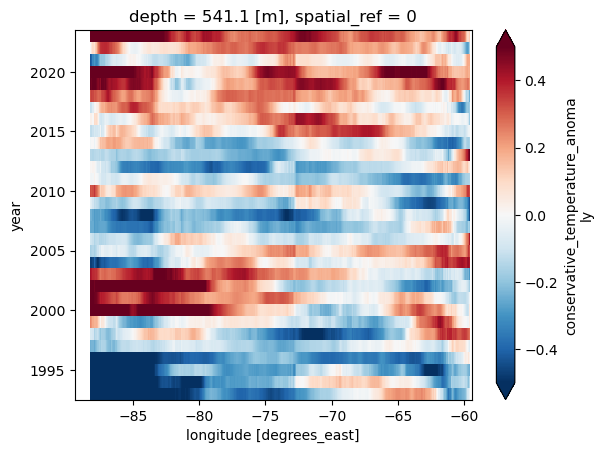

In [454]:
carib_ds.groupby(carib_ds.time.dt.year).mean().mean(dim='y').conservative_temperature_anomaly.isel(depth=31).plot(vmin=-0.5,vmax=0.5,cmap='RdBu_r')

In [ ]:
plt.figure(figsize=(20,10))
carib_ds.mean(dim='y').absolute_salinity_anomaly.isel(depth=22).plot()

## Two sets of loops to make maps of standard deviation of conservative temperature and absolute salinity at difference depth levels

In [ ]:
# x=0
# carib_ds_std = carib_ds.std(dim='time')
# vmax_unscaled = carib_ds_std.absolute_salinity.max(dim=['x','y']).values



# for x in np.arange(0,len(carib_ds.depth)):
#     vmax_scaled = vmax_unscaled[x]*0.5
    
#     fig, ax = plt.subplots(figsize=(14, 8), subplot_kw=dict(projection=cartopy.crs.PlateCarree()))
#     d = ax.pcolormesh(carib_ds.x, carib_ds.y, carib_ds_std.absolute_salinity.isel(depth=x).values,cmap=cmo.haline)
#     plt.colorbar(d,label='Absolute Salinity Standard Deviation [g kg$^{-1}$]',fraction=0.024)
#     ax.coastlines(linewidth=1.0,zorder=10)
#     ax.add_feature(cartopy.feature.LAND,zorder=10)
#     gl = ax.gridlines(draw_labels=True, linestyle='--', color='gray')
#     gl.top_labels = False
#     gl.right_labels = False
#     title = ''.join(['Depth: ',str(int(carib_ds.depth.values[x])),' m'])
#     ax.set_title(title)
    
#     save_fname = ''.join(['/Users/joegradone/SynologyDrive/Drive/Rutgers/Research/figures/Python/Model/GLORYS/salinity_std_maps/Mean_GLORYS_Carib_Salinity_STD_',str(int(carib_ds.depth[x].values)),'_m_depth.png'])
#     plt.savefig(save_fname, bbox_inches='tight',dpi=300,facecolor='white')
#     plt.close()  # Close the figure to avoid displaying it


In [ ]:
# x=0
# carib_ds_std = carib_ds.std(dim='time')
# vmax_unscaled = carib_ds_std.conservative_temperature.max(dim=['x','y']).values



# for x in np.arange(0,len(carib_ds.depth)):
#     vmax_scaled = vmax_unscaled[x]*0.5
    
#     fig, ax = plt.subplots(figsize=(14, 8), subplot_kw=dict(projection=cartopy.crs.PlateCarree()))
#     d = ax.pcolormesh(carib_ds.x, carib_ds.y, carib_ds_std.conservative_temperature.isel(depth=x).values,cmap=cmo.thermal)
#     plt.colorbar(d,label='Conservative Temperature Standard Deviation [°C]',fraction=0.024)
#     ax.coastlines(linewidth=1.0,zorder=10)
#     ax.add_feature(cartopy.feature.LAND,zorder=10)
#     gl = ax.gridlines(draw_labels=True, linestyle='--', color='gray')
#     gl.top_labels = False
#     gl.right_labels = False
#     title = ''.join(['Depth: ',str(int(carib_ds.depth.values[x])),' m'])
#     ax.set_title(title)
    
#     save_fname = ''.join(['/Users/joegradone/SynologyDrive/Drive/Rutgers/Research/figures/Python/Model/GLORYS/temp_std_maps/Mean_GLORYS_Carib_Temperature_STD_',str(int(carib_ds.depth[x].values)),'_m_depth.png'])
#     plt.savefig(save_fname, bbox_inches='tight',dpi=300,facecolor='white')
#     plt.close()  # Close the figure to avoid displaying it


## Anomalies

In [19]:
mean_carib_ds = carib_ds.mean(dim='time')

carib_ds['absolute_salinity_anomaly'] = carib_ds.absolute_salinity-mean_carib_ds.absolute_salinity
carib_ds['conservative_temperature_anomaly'] = carib_ds.conservative_temperature-mean_carib_ds.conservative_temperature

east_carib_ds['absolute_salinity_anomaly'] = east_carib_ds.absolute_salinity-mean_carib_ds.absolute_salinity
central_carib_ds['absolute_salinity_anomaly'] = central_carib_ds.absolute_salinity-mean_carib_ds.absolute_salinity
west_carib_ds['absolute_salinity_anomaly'] = west_carib_ds.absolute_salinity-mean_carib_ds.absolute_salinity


east_carib_ds['conservative_temperature_anomaly'] = east_carib_ds.conservative_temperature-mean_carib_ds.conservative_temperature
central_carib_ds['conservative_temperature_anomaly'] = central_carib_ds.conservative_temperature-mean_carib_ds.conservative_temperature
west_carib_ds['conservative_temperature_anomaly'] = west_carib_ds.conservative_temperature-mean_carib_ds.conservative_temperature

## Seasonality

In [ ]:
# lwd = 3

# fig, ax = plt.subplots(1,3,figsize=(18,6))
# ax[0].plot(west_carib_ds.groupby(west_carib_ds.time.dt.month).mean().absolute_salinity.isel(month=[11,0,1]).mean(dim=['x','y','month']),west_carib_ds.depth,label='Winter',linewidth=lwd)
# ax[0].plot(west_carib_ds.groupby(west_carib_ds.time.dt.month).mean().absolute_salinity.isel(month=[2,3,4]).mean(dim=['x','y','month']),west_carib_ds.depth,label='Spring',linewidth=lwd)
# ax[0].plot(west_carib_ds.groupby(west_carib_ds.time.dt.month).mean().absolute_salinity.isel(month=[5,6,7]).mean(dim=['x','y','month']),west_carib_ds.depth,label='Summer',linewidth=lwd)
# ax[0].plot(west_carib_ds.groupby(west_carib_ds.time.dt.month).mean().absolute_salinity.isel(month=[8,9,10]).mean(dim=['x','y','month']),west_carib_ds.depth,label='Fall',linewidth=lwd)
# ax[0].grid()
# ax[0].set_xlim(34,37.2)
# ax[0].set_ylim(300,0)
# ax[0].set_xlabel('Absolute Salinity [g kg$^{-1}$]')
# ax[0].set_title('Western Caribbean')

# ax[1].plot(central_carib_ds.groupby(central_carib_ds.time.dt.month).mean().absolute_salinity.isel(month=[11,0,1]).mean(dim=['x','y','month']),central_carib_ds.depth,label='Winter',linewidth=lwd)
# ax[1].plot(central_carib_ds.groupby(central_carib_ds.time.dt.month).mean().absolute_salinity.isel(month=[2,3,4]).mean(dim=['x','y','month']),central_carib_ds.depth,label='Spring',linewidth=lwd)
# ax[1].plot(central_carib_ds.groupby(central_carib_ds.time.dt.month).mean().absolute_salinity.isel(month=[5,6,7]).mean(dim=['x','y','month']),central_carib_ds.depth,label='Summer',linewidth=lwd)
# ax[1].plot(central_carib_ds.groupby(central_carib_ds.time.dt.month).mean().absolute_salinity.isel(month=[8,9,10]).mean(dim=['x','y','month']),central_carib_ds.depth,label='Fall',linewidth=lwd)
# ax[1].grid()
# ax[1].set_xlim(34,37.2)
# ax[1].set_ylim(300,0)
# ax[1].set_xlabel('Absolute Salinity [g kg$^{-1}$]')
# ax[1].set_title('Central Caribbean')

# ax[2].plot(east_carib_ds.groupby(east_carib_ds.time.dt.month).mean().absolute_salinity.isel(month=[11,0,1]).mean(dim=['x','y','month']),east_carib_ds.depth,label='Winter',linewidth=lwd)
# ax[2].plot(east_carib_ds.groupby(east_carib_ds.time.dt.month).mean().absolute_salinity.isel(month=[2,3,4]).mean(dim=['x','y','month']),east_carib_ds.depth,label='Spring',linewidth=lwd)
# ax[2].plot(east_carib_ds.groupby(east_carib_ds.time.dt.month).mean().absolute_salinity.isel(month=[5,6,7]).mean(dim=['x','y','month']),east_carib_ds.depth,label='Summer',linewidth=lwd)
# ax[2].plot(east_carib_ds.groupby(east_carib_ds.time.dt.month).mean().absolute_salinity.isel(month=[8,9,10]).mean(dim=['x','y','month']),east_carib_ds.depth,label='Fall',linewidth=lwd)
# ax[2].grid()
# ax[2].legend()
# ax[2].set_xlim(34,37.2)
# ax[2].set_ylim(300,0)
# ax[2].set_ylabel('Depth [m]')
# ax[2].set_xlabel('Absolute Salinity [g kg$^{-1}$]')
# ax[2].set_title('Eastern Caribbean')

# plt.savefig('/Users/joegradone/SynologyDrive/Drive/Rutgers/Research/figures/Python/Model/GLORYS/GLORYS_Salinity_Profiles_by_Season_and_Region.png', bbox_inches='tight',dpi=300,facecolor='white')


In [ ]:
# lwd = 3

# fig, ax = plt.subplots(1,3,figsize=(18,6))
# ax[0].plot(west_carib_ds.groupby(west_carib_ds.time.dt.month).mean().conservative_temperature.isel(month=[11,0,1]).mean(dim=['x','y','month']),west_carib_ds.depth,label='Winter',linewidth=lwd)
# ax[0].plot(west_carib_ds.groupby(west_carib_ds.time.dt.month).mean().conservative_temperature.isel(month=[2,3,4]).mean(dim=['x','y','month']),west_carib_ds.depth,label='Spring',linewidth=lwd)
# ax[0].plot(west_carib_ds.groupby(west_carib_ds.time.dt.month).mean().conservative_temperature.isel(month=[5,6,7]).mean(dim=['x','y','month']),west_carib_ds.depth,label='Summer',linewidth=lwd)
# ax[0].plot(west_carib_ds.groupby(west_carib_ds.time.dt.month).mean().conservative_temperature.isel(month=[8,9,10]).mean(dim=['x','y','month']),west_carib_ds.depth,label='Fall',linewidth=lwd)
# ax[0].grid()
# ax[0].set_ylim(300,0)
# ax[0].set_xlim(14,30)
# ax[0].set_xlabel('Conservative Temperature [°C]')
# ax[0].set_title('Western Caribbean')

# ax[1].plot(central_carib_ds.groupby(central_carib_ds.time.dt.month).mean().conservative_temperature.isel(month=[11,0,1]).mean(dim=['x','y','month']),central_carib_ds.depth,label='Winter',linewidth=lwd)
# ax[1].plot(central_carib_ds.groupby(central_carib_ds.time.dt.month).mean().conservative_temperature.isel(month=[2,3,4]).mean(dim=['x','y','month']),central_carib_ds.depth,label='Spring',linewidth=lwd)
# ax[1].plot(central_carib_ds.groupby(central_carib_ds.time.dt.month).mean().conservative_temperature.isel(month=[5,6,7]).mean(dim=['x','y','month']),central_carib_ds.depth,label='Summer',linewidth=lwd)
# ax[1].plot(central_carib_ds.groupby(central_carib_ds.time.dt.month).mean().conservative_temperature.isel(month=[8,9,10]).mean(dim=['x','y','month']),central_carib_ds.depth,label='Fall',linewidth=lwd)
# ax[1].grid()
# ax[1].set_ylim(300,0)
# ax[1].set_xlim(14,30)
# ax[1].set_xlabel('Conservative Temperature [°C]')
# ax[1].set_title('Central Caribbean')

# ax[2].plot(east_carib_ds.groupby(east_carib_ds.time.dt.month).mean().conservative_temperature.isel(month=[11,0,1]).mean(dim=['x','y','month']),east_carib_ds.depth,label='Winter',linewidth=lwd)
# ax[2].plot(east_carib_ds.groupby(east_carib_ds.time.dt.month).mean().conservative_temperature.isel(month=[2,3,4]).mean(dim=['x','y','month']),east_carib_ds.depth,label='Spring',linewidth=lwd)
# ax[2].plot(east_carib_ds.groupby(east_carib_ds.time.dt.month).mean().conservative_temperature.isel(month=[5,6,7]).mean(dim=['x','y','month']),east_carib_ds.depth,label='Summer',linewidth=lwd)
# ax[2].plot(east_carib_ds.groupby(east_carib_ds.time.dt.month).mean().conservative_temperature.isel(month=[8,9,10]).mean(dim=['x','y','month']),east_carib_ds.depth,label='Fall',linewidth=lwd)
# ax[2].grid()
# ax[2].legend()
# ax[2].set_ylim(300,0)
# ax[2].set_xlim(14,30)
# ax[2].set_ylabel('Depth [m]')
# ax[2].set_xlabel('Conservative Temperature [°C]')
# ax[2].set_title('Eastern Caribbean')

# plt.savefig('/Users/joegradone/SynologyDrive/Drive/Rutgers/Research/figures/Python/Model/GLORYS/GLORYS_Temperature_Profiles_by_Season_and_Region.png', bbox_inches='tight',dpi=300,facecolor='white')

## Is there a temporal mode of variability spatial signature in the below plot?

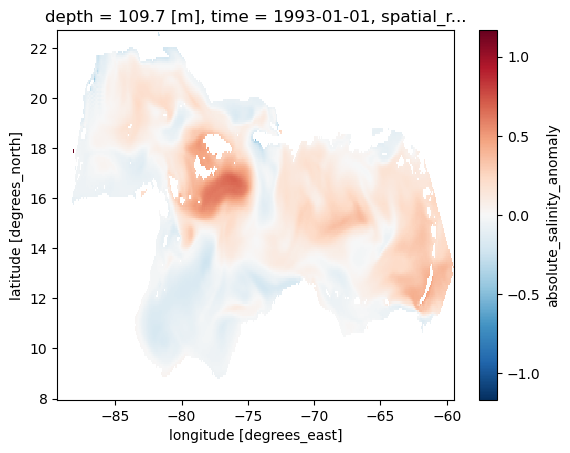

In [20]:
carib_ds.absolute_salinity_anomaly.isel(time=0,depth=22).plot()

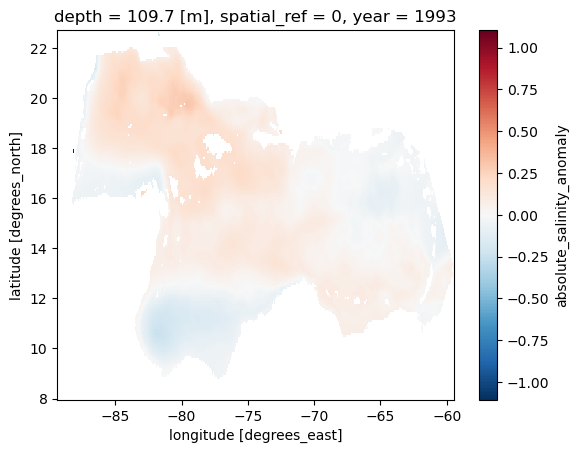

In [21]:
carib_ds.groupby(carib_ds.time.dt.year).mean().absolute_salinity_anomaly.isel(year=0,depth=22).plot()

## EOF

Look at different periods (yearly, all time, etc.)

In [22]:
yearly_mean_ds = carib_ds.groupby(carib_ds.time.dt.year).mean().rename({'year': 'time'})
monthly_mean_ds = carib_ds.groupby(carib_ds.time.dt.month).mean().rename({'month': 'time'})

## Monthly Mean Salinity Anomaly EOF

In [ ]:
# %%time

# for x in np.arange(0,33):
#     # Calculate the EOFs for the current depth level
#     solver = Eof(monthly_mean_ds.absolute_salinity_anomaly.isel(depth=x))
#     # Get the leading EOF
#     eof1 = solver.eofs(neofs=1)
#     # Get the corresponding principal component (PC)
#     pc1 = solver.pcs(npcs=1)
#     # Variance explained by the leading mode
#     variance_fraction = solver.varianceFraction(neigs=1)

#     ##################################################################################################################################
#     ### Automatically choose bounds for a colorbar that places the 0 point on the 'RdBu' scale at the white transition in the middle
#     field_max = np.nanmax(eof1.isel(mode=0))
#     field_min = np.nanmin(eof1.isel(mode=0))
    
#     if field_max>np.abs(field_min):
#         cbar_max = field_max
#         cbar_min = -field_max
#     elif field_max<np.abs(field_min):
#         cbar_max = -field_min
#         cbar_min = field_min
#     ##################################################################################################################################
    
    
#     fig, ax = plt.subplots(figsize=(14, 8), subplot_kw=dict(projection=cartopy.crs.PlateCarree()))
#     d = ax.pcolormesh(eof1.x,eof1.y,eof1.isel(mode=0),cmap='RdBu_r',vmin=cbar_min,vmax=cbar_max)
#     plt.colorbar(d, label='EOF',fraction=0.024)
#     ax.set_title(f'Monthly Mean Absolute Salinity Anomaly at Depth: {np.round(carib_ds.depth.values[x],0)} m\nMode 1 Variance Explained: {np.round(int(variance_fraction.values*100),1)}%')
#     ax.coastlines(linewidth=1.0,zorder=10)
#     ax.add_feature(cartopy.feature.LAND,zorder=10)
#     gl = ax.gridlines(draw_labels=True, linestyle='--', color='gray')
#     gl.top_labels = False
#     gl.right_labels = False
    
#     save_fname = ''.join(['/Users/joegradone/SynologyDrive/Drive/Rutgers/Research/figures/Python/Model/GLORYS/salinity_monthly_eof_maps/Mean_GLORYS_Carib_Monthly_Salinity_EOF',str(int(carib_ds.depth[x].values)),'_m_depth.png'])
#     plt.savefig(save_fname, bbox_inches='tight',dpi=300,facecolor='white')
#     plt.close()

    

## Monthly Mean Temperature Anomaly EOF

In [ ]:
# %%time

# for x in np.arange(0,33):
#     # Calculate the EOFs for the current depth level
#     solver = Eof(monthly_mean_ds.conservative_temperature_anomaly.isel(depth=x))
#     # Get the leading EOF
#     eof1 = solver.eofs(neofs=1)
#     # Get the corresponding principal component (PC)
#     pc1 = solver.pcs(npcs=1)
#     # Variance explained by the leading mode
#     variance_fraction = solver.varianceFraction(neigs=1)

#     ##################################################################################################################################
#     ### Automatically choose bounds for a colorbar that places the 0 point on the 'RdBu' scale at the white transition in the middle
#     field_max = np.nanmax(eof1.isel(mode=0))
#     field_min = np.nanmin(eof1.isel(mode=0))
    
#     if field_max>np.abs(field_min):
#         cbar_max = field_max
#         cbar_min = -field_max
#     elif field_max<np.abs(field_min):
#         cbar_max = -field_min
#         cbar_min = field_min
#     ##################################################################################################################################
    
    
#     fig, ax = plt.subplots(figsize=(14, 8), subplot_kw=dict(projection=cartopy.crs.PlateCarree()))
#     d = ax.pcolormesh(eof1.x,eof1.y,eof1.isel(mode=0),cmap='RdBu_r',vmin=cbar_min,vmax=cbar_max)
#     plt.colorbar(d, label='EOF',fraction=0.024)
#     ax.set_title(f'Monthly Mean Conservative Temperature Anomaly at Depth: {np.round(carib_ds.depth.values[x],0)} m\nMode 1 Variance Explained: {np.round(int(variance_fraction.values*100),1)}%')
#     ax.coastlines(linewidth=1.0,zorder=10)
#     ax.add_feature(cartopy.feature.LAND,zorder=10)
#     gl = ax.gridlines(draw_labels=True, linestyle='--', color='gray')
#     gl.top_labels = False
#     gl.right_labels = False
    
#     save_fname = ''.join(['/Users/joegradone/SynologyDrive/Drive/Rutgers/Research/figures/Python/Model/GLORYS/temperature_monthly_eof_maps/Mean_GLORYS_Carib_Monthly_Temperature_EOF',str(int(carib_ds.depth[x].values)),'_m_depth.png'])
#     plt.savefig(save_fname, bbox_inches='tight',dpi=300,facecolor='white')
#     plt.close()

    

## Yearly Mean Salinity Anomaly EOF

In [24]:
%%time

for x in np.arange(0,33):
    # Calculate the EOFs for the current depth level
    solver = Eof(yearly_mean_ds.absolute_salinity_anomaly.isel(depth=x))
    # Get the leading EOF
    eof1 = solver.eofs(neofs=1)
    # Get the corresponding principal component (PC)
    pc1 = solver.pcs(npcs=1)
    # Variance explained by the leading mode
    variance_fraction = solver.varianceFraction(neigs=1)

    ##################################################################################################################################
    ### Automatically choose bounds for a colorbar that places the 0 point on the 'RdBu' scale at the white transition in the middle
    field_max = np.nanmax(eof1.isel(mode=0))
    field_min = np.nanmin(eof1.isel(mode=0))
    
    if field_max>np.abs(field_min):
        cbar_max = field_max
        cbar_min = -field_max
    elif field_max<np.abs(field_min):
        cbar_max = -field_min
        cbar_min = field_min
    ##################################################################################################################################
    
    
    fig, ax = plt.subplots(figsize=(14, 8), subplot_kw=dict(projection=cartopy.crs.PlateCarree()))
    d = ax.pcolormesh(eof1.x,eof1.y,eof1.isel(mode=0),cmap='RdBu_r',vmin=cbar_min,vmax=cbar_max)
    plt.colorbar(d, label='EOF',fraction=0.024)
    ax.set_title(f'Yearly Mean Absolute Salinity Anomaly at Depth: {np.round(carib_ds.depth.values[x],0)} m\nMode 1 Variance Explained: {np.round(int(variance_fraction.values*100),1)}%')
    ax.coastlines(linewidth=1.0,zorder=10)
    ax.add_feature(cartopy.feature.LAND,zorder=10)
    gl = ax.gridlines(draw_labels=True, linestyle='--', color='gray')
    gl.top_labels = False
    gl.right_labels = False
    
    save_fname = ''.join(['/Users/joegradone/SynologyDrive/Drive/Rutgers/Research/figures/Python/Model/GLORYS/salinity_yearly_eof_maps/Mean_GLORYS_Carib_yearly_Salinity_EOF',str(int(carib_ds.depth[x].values)),'_m_depth.png'])
    plt.savefig(save_fname, bbox_inches='tight',dpi=300,facecolor='white')
    plt.close()

    

<timed exec>:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
<timed exec>:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
<timed exec>:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
<timed exec>:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
<timed exec>:28: DeprecationWarning: Conversion 

CPU times: user 6h 37min 18s, sys: 56min 2s, total: 7h 33min 20s
Wall time: 50min 44s


In [25]:
%%time

for x in np.arange(0,33):
    # Calculate the EOFs for the current depth level
    solver = Eof(yearly_mean_ds.conservative_temperature_anomaly.isel(depth=x))
    # Get the leading EOF
    eof1 = solver.eofs(neofs=1)
    # Get the corresponding principal component (PC)
    pc1 = solver.pcs(npcs=1)
    # Variance explained by the leading mode
    variance_fraction = solver.varianceFraction(neigs=1)

    ##################################################################################################################################
    ### Automatically choose bounds for a colorbar that places the 0 point on the 'RdBu' scale at the white transition in the middle
    field_max = np.nanmax(eof1.isel(mode=0))
    field_min = np.nanmin(eof1.isel(mode=0))
    
    if field_max>np.abs(field_min):
        cbar_max = field_max
        cbar_min = -field_max
    elif field_max<np.abs(field_min):
        cbar_max = -field_min
        cbar_min = field_min
    ##################################################################################################################################
    
    
    fig, ax = plt.subplots(figsize=(14, 8), subplot_kw=dict(projection=cartopy.crs.PlateCarree()))
    d = ax.pcolormesh(eof1.x,eof1.y,eof1.isel(mode=0),cmap='RdBu_r',vmin=cbar_min,vmax=cbar_max)
    plt.colorbar(d, label='EOF',fraction=0.024)
    ax.set_title(f'Yearly Mean Conservative Temperature Anomaly at Depth: {np.round(carib_ds.depth.values[x],0)} m\nMode 1 Variance Explained: {np.round(int(variance_fraction.values*100),1)}%')
    ax.coastlines(linewidth=1.0,zorder=10)
    ax.add_feature(cartopy.feature.LAND,zorder=10)
    gl = ax.gridlines(draw_labels=True, linestyle='--', color='gray')
    gl.top_labels = False
    gl.right_labels = False
    
    save_fname = ''.join(['/Users/joegradone/SynologyDrive/Drive/Rutgers/Research/figures/Python/Model/GLORYS/temperature_yearly_eof_maps/Mean_GLORYS_Carib_yearly_temperature_EOF',str(int(carib_ds.depth[x].values)),'_m_depth.png'])
    plt.savefig(save_fname, bbox_inches='tight',dpi=300,facecolor='white')
    plt.close()

    

<timed exec>:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
<timed exec>:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
<timed exec>:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
<timed exec>:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
<timed exec>:28: DeprecationWarning: Conversion 

CPU times: user 3h 29min 20s, sys: 1h 10min 30s, total: 4h 39min 51s
Wall time: 44min 1s


## Power spectral density

In [484]:
# Function to compute the power spectral density for each time series
def compute_psd(data, fs=1.0):
    freqs, psd = welch(data, fs=fs, nperseg=len(data)//2)
    return freqs, psd

# Choose a specific depth and location for analysis
depth_level = 0  # Index of the depth level
lat_idx = 100  # Index of the latitude (choose central point for simplicity)
lon_idx = 45  # Index of the longitude (choose central point for simplicity)

# Extract the time series for the chosen depth and location
temp_time_series = carib_ds.conservative_temperature_anomaly.isel(depth=depth_level, y=lat_idx, x=lon_idx).values

# Compute the power spectral density
freqs, psd = compute_psd(temp_time_series)

# Identify the dominant period (inverse of the dominant frequency)
dominant_freq = freqs[np.argmax(psd)]
dominant_period = 1 / dominant_freq ### Units of [months]


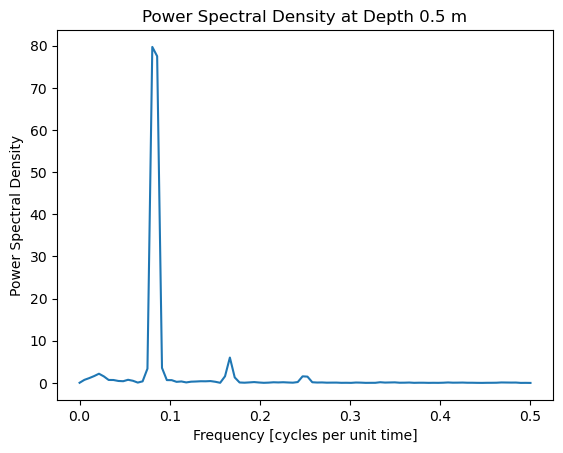

In [490]:
plt.plot(freqs, psd)
plt.xlabel('Frequency [cycles per unit time]')
plt.ylabel('Power Spectral Density')
plt.title(f'Power Spectral Density at Depth {np.round(carib_ds.depth.values[depth_level],1)} m')
plt.show()


In [542]:

def compute_psd_total(data, fs=1.0):
    freqs, psd = welch(data, fs=fs), nperseg=len(data)//2)
    dominant_freq = freqs[np.argmax(psd)]
    dominant_period = 1 / dominant_freq ### Units of [months]
    return dominant_period


carib_ds = carib_ds.chunk(dict(depth=-1))


# Apply the function using xarray's apply_ufunc
psd_temp_anom = xr.apply_ufunc(
    compute_psd_total,  # function to apply
    carib_ds.conservative_temperature_anomaly,         # input array
    input_core_dims=[['time']],  # core dimensions for input arrays
    output_core_dims=[[]],            # core dimensions for output array
    vectorize=True,                          # vectorize the function
    dask='parallelized',                     # enable parallel computation with dask
    output_dtypes=[carib_ds.conservative_temperature_anomaly.dtype]      # output dtype
)




# Apply the function using xarray's apply_ufunc
psd_salt_anom = xr.apply_ufunc(
    compute_psd_total,  # function to apply
    carib_ds.absolute_salinity_anomaly,         # input array
    input_core_dims=[['time']],  # core dimensions for input arrays
    output_core_dims=[[]],            # core dimensions for output array
    vectorize=True,                          # vectorize the function
    dask='parallelized',                     # enable parallel computation with dask
    output_dtypes=[carib_ds.conservative_temperature_anomaly.dtype]      # output dtype
)



# Apply the function using xarray's apply_ufunc
psd_salt = xr.apply_ufunc(
    compute_psd_total,  # function to apply
    carib_ds.absolute_salinity,         # input array
    input_core_dims=[['time']],  # core dimensions for input arrays
    output_core_dims=[[]],            # core dimensions for output array
    vectorize=True,                          # vectorize the function
    dask='parallelized',                     # enable parallel computation with dask
    output_dtypes=[carib_ds.conservative_temperature_anomaly.dtype]      # output dtype
)




# Apply the function using xarray's apply_ufunc
psd_temp = xr.apply_ufunc(
    compute_psd_total,  # function to apply
    carib_ds.conservative_temperature,         # input array
    input_core_dims=[['time']],  # core dimensions for input arrays
    output_core_dims=[[]],            # core dimensions for output array
    vectorize=True,                          # vectorize the function
    dask='parallelized',                     # enable parallel computation with dask
    output_dtypes=[carib_ds.conservative_temperature_anomaly.dtype]      # output dtype
)




In [548]:
# %%time
# psd_temp_anom.to_netcdf('/Users/joegradone/SynologyDrive/Drive/Rutgers/Research/data/GLORYS/PSD/GLORYS_1993_2023_CT_ANOM_PSD.nc')

In [549]:
# %%time
# psd_salt_anom.to_netcdf('/Users/joegradone/SynologyDrive/Drive/Rutgers/Research/data/GLORYS/PSD/GLORYS_1993_2023_AS_ANOM_PSD.nc')

In [550]:
# %%time
# psd_salt.to_netcdf('/Users/joegradone/SynologyDrive/Drive/Rutgers/Research/data/GLORYS/PSD/GLORYS_1993_2023_AS_PSD.nc')

In [551]:
# %%time
# psd_temp.to_netcdf('/Users/joegradone/SynologyDrive/Drive/Rutgers/Research/data/GLORYS/PSD/GLORYS_1993_2023_CT_PSD.nc')

In [552]:
psd_temp_anom = xr.open_dataset('/Users/joegradone/SynologyDrive/Drive/Rutgers/Research/data/GLORYS/PSD/GLORYS_1993_2023_CT_ANOM_PSD.nc')
psd_salt_anom = xr.open_dataset('/Users/joegradone/SynologyDrive/Drive/Rutgers/Research/data/GLORYS/PSD/GLORYS_1993_2023_AS_ANOM_PSD.nc')
psd_salt = xr.open_dataset('/Users/joegradone/SynologyDrive/Drive/Rutgers/Research/data/GLORYS/PSD/GLORYS_1993_2023_AS_PSD.nc')
psd_temp = xr.open_dataset('/Users/joegradone/SynologyDrive/Drive/Rutgers/Research/data/GLORYS/PSD/GLORYS_1993_2023_CT_PSD.nc')
psd_temp_anom

<xarray.Dataset>
Dimensions:                           (depth: 50, y: 177, x: 359)
Coordinates:
  * depth                             (depth) float32 0.494 1.541 ... 5.728e+03
  * y                                 (y) float32 8.0 8.083 ... 22.58 22.67
  * x                                 (x) float32 -89.33 -89.25 ... -59.58 -59.5
    spatial_ref                       int64 ...
Data variables:
    conservative_temperature_anomaly  (depth, y, x) float64 ...

In [565]:


for x in np.arange(0,len(carib_ds.depth)):
    fig, ax = plt.subplots(figsize=(14, 8), subplot_kw=dict(projection=cartopy.crs.PlateCarree()))
    d = ax.pcolormesh(psd_salt_anom.x,psd_salt_anom.y,psd_salt_anom.absolute_salinity_anomaly.isel(depth=x)/12)
    plt.colorbar(d, label='Dominant Period of Variability [Years]',fraction=0.024)
    ax.set_title(f'Absolute Salinity Anomaly, Depth: {np.round(psd_salt_anom.depth.values[x],1)} m')
    ax.coastlines(linewidth=1.0,zorder=10)
    ax.add_feature(cartopy.feature.LAND,zorder=10)
    gl = ax.gridlines(draw_labels=True, linestyle='--', color='gray')
    gl.top_labels = False
    gl.right_labels = False
    
    save_fname = ''.join(['/Users/joegradone/SynologyDrive/Drive/Rutgers/Research/figures/Python/Model/GLORYS/salinity_psd_maps/Mean_GLORYS_Carib_Salinity_PSD_',str(int(carib_ds.depth[x].values)),'_m_depth.png'])
    plt.savefig(save_fname, bbox_inches='tight',dpi=300,facecolor='white')
    plt.close()  # Close the figure to avoid displaying it
    


In [566]:

for x in np.arange(0,len(carib_ds.depth)):
    fig, ax = plt.subplots(figsize=(14, 8), subplot_kw=dict(projection=cartopy.crs.PlateCarree()))
    d = ax.pcolormesh(psd_temp_anom.x,psd_temp_anom.y,psd_temp_anom.conservative_temperature_anomaly.isel(depth=x)/12)
    plt.colorbar(d, label='Dominant Period of Variability [Years]',fraction=0.024)
    ax.set_title(f'Consevative Temperature Anomaly, Depth: {np.round(psd_temp_anom.depth.values[x],1)} m')
    ax.coastlines(linewidth=1.0,zorder=10)
    ax.add_feature(cartopy.feature.LAND,zorder=10)
    gl = ax.gridlines(draw_labels=True, linestyle='--', color='gray')
    gl.top_labels = False
    gl.right_labels = False
    
    save_fname = ''.join(['/Users/joegradone/SynologyDrive/Drive/Rutgers/Research/figures/Python/Model/GLORYS/temp_psd_maps/Mean_GLORYS_Carib_Temperature_PSD_',str(int(carib_ds.depth[x].values)),'_m_depth.png'])
    plt.savefig(save_fname, bbox_inches='tight',dpi=300,facecolor='white')
    plt.close()  # Close the figure to avoid displaying it
    


# Calculate KE metrics


In [15]:
rho = 1 # kg/m^3

#########################################################################################
## Time Mean
KE = (0.5*rho)*(((carib_ds.uvel**2)+((carib_ds.vvel**2))).mean(dim='time'))

MKE = (0.5*rho)*((carib_ds.uvel.mean(dim='time')**2)+(carib_ds.vvel.mean(dim='time')**2))

u_anom = carib_ds.uvel-carib_ds.uvel.mean(dim='time')
v_anom = carib_ds.vvel-carib_ds.vvel.mean(dim='time')

EKE = (0.5*rho)*((u_anom**2)+(v_anom**2)).mean(dim='time')
#########################################################################################


#########################################################################################
## On the monthly mean data
ke = (0.5*rho)*((carib_ds.uvel**2)+((carib_ds.vvel**2)))

u_anom = carib_ds.uvel-carib_ds.uvel.mean(dim='time')
v_anom = carib_ds.vvel-carib_ds.vvel.mean(dim='time')

eke = (0.5*rho)*((u_anom**2)+(v_anom**2))
#########################################################################################

#########################################################################################
## On the regional data
KE_east = (0.5*rho)*(((east_carib_ds.uvel**2)+((east_carib_ds.vvel**2))).mean(dim='time'))
KE_west = (0.5*rho)*(((west_carib_ds.uvel**2)+((west_carib_ds.vvel**2))).mean(dim='time'))
KE_central = (0.5*rho)*(((central_carib_ds.uvel**2)+((central_carib_ds.vvel**2))).mean(dim='time'))

MKE_east = (0.5*rho)*((east_carib_ds.uvel.mean(dim='time')**2)+(east_carib_ds.vvel.mean(dim='time')**2))
MKE_west = (0.5*rho)*((west_carib_ds.uvel.mean(dim='time')**2)+(west_carib_ds.vvel.mean(dim='time')**2))
MKE_central = (0.5*rho)*((central_carib_ds.uvel.mean(dim='time')**2)+(central_carib_ds.vvel.mean(dim='time')**2))

u_anom_east = east_carib_ds.uvel-east_carib_ds.uvel.mean(dim='time')
u_anom_west = west_carib_ds.uvel-west_carib_ds.uvel.mean(dim='time')
u_anom_central = central_carib_ds.uvel-central_carib_ds.uvel.mean(dim='time')

v_anom_east = east_carib_ds.vvel-east_carib_ds.vvel.mean(dim='time')
v_anom_west = west_carib_ds.vvel-west_carib_ds.vvel.mean(dim='time')
v_anom_central = central_carib_ds.vvel-central_carib_ds.vvel.mean(dim='time')

EKE_east = (0.5*rho)*((u_anom_east**2)+(u_anom_east**2)).mean(dim='time')
EKE_west = (0.5*rho)*((u_anom_west**2)+(u_anom_west**2)).mean(dim='time')
EKE_central = (0.5*rho)*((u_anom_central**2)+(u_anom_central**2)).mean(dim='time')


#########################################################################################
## On the regional, monthly mean data
ke_east = (0.5*rho)*((east_carib_ds.uvel**2)+(east_carib_ds.vvel**2))
ke_west = (0.5*rho)*((west_carib_ds.uvel**2)+(west_carib_ds.vvel**2))
ke_central = (0.5*rho)*((central_carib_ds.uvel**2)+(central_carib_ds.vvel**2))

u_anom_east = east_carib_ds.uvel-east_carib_ds.uvel.mean(dim='time')
u_anom_west = west_carib_ds.uvel-west_carib_ds.uvel.mean(dim='time')
u_anom_central = central_carib_ds.uvel-central_carib_ds.uvel.mean(dim='time')

v_anom_east = east_carib_ds.vvel-east_carib_ds.vvel.mean(dim='time')
v_anom_west = west_carib_ds.vvel-west_carib_ds.vvel.mean(dim='time')
v_anom_central = central_carib_ds.vvel-central_carib_ds.vvel.mean(dim='time')

eke_east = (0.5*rho)*((u_anom_east**2)+(u_anom_east**2))
eke_west = (0.5*rho)*((u_anom_west**2)+(u_anom_west**2))
eke_central = (0.5*rho)*((u_anom_central**2)+(u_anom_central**2))

/Users/joegradone/anaconda3/envs/rutgers-phd/lib/python3.11/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/Users/joegradone/anaconda3/envs/rutgers-phd/lib/python3.11/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


Text(0.5, 1.0, 'GLORYS 1993-2022 MKE: 0.5 meters')

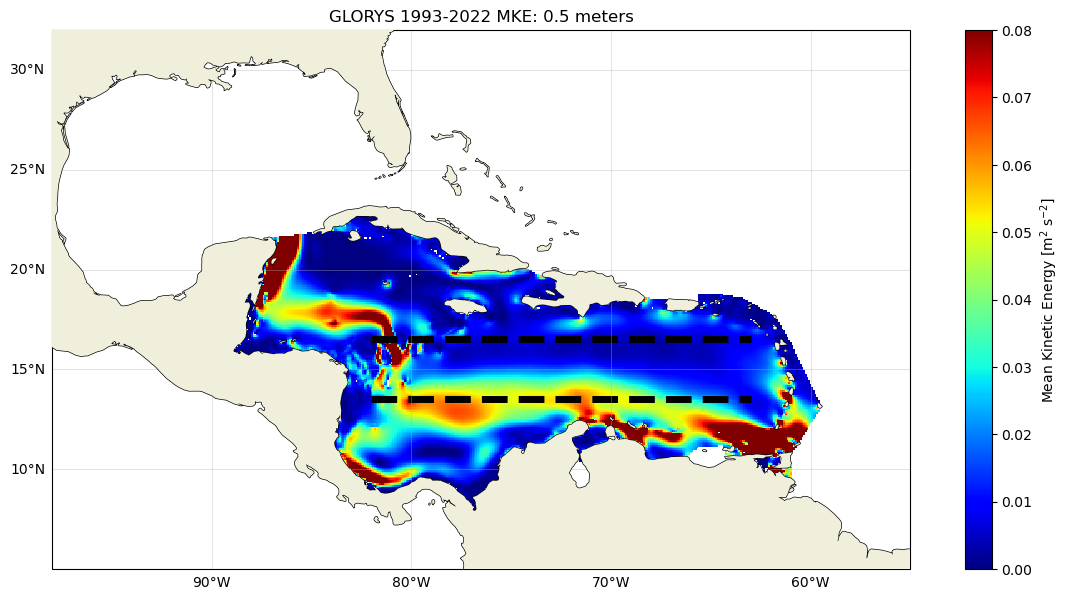

In [16]:
depth_ind = 0

fig, ax = plt.subplots(figsize=(14,7),subplot_kw=dict(projection=cartopy.crs.PlateCarree()))
im = ax.pcolormesh(MKE.x,MKE.y,MKE.isel(depth=depth_ind),transform =cartopy.crs.PlateCarree(),cmap=plt.cm.jet,vmin=0,vmax=0.08)
plt.colorbar(im, ax=ax,label='Mean Kinetic Energy [m$^{2}$ s$^{-2}$]')
#cs = plt.contour(lonmesh_carib,latmesh_carib,carib_ds.mld.mean(dim='time'),[30,40,50,60],colors='black',linewidth=5,transform =cartopy.crs.PlateCarree())
#plt.clabel(cs, inline=True, fontsize=10)

plt.plot([-82, -63], [16.5, 16.5],'k--', linewidth=5,transform=cartopy.crs.PlateCarree())
plt.plot([-82, -63], [13.5, 13.5],'k--', linewidth=5,transform=cartopy.crs.PlateCarree())

ax.coastlines(linewidth=1.0,zorder=10)
ax.add_feature(cartopy.feature.LAND,zorder=10)
glb = ax.gridlines(draw_labels=True, alpha=0.5, linewidth=.5 )
glb.xlabels_top = glb.ylabels_right = False
ax.set_ylim(5,32)
ax.set_xlim(-98,-55)
ax.set_title(f'GLORYS 1993-2022 MKE: {np.round(MKE.depth[depth_ind].values,1)} meters', fontsize=font_size)


/Users/joegradone/anaconda3/envs/rutgers-phd/lib/python3.11/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/Users/joegradone/anaconda3/envs/rutgers-phd/lib/python3.11/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


Text(0.5, 1.0, 'GLORYS 1993-2022 MKE: 131.0 meters')

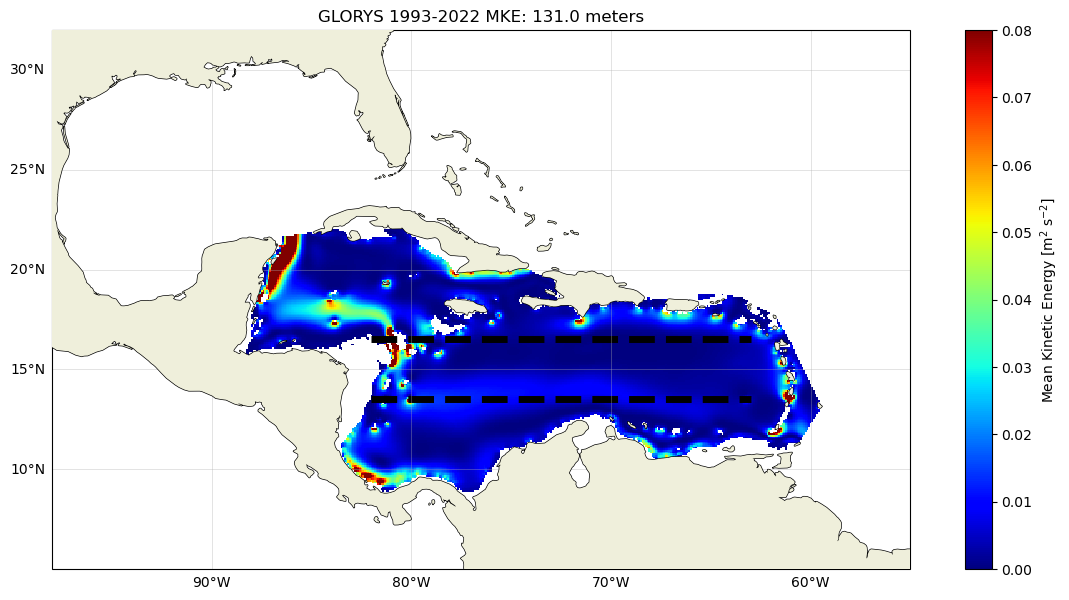

In [17]:
depth_ind = 23

fig, ax = plt.subplots(figsize=(14,7),subplot_kw=dict(projection=cartopy.crs.PlateCarree()))
im = ax.pcolormesh(MKE.x,MKE.y,MKE.isel(depth=depth_ind),transform =cartopy.crs.PlateCarree(),cmap=plt.cm.jet,vmin=0,vmax=0.08)
plt.colorbar(im, ax=ax,label='Mean Kinetic Energy [m$^{2}$ s$^{-2}$]')
#cs = plt.contour(lonmesh_carib,latmesh_carib,carib_ds.mld.mean(dim='time'),[30,40,50,60],colors='black',linewidth=5,transform =cartopy.crs.PlateCarree())
#plt.clabel(cs, inline=True, fontsize=10)

plt.plot([-82, -63], [16.5, 16.5],'k--', linewidth=5,transform=cartopy.crs.PlateCarree())
plt.plot([-82, -63], [13.5, 13.5],'k--', linewidth=5,transform=cartopy.crs.PlateCarree())

ax.coastlines(linewidth=1.0,zorder=10)
ax.add_feature(cartopy.feature.LAND,zorder=10)
glb = ax.gridlines(draw_labels=True, alpha=0.5, linewidth=.5 )
glb.xlabels_top = glb.ylabels_right = False
ax.set_ylim(5,32)
ax.set_xlim(-98,-55)
ax.set_title(f'GLORYS 1993-2022 MKE: {np.round(MKE.depth[depth_ind].values,0)} meters', fontsize=font_size)


/Users/joegradone/anaconda3/envs/rutgers-phd/lib/python3.11/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/Users/joegradone/anaconda3/envs/rutgers-phd/lib/python3.11/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


Text(0.5, 1.0, 'GLORYS 1993-2022 EKE: 0.5 meters')

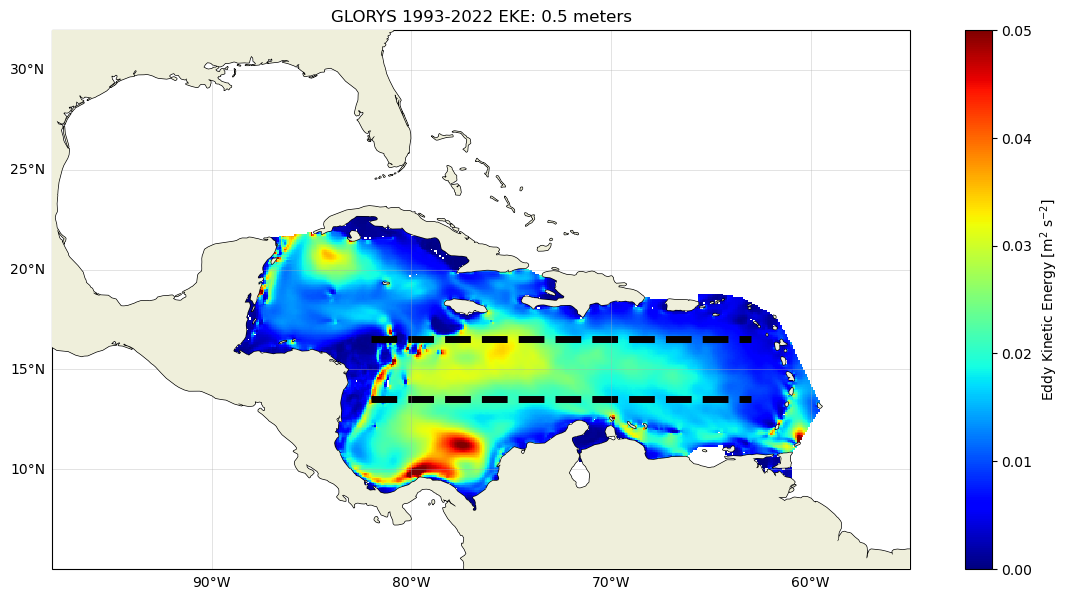

In [18]:
depth_ind = 0

fig, ax = plt.subplots(figsize=(14,7),subplot_kw=dict(projection=cartopy.crs.PlateCarree()))
im = ax.pcolormesh(EKE.x,EKE.y,EKE.isel(depth=depth_ind),transform =cartopy.crs.PlateCarree(),cmap=plt.cm.jet,vmin=0,vmax=0.05)
plt.colorbar(im, ax=ax,label='Eddy Kinetic Energy [m$^{2}$ s$^{-2}$]')

plt.plot([-82, -63], [16.5, 16.5],'k--', linewidth=5,transform=cartopy.crs.PlateCarree())
plt.plot([-82, -63], [13.5, 13.5],'k--', linewidth=5,transform=cartopy.crs.PlateCarree())

ax.coastlines(linewidth=1.0,zorder=10)
ax.add_feature(cartopy.feature.LAND,zorder=10)
glb = ax.gridlines(draw_labels=True, alpha=0.5, linewidth=.5 )
glb.xlabels_top = glb.ylabels_right = False
ax.set_ylim(5,32)
ax.set_xlim(-98,-55)
ax.set_title(f'GLORYS 1993-2022 EKE: {np.round(EKE.depth[depth_ind].values,1)} meters', fontsize=font_size)


/Users/joegradone/anaconda3/envs/rutgers-phd/lib/python3.11/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/Users/joegradone/anaconda3/envs/rutgers-phd/lib/python3.11/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


Text(0.5, 1.0, 'GLORYS 1993-2022 EKE: 131.0 meters')

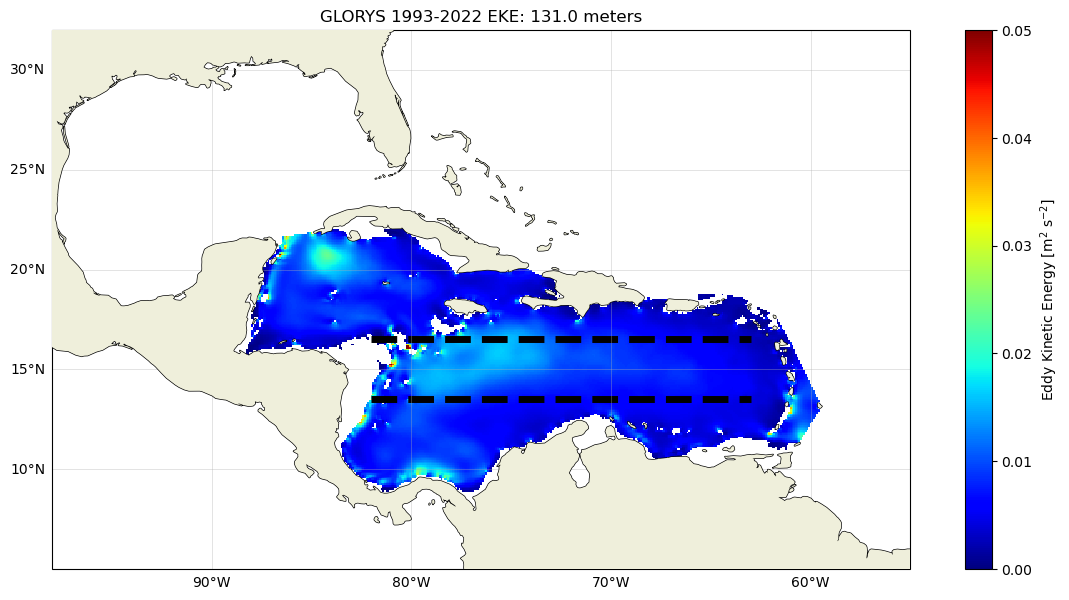

In [19]:
depth_ind = 23

fig, ax = plt.subplots(figsize=(14,7),subplot_kw=dict(projection=cartopy.crs.PlateCarree()))
im = ax.pcolormesh(EKE.x,EKE.y,EKE.isel(depth=depth_ind),transform =cartopy.crs.PlateCarree(),cmap=plt.cm.jet,vmin=0,vmax=0.05)
plt.colorbar(im, ax=ax,label='Eddy Kinetic Energy [m$^{2}$ s$^{-2}$]')


plt.plot([-82, -63], [16.5, 16.5],'k--', linewidth=5,transform=cartopy.crs.PlateCarree())
plt.plot([-82, -63], [13.5, 13.5],'k--', linewidth=5,transform=cartopy.crs.PlateCarree())

ax.coastlines(linewidth=1.0,zorder=10)
ax.add_feature(cartopy.feature.LAND,zorder=10)
glb = ax.gridlines(draw_labels=True, alpha=0.5, linewidth=.5 )
glb.xlabels_top = glb.ylabels_right = False
ax.set_ylim(5,32)
ax.set_xlim(-98,-55)
ax.set_title(f'GLORYS 1993-2022 EKE: {np.round(EKE.depth[depth_ind].values,0)} meters', fontsize=font_size)


(750.0, 0.0)

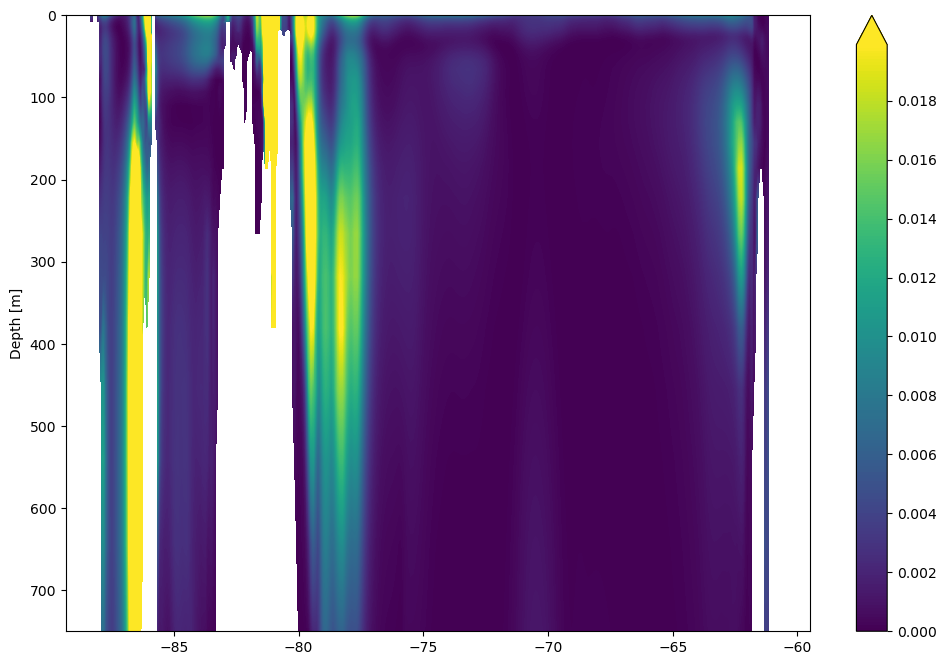

In [20]:
plt.figure(figsize=(12,8))
plt.contourf(MKE.x,MKE.depth,MKE.isel(y=102),levels=np.arange(0,0.02,0.0001),extend='max')
plt.ylabel('Depth [m]')
plt.colorbar()
plt.ylim(750,0)

Text(0.5, 0, 'Kinetic Energy [m$^{2}$ s$^{-2}$]')

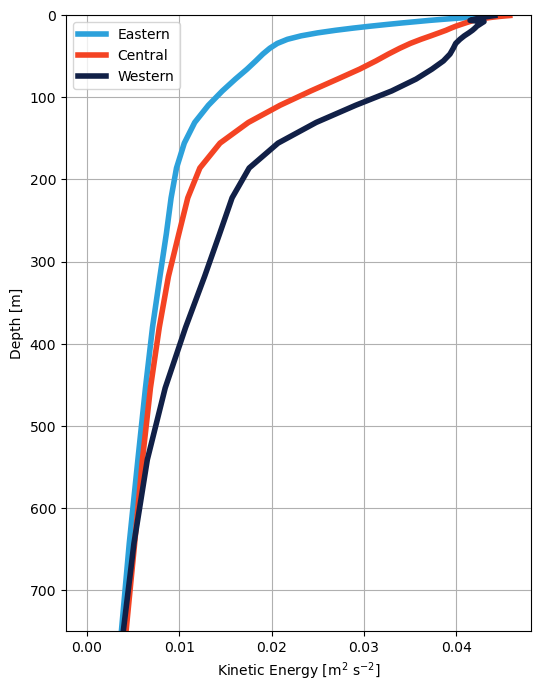

In [21]:
lwd = 4
plt.figure(figsize=(6,8))
plt.plot(KE_east.mean(dim=['x','y']),KE_east.depth,color=ec_col,linewidth=lwd,label='Eastern')
plt.plot(KE_central.mean(dim=['x','y']),KE_central.depth,color=cc_col,linewidth=lwd,label='Central')
plt.plot(KE_west.mean(dim=['x','y']),KE_west.depth,color=wc_col,linewidth=lwd,label='Western')
plt.ylim(750,0)
plt.grid()
plt.legend()
plt.ylabel('Depth [m]')
plt.xlabel('Kinetic Energy [m$^{2}$ s$^{-2}$]')

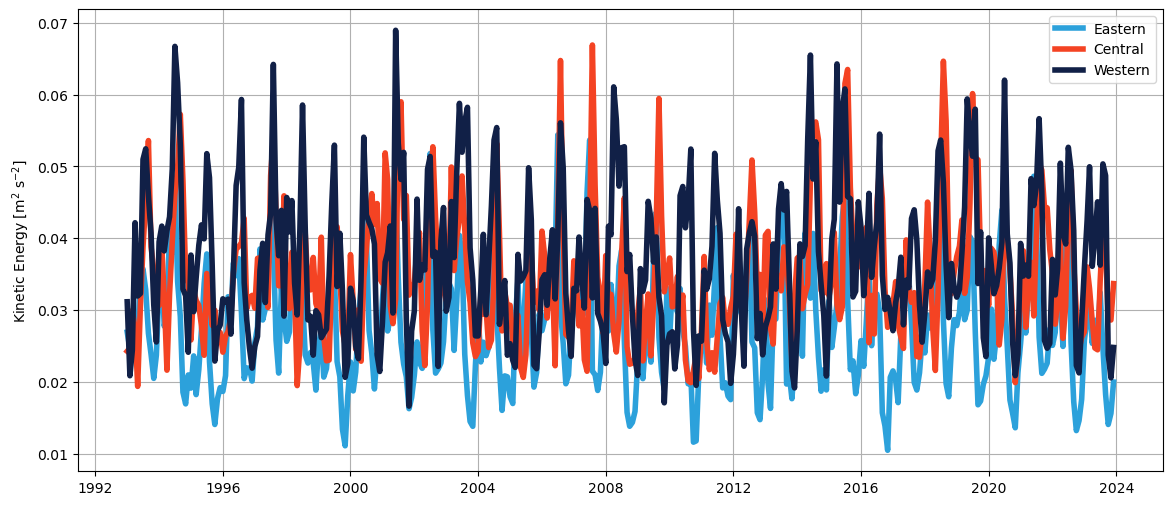

In [22]:
plt.figure(figsize=(14,6))
plt.plot(ke_east.time,ke_east.isel(depth=slice(0,25)).mean(dim='depth').mean(dim=['x','y']),color=ec_col,linewidth=lwd,label='Eastern')
plt.plot(ke_central.time,ke_central.isel(depth=slice(0,25)).mean(dim='depth').mean(dim=['x','y']),color=cc_col,linewidth=lwd,label='Central')
plt.plot(ke_west.time,ke_west.isel(depth=slice(0,25)).mean(dim='depth').mean(dim=['x','y']),color=wc_col,linewidth=lwd,label='Western')
plt.ylabel('Kinetic Energy [m$^{2}$ s$^{-2}$]')
plt.grid()
plt.legend()

## Compare with Nino 3.4

In [226]:
nino_path = path = '/Users/joegradone/Desktop/FADAD251AE924A27E8052B0E3C667438_ferret_listing.nc'

nino = xr.open_dataset(nino_path)
nino

<xarray.Dataset>
Dimensions:    (TIME: 300, bnds: 2)
Coordinates:
  * TIME       (TIME) datetime64[ns] 1993-01-15 1993-02-15 ... 2017-12-15
Dimensions without coordinates: bnds
Data variables:
    TIME_bnds  (TIME, bnds) datetime64[ns] ...
    NINO34     (TIME) float32 ...
Attributes:
    history:      FERRET V6.5   7-Jul-24
    Conventions:  CF-1.0

## Filter

In [227]:
n_months = 24 * 12  # 24 years of monthly data

# Define the low-pass filter
def butter_lowpass(cutoff, fs, order=5):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = filtfilt(b, a, data)
    return y

# Filter parameters
order = 2
fs = 12  # Sampling frequency (monthly data, so 12 samples per year)
cutoff = 1 / 2  # Desired cutoff frequency of the filter (2 years)

# Apply the filter
nino_filt = lowpass_filter(nino.NINO34.values, cutoff, fs, order)

ke_east_filt = lowpass_filter(ke_east.isel(depth=slice(0,25)).mean(dim='depth').mean(dim=['x','y']), cutoff, fs, order)
ke_central_filt = lowpass_filter(ke_central.isel(depth=slice(0,25)).mean(dim='depth').mean(dim=['x','y']), cutoff, fs, order)
ke_west_filt = lowpass_filter(ke_west.isel(depth=slice(0,25)).mean(dim='depth').mean(dim=['x','y']), cutoff, fs, order)

In [228]:
## subset to same time length as nino
ke_east_filt = ke_east_filt[0:300]
ke_central_filt = ke_central_filt[0:300]
ke_west_filt = ke_west_filt[0:300]


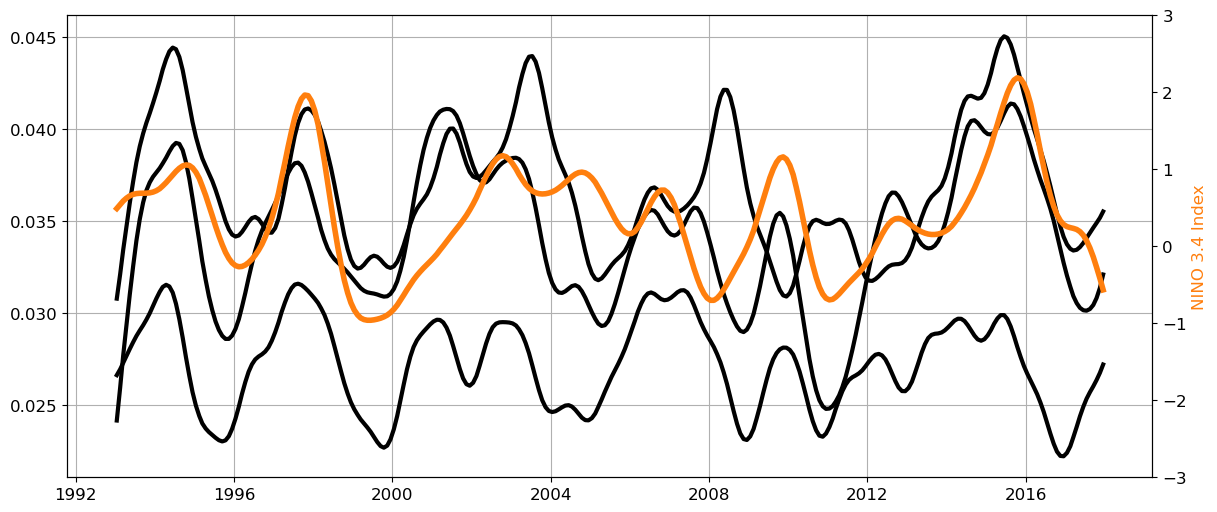

In [229]:
lwd = 4
font_size = 12


fig, ax1 = plt.subplots(figsize=(14, 6))
ax2 = ax1.twinx()

ax1.plot(nino.TIME,ke_east_filt,linewidth=3,color='black')
ax1.plot(nino.TIME,ke_central_filt,linewidth=3,color='black')
ax1.plot(nino.TIME,ke_west_filt,linewidth=3,color='black')

#ax1.legend(fontsize=font_size)
ax1.grid()
#ax1.set_ylabel('Transport Anomaly [Sv]',fontsize=font_size)
ax1.tick_params(axis='both', which='major', labelsize=font_size)

nino_color='tab:orange'
ax2.plot(nino.TIME,nino_filt,color=nino_color,linewidth=lwd)
ax2.set_ylabel('NINO 3.4 Index',fontsize=font_size,color=nino_color)
ax2.set_ylim(-3,3)
ax2.tick_params(axis='both', which='major', labelsize=font_size)



In [39]:
east_ke_cor, east_ke_p = scipy.stats.pearsonr(ke_east_filt,nino_filt)
west_ke_cor, west_ke_p = scipy.stats.pearsonr(ke_west_filt,nino_filt)
central_ke_cor, central_ke_p = scipy.stats.pearsonr(ke_central_filt,nino_filt)


In [40]:
east_ke_cor

0.11073444410984415

In [41]:
west_ke_cor

0.3011026277405293

In [42]:
central_ke_cor

0.19249489465409514

# Calculate volume transport

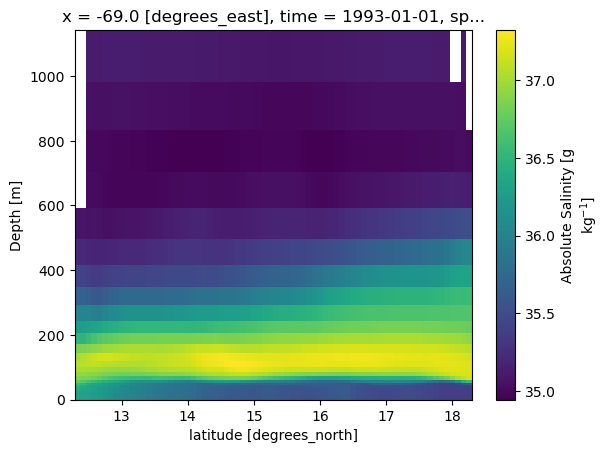

In [96]:
#central_ds = ds.isel(x=346,y=slice(0,360))

central_ds = carib_ds.isel(x=244,y=slice(52,124))

central_ds.absolute_salinity.isel(time=0).plot()

In [97]:
depth_grid = list(np.diff(carib_ds.depth.values))
depth_grid.insert(0,carib_ds.depth.values[0])
depth_grid = np.array(depth_grid)
depth_grid

array([  0.494025 ,   1.04735  ,   1.104294 ,   1.173826 ,   1.2587292,
         1.36239  ,   1.488946 ,   1.6434369,   1.8320026,   2.0621405,
         2.3429298,   2.6854897,   3.10326  ,   3.6125908,   4.23332  ,
         4.98942  ,   5.9099007,   7.02964  ,   8.390598 ,  10.042976 ,
        12.046585 ,  14.472221 ,  17.403229 ,  20.936699 ,  25.184692 ,
        30.274902 ,  36.34961  ,  43.56511  ,  52.087097 ,  62.0856   ,
        73.7247   ,  87.151215 , 102.477844 , 119.76636  , 139.00616  ,
       160.10065  ], dtype=float32)

In [98]:
#coords_1 = (yucatan_ds.y.values[0], yucatan_ds.x.values)
#coords_2 = (yucatan_ds.y.values[-1], yucatan_ds.x.values)

coords_1 = (central_ds.y.values[0], central_ds.x.values)
coords_2 = (central_ds.y.values[-1], central_ds.x.values)

## Distance in meters
dlat = geopy.distance.geodesic(coords_1, coords_2).m
dlat

654693.4168129356

In [99]:
dz = 1
grid_depth = np.arange(0.5, central_ds.depth.max().values, dz)

## This makes one mean velocity profile across the entire section
interp_func = interp1d(central_ds.depth.values, central_ds.uvel.mean(dim=['time','y']).values, kind='linear')
test_uvel = interp_func(grid_depth)

interp_func = interp1d(central_ds.depth.values, central_ds.absolute_salinity.mean(dim=['time','y']).values, kind='linear')
test_salinity = interp_func(grid_depth)


# uvel_interp = np.empty((len(grid_depth),len(yucatan_ds.y)))
# uvel_interp[:]  = np.nan

# for y in np.arange(0,len(yucatan_ds.y)):
#     # Create the interpolation function
#     interp_func = interp1d(yucatan_ds.depth.values, yucatan_ds.uvel.isel(time=50,y=y).values, kind='linear')

#     uvel_interp[:,y] = interp_func(grid_depth)


## NOW WITH REGULAR DZ THIS WORKS

In [100]:
np.sum(test_uvel*dz*dlat)/(10**6)

-20.14490865755873

In [101]:
transport_profile = (test_uvel*dz*dlat)/(10**6)

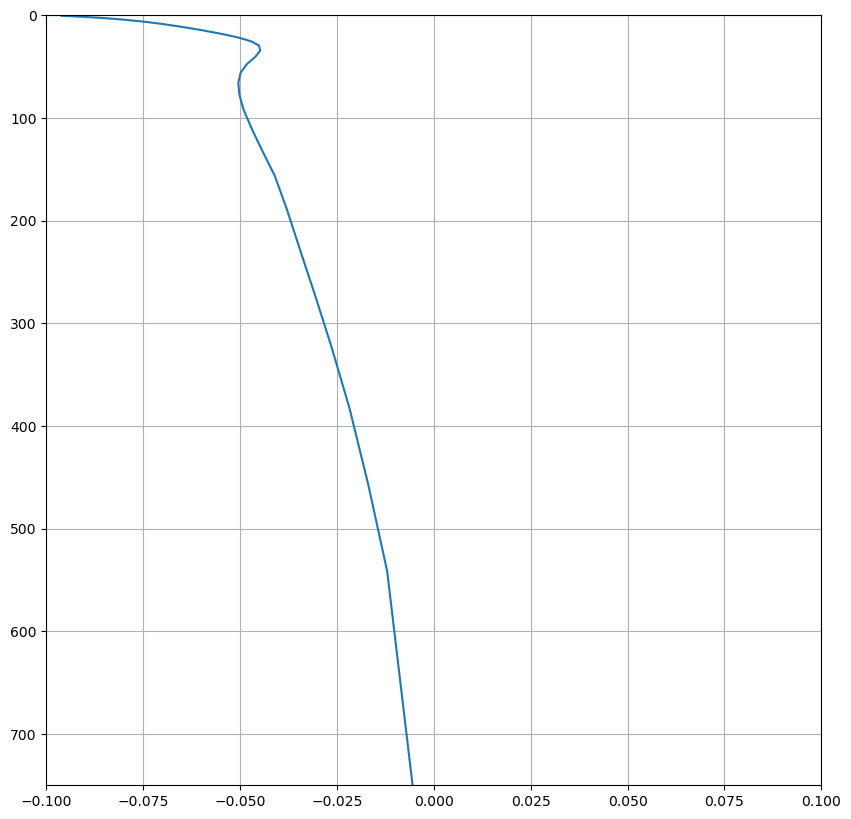

In [107]:
plt.figure(figsize=(10,10))
plt.plot(transport_profile,grid_depth)
plt.ylim(750,0)
plt.xlim(-0.1,0.1)
plt.grid()

## ~Half of the total transport is in the upper 200 m

In [103]:
np.nansum(transport_profile[0:200])

-9.50105180243246

In [104]:
np.nansum(transport_profile[200:])

-10.643856855126273

In [105]:
salt_transport = transport_profile*test_salinity*1025*(1/1000)

Text(0.5, 1.0, 'Central Caribbean 69W')

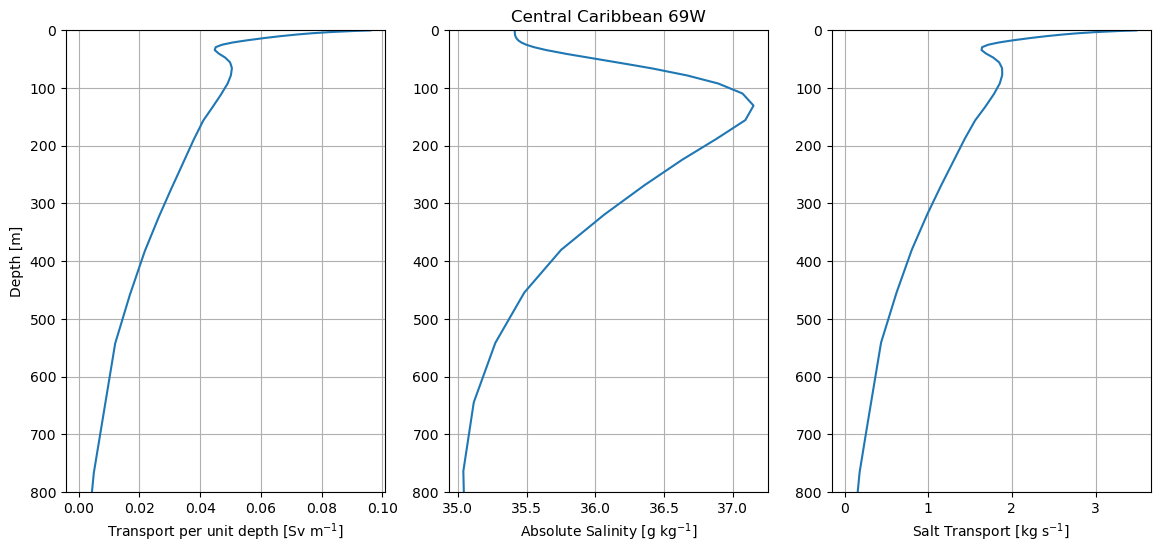

In [106]:
fig,ax = plt.subplots(1,3,figsize=(14,6))

ax[0].plot(-transport_profile,grid_depth)
ax[0].set_ylim(800,0)
ax[0].grid()
ax[0].set_ylabel('Depth [m]')
ax[0].set_xlabel('Transport per unit depth [Sv m$^{-1}$]')


ax[1].plot(test_salinity,grid_depth)
ax[1].set_ylim(800,0)
ax[1].grid()
ax[1].set_xlabel('Absolute Salinity [g kg$^{-1}$]')


ax[2].plot(-salt_transport,grid_depth)
ax[2].set_ylim(800,0)
ax[2].grid()
ax[2].set_xlabel('Salt Transport [kg s$^{-1}$]')

ax[1].set_title('Central Caribbean 69W')

In [ ]:
def plot_streamplot(lon, lat, u, v, fig, ax,
                    density=5, 
                    sites=None,
                    sname="streamplot.png",
                    title="Streamplot",
                    proj=ccrs.PlateCarree(),
                    levels=np.arange(0, 2.1, .1),
                    dpi=150,
                    legend_text=None):
    # # Check if isobaths are passed to argument inputs
    # if isobaths:
    #     fig, ax = cplt.create(extent, bathymetry=True, isobaths=isobaths, 
    #                           figsize=figsize)
    # else:
    #     fig, ax = cplt.create(extent, bathymetry=False, figsize=figsize)

    # if len(u)

    if sites:
        if not isinstance(sites, dict):
            print("Sites must be in the form of a dictionary in order to plot.")
            pass
        else:
            sh = []
            for key, values in sites.items():
                if values['type'] == 'RDLIdeal':
                    h = ax.plot(values['lon'], values['lat'], '^', color=values['color'], markeredgecolor='black', markersize=8, transform=proj, zorder=60)
                elif values['type'] == 'RDLMeasured':
                    h = ax.plot(values['lon'], values['lat'], 's', color=values['color'], markeredgecolor='black', markersize=8, transform=proj, zorder=60)
                elif values['type'] == 'Prospective':
                    h = ax.plot(values['lon'], values['lat'], 'o', color=values['color'],  markeredgecolor='black', markersize=8, transform=proj, zorder=60)
                sh.append(h[0])
                    
    # Convert u and v to angle and speed. We calculate speed to create a
    # colored contour map underneath the streamlines
    _, speed = uv2spdir(u, v)
    
    # Plot contour plot of speed
    h = ax.contourf(lon, lat, speed, 
                    cmap=cmocean.cm.speed,
                    transform=proj,
                    levels=levels, 
                    extend='max', zorder=10001)
    
    # Plot streamlines
    s = ax.streamplot(lon, lat, u, v, 
                      density=density, 
                      transform=proj, 
                      color='black', zorder=10001)
    
    # Add colorbar for contour plot
    cb = fig.colorbar(h)
    #cb.set_ticks(np.arange(0.0, 2.1, .2))
    # cb.set_ticklabels(['0.0', '', '.2','',  '.4', '', '.6', '',  '.8', '', '1.0', '', '1.2','',  '1.4', '', '1.6', '', '1.8', '', '2.0'])
    cb.ax.tick_params(labelsize=12)
    cb.set_label(f'Speed (m/s)', fontsize=12, fontweight="bold")
    #cb.ax.yaxis.set_minor_locator(AutoMinorLocator(n=2))
    
    # Add title
    ax.set_title(title, fontweight='bold', fontsize=14)
 
    # Save the figure
    fig.savefig(sname, facecolor='white',  bbox_inches="tight", pad_inches=0.1,
                dpi=dpi)
    
    # # Remove handles to reuse plot 
    # [x.remove() for x in h.collections] # Delete contour handles
    # s.lines.remove() # Delete streamlines
    # remove_quiver_handles(ax) # Delete streamline arrowheads
    # cb.remove() #Delete colorbar
    # # if legend_text:
    #     # at.remove()
    # # for h in sh:
    #     # h.remove()

def textonly(ax, txt, fontsize = 8, loc = 2):
    from matplotlib.offsetbox import AnchoredText
    at = AnchoredText(txt,
                      prop=dict(size=fontsize), 
                      frameon=True,
                      loc=loc)
    at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
    ax.add_artist(at)
    return at

def remove_quiver_handles(ax):
    for art in ax.get_children():
        if isinstance(art, matplotlib.patches.FancyArrowPatch):
            art.remove()

In [ ]:
import cartopy.feature as cfeature

fig, ax = plt.subplots(figsize=(14,7),subplot_kw=dict(projection=cartopy.crs.PlateCarree()))

ax.coastlines(linewidth=1.0,zorder=10)
ax.add_feature(cartopy.feature.LAND,zorder=10)
glb = ax.gridlines(draw_labels=True, alpha=0.5, linewidth=.5 )
glb.xlabels_top = glb.ylabels_right = False

#bds = cplt.get_bathymetry(extent)
#bh = cplt.add_bathymetry(ax, bds['longitude'], bds['latitude'], bds['z'], levels=(-1000, -100))
#levels = [-8000, -1000, -100, 0]
#colors = ['cornflowerblue', cfeature.COLORS['water'], 'lightsteelblue']
#cs = ax.contourf(bds['longitude'], bds['latitude'], bds['z'], levels, colors=colors, transform=ccrs.PlateCarree(), ticks=False)


depth_ind = 0

plot_streamplot(carib_ds.x, carib_ds.y, carib_ds.uvel.mean(dim='time').isel(depth=depth_ind), carib_ds.vvel.mean(dim='time').isel(depth=depth_ind), fig, ax,
                density=2,levels=np.arange(0,0.5,0.01),
                #title=title,
                # legend_text=legend_text_1,
                # sites=radial_sites,
                dpi=150,
                )


In [ ]:
import cartopy.feature as cfeature

fig, ax = plt.subplots(figsize=(14,7),subplot_kw=dict(projection=cartopy.crs.PlateCarree()))

ax.coastlines(linewidth=1.0,zorder=10)
ax.add_feature(cartopy.feature.LAND,zorder=10)
glb = ax.gridlines(draw_labels=True, alpha=0.5, linewidth=.5 )
glb.xlabels_top = glb.ylabels_right = False

depth_ind = 0
time_ind = 20

plot_streamplot(carib_ds.x, carib_ds.y, carib_ds.uvel.isel(time=time_ind,depth=depth_ind), carib_ds.vvel.isel(time=time_ind,depth=depth_ind), fig, ax,
                density=2,levels=np.arange(0,0.5,0.01),
                #title=title,
                # legend_text=legend_text_1,
                # sites=radial_sites,
                dpi=150,
                )


In [ ]:
plt.figure(figsize=(12,6))
ds.vo.isel(time=19,depth=0).plot()

In [ ]:
carib_ds

In [ ]:
plt.plot(np.gradient(central_ds.vvel.isel(time=0,y=10),depth_grid),carib_ds.depth)
plt.ylim(700,0)
plt.grid()

## Look at vertical shear
### Do it for total velocity and U/V

In [ ]:
_, tot_speed = uv2spdir(carib_ds.uvel, carib_ds.vvel)

In [ ]:
tot_speed = xr.DataArray(tot_speed, dims=['time','depth','y','x'], name='tot_speed')
carib_ds['tot_speed'] = tot_speed
carib_ds['tot_speed'] 

In [ ]:
carib_ds = carib_ds.chunk({'depth': -1})

# Define a function that applies np.gradient along the depth dimension
def gradient_along_depth(uvel, depth_grid):
    return np.gradient(uvel, depth_grid, axis=0)  # axis=0 assumes depth is the first dimension in uvel

# Apply the function using xarray's apply_ufunc
dudz = xr.apply_ufunc(
    gradient_along_depth,  # function to apply
    carib_ds.uvel,         # input array
    depth_grid,            # additional argument to pass to the function
    input_core_dims=[['depth'], ['depth']],  # core dimensions for input arrays
    output_core_dims=[['depth']],            # core dimensions for output array
    vectorize=True,                          # vectorize the function
    dask='parallelized',                     # enable parallel computation with dask
    output_dtypes=[carib_ds.uvel.dtype]      # output dtype
)

# Assign the computed gradient back to the dataset
carib_ds['dudz'] = dudz


# Apply the function using xarray's apply_ufunc
dvdz = xr.apply_ufunc(
    gradient_along_depth,  # function to apply
    carib_ds.vvel,         # input array
    depth_grid,            # additional argument to pass to the function
    input_core_dims=[['depth'], ['depth']],  # core dimensions for input arrays
    output_core_dims=[['depth']],            # core dimensions for output array
    vectorize=True,                          # vectorize the function
    dask='parallelized',                     # enable parallel computation with dask
    output_dtypes=[carib_ds.uvel.dtype]      # output dtype
)

# Assign the computed gradient back to the dataset
carib_ds['dvdz'] = dvdz


# Apply the function using xarray's apply_ufunc
dUdz = xr.apply_ufunc(
    gradient_along_depth,  # function to apply
    carib_ds.tot_speed,         # input array
    depth_grid,            # additional argument to pass to the function
    input_core_dims=[['depth'], ['depth']],  # core dimensions for input arrays
    output_core_dims=[['depth']],            # core dimensions for output array
    vectorize=True,                          # vectorize the function
    dask='parallelized',                     # enable parallel computation with dask
    output_dtypes=[carib_ds.uvel.dtype]      # output dtype
)
# Assign the computed gradient back to the dataset
carib_ds['dUdz'] = dUdz


In [ ]:
carib_ds.dUdz.isel(depth=24,time=100).plot(vmin=-0.01,vmax=0.01,cmap='RdBu_r')

In [ ]:
carib_ds.dvdz.isel(depth=24,time=100).plot(vmin=-0.01,vmax=0.01,cmap='RdBu_r')

In [ ]:
carib_ds.dudz.isel(depth=24,time=100).plot(vmin=-0.01,vmax=0.01,cmap='RdBu_r')

In [ ]:
yind = 102
time_ind = 90

plt.figure(figsize=(16,6))
plt.contourf(carib_ds.x,carib_ds.depth,carib_ds.dvdz.isel(y=yind,time=time_ind).transpose(),cmap='RdBu_r',levels=np.arange(-0.025,0.025,0.001),extend='both')
plt.ylim(750,0)
plt.colorbar(label='dv/dz [s$^{-1}$]')
plt.xlim(-83,-61)
plt.grid()
plt.title(f'GLORYS 1993-2022 dv/dz Lat:{np.round(carib_ds.y[yind].values,1)}, Time:{carib_ds.time[time_ind].values}', fontsize=font_size)


In [ ]:
yind = 102
time_ind = 90

plt.figure(figsize=(16,6))
plt.contourf(carib_ds.x,carib_ds.depth,carib_ds.dudz.isel(y=yind,time=time_ind).transpose(),cmap='RdBu_r',levels=np.arange(-0.025,0.025,0.001),extend='both')
plt.ylim(750,0)
plt.colorbar(label='du/dz [s$^{-1}$]')
plt.xlim(-83,-61)
plt.grid()
plt.title(f'GLORYS 1993-2022 dv/dz Lat:{np.round(carib_ds.y[yind].values,1)}, Time:{carib_ds.time[time_ind].values}', fontsize=font_size)


In [ ]:
yind = 72
time_ind = 90

plt.figure(figsize=(16,6))
plt.contourf(carib_ds.x,carib_ds.depth,carib_ds.dvdz.isel(y=yind,time=time_ind).transpose(),cmap='RdBu_r',levels=np.arange(-0.025,0.025,0.001),extend='both')
plt.ylim(750,0)
plt.colorbar(label='dv/dz [s$^{-1}$]')
plt.xlim(-83,-61)
plt.grid()
plt.title(f'GLORYS 1993-2022 dv/dz Lat:{np.round(carib_ds.y[yind].values,1)}, Time:{carib_ds.time[time_ind].values}', fontsize=font_size)


In [ ]:
yind = 72
time_ind = 90

plt.figure(figsize=(16,6))
plt.contourf(carib_ds.x,carib_ds.depth,carib_ds.dudz.isel(y=yind,time=time_ind).transpose(),cmap='RdBu_r',levels=np.arange(-0.025,0.025,0.001),extend='both')
plt.ylim(750,0)
plt.colorbar(label='du/dz [s$^{-1}$]')
plt.xlim(-83,-61)
plt.grid()
plt.title(f'GLORYS 1993-2022 du/dz Lat:{np.round(carib_ds.y[yind].values,1)}, Time:{carib_ds.time[time_ind].values}', fontsize=font_size)


In [ ]:
yind = 72

plt.figure(figsize=(16,6))
plt.contourf(MKE.x,MKE.depth,MKE.isel(y=yind),cmap=cmo.deep_r,levels=np.arange(0,0.026,0.001),extend='max')
plt.ylim(750,0)
plt.colorbar(label='Mean Kinetic Energy [m$^{2}$ s$^{-2}$]')
plt.xlim(-83,-61)
plt.grid()
plt.title(f'GLORYS 1993-2022 MKE Lat:{np.round(carib_ds.y[yind].values,1)}', fontsize=font_size)


In [ ]:
yind = 72

plt.figure(figsize=(16,6))
plt.contourf(EKE.x,EKE.depth,EKE.isel(y=yind),cmap=cmo.deep_r,levels=np.arange(0,0.026,0.001),extend='max')
plt.ylim(750,0)
plt.colorbar(label='Eddy Kinetic Energy [m$^{2}$ s$^{-2}$]')
plt.xlim(-83,-61)
plt.grid()
plt.title(f'GLORYS 1993-2022 EKE Lat:{np.round(carib_ds.y[yind].values,1)}', fontsize=font_size)


In [ ]:
yind = 102

plt.figure(figsize=(16,6))
plt.contourf(MKE.x,MKE.depth,MKE.isel(y=yind),cmap=cmo.deep_r,levels=np.arange(0,0.026,0.001),extend='max')
plt.ylim(750,0)
plt.colorbar(label='Mean Kinetic Energy [m$^{2}$ s$^{-2}$]')
plt.xlim(-83,-61)
plt.grid()
plt.title(f'GLORYS 1993-2022 MKE Lat:{np.round(carib_ds.y[yind].values,1)}', fontsize=font_size)


In [ ]:
yind = 102

plt.figure(figsize=(16,6))
plt.contourf(EKE.x,EKE.depth,EKE.isel(y=yind),cmap=cmo.deep_r,levels=np.arange(0,0.026,0.001),extend='max')
plt.ylim(750,0)
plt.colorbar(label='Eddy Kinetic Energy [m$^{2}$ s$^{-2}$]')
plt.xlim(-83,-61)
plt.grid()
plt.title(f'GLORYS 1993-2022 EKE Lat:{np.round(carib_ds.y[yind].values,1)}', fontsize=font_size)


In [ ]:
yind = 72
time_ind = 90

plt.figure(figsize=(16,6))
plt.contourf(carib_ds.x,carib_ds.depth,carib_ds.absolute_salinity.isel(time=time_ind,y=yind),cmap=cmo.haline,levels=np.arange(35,37.2,0.1),extend='both')
plt.ylim(750,0)
plt.colorbar(label='Absolute Salinity [g kg$^{-1}$]')
plt.xlim(-83,-61)
plt.grid()
plt.title(f'GLORYS 1993-2022 Absolute Salinity Lat:{np.round(carib_ds.y[yind].values,1)}, Time:{carib_ds.time[time_ind].values}', fontsize=font_size)


In [ ]:
yind = 102
time_ind = 90

plt.figure(figsize=(16,6))
plt.contourf(carib_ds.x,carib_ds.depth,carib_ds.absolute_salinity.isel(y=yind).mean(dim='time'),cmap=cmo.haline,levels=np.arange(35,37.2,0.1),extend='both')
plt.ylim(750,0)
plt.colorbar(label='Absolute Salinity [g kg$^{-1}$]')
plt.xlim(-83,-61)
plt.grid()
plt.title(f'GLORYS 1993-2022 Absolute Salinity Lat:{np.round(carib_ds.y[yind].values,1)}, Time:{carib_ds.time[time_ind].values}', fontsize=font_size)


## Yucatan Straits Transport

In [347]:
geodesic = Geod(ellps="WGS84")  # define the coordinate system. WGS84 is the standard used by GPS.

def calculate_transect(start, end, dist=5000):
    from pyproj import Geod
    g = Geod(ellps="WGS84")
    
    pts = g.inv_intermediate(start[0], start[1], end[0], end[1], 0, dist) 
    _, _, dist = g.inv(np.full(len(pts.lons), start[0]), np.full(len(pts.lons), start[1]), pts.lons, pts.lats)
    return np.column_stack([pts.lons, pts.lats]), dist


def reckon(origin_lon, origin_lat, forward_azimuth, distance):
    """
    Calculate lon, lat of a point from a specified azimuth, distance on sphere or ellipsoid
    Helper function for pyproj.Geod forward transformation

    Args:
        origin_lon (array, numpy.ndarray, list, tuple, or scalar):
            Longitude(s) of initial point(s)
        origin_lat (array, numpy.ndarray, list, tuple, or scalar):
            Latitude(s) of initial point(s)
        forward_azimuth (array, numpy.ndarray, list, tuple, or scalar):
            Azimuth/bearing(s) of the terminus point relative to the initial point(s)
        distance (array, numpy.ndarray, list, tuple, or scalar):
            Distance(s) between initial and terminus point(s) in kilometers

    Returns:
        array, numpy.ndarray, list, tuple, or scalar: Longitude(s) of terminus point(s)
        array, numpy.ndarray, list, tuple, or scalar: Latitude(s) of terminus point(s)
        array, numpy.ndarray, list, tuple, or scalar: Backwards azimuth(s) of terminus point(s)
    """
    terminus_lon, terminus_lat, _ = geodesic.fwd(origin_lon, origin_lat, forward_azimuth, distance * 1000)
    return terminus_lon, terminus_lat



yucatan_pt1 = [-86.742, 21.1256]
yucatan_pt2 = [-84.9348, 21.837]

# yucatan_pt1 = [-86.742, 21.1256]
# yucatan_pt2 = [-86.742-(1/12), 21.1256+(1/12)]
# geopy.distance.geodesic(yucatan_pt2, yucatan_pt1).m #### ~9km

yucatan_dx = 9000

pts, dist = calculate_transect(yucatan_pt1, yucatan_pt2, yucatan_dx) # 9km spacing to ~match the 1/12 deg GLORYS resolution


# Interpolate Copernicus Transect
yucatan = ds.interp(
    x=xr.DataArray(pts[:,0], dims="point"),
    y=xr.DataArray(pts[:,1], dims="point"),
)

/Users/joegradone/anaconda3/envs/rutgers-phd/lib/python3.11/site-packages/pyproj/geod.py:681: UserWarning: Back azimuth is being returned by default to be compatible with fwd()This is a breaking change for pyproj 3.5+.To avoid this warning, set return_back_azimuth=True.Otherwise, to restore old behaviour, set return_back_azimuth=False.This warning will be removed in future version.
  warnings.warn(


/Users/joegradone/anaconda3/envs/rutgers-phd/lib/python3.11/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/Users/joegradone/anaconda3/envs/rutgers-phd/lib/python3.11/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


(-95.0, -70.0)

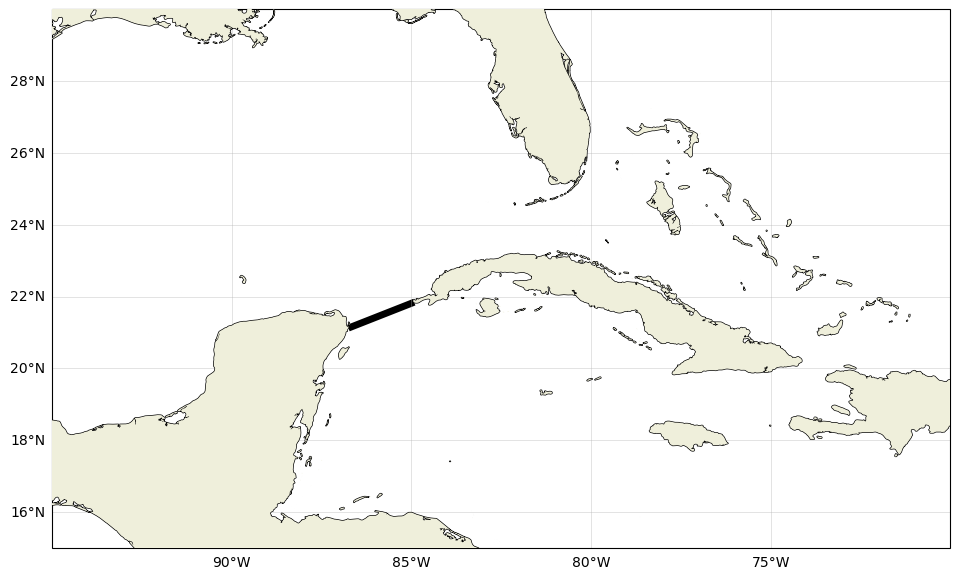

In [407]:

fig, ax = plt.subplots(figsize=(14,7),subplot_kw=dict(projection=cartopy.crs.PlateCarree()))
#im = ax.pcolormesh(MKE.x,MKE.y,MKE.isel(depth=depth_ind),transform =cartopy.crs.PlateCarree(),cmap=plt.cm.jet,vmin=0,vmax=0.08)

plt.plot([yucatan.x[-1], yucatan.x[0]], [yucatan.y[-1], yucatan.y[0]],'k', linewidth=5,transform=cartopy.crs.PlateCarree())

ax.coastlines(linewidth=1.0,zorder=10)
ax.add_feature(cartopy.feature.LAND,zorder=10)
glb = ax.gridlines(draw_labels=True, alpha=0.5, linewidth=.5 )
glb.xlabels_top = glb.ylabels_right = False
ax.set_ylim(15,30)
ax.set_xlim(-95,-70)

## Rotate velocities to be horizontal - along and cross bathy

In [349]:
cross_vel = yucatan.uvel.values*np.cos(np.deg2rad(20)) - yucatan.vvel.values*np.sin(np.deg2rad(20))
along_vel = yucatan.uvel.values*np.sin(np.deg2rad(20)) + yucatan.vvel.values*np.cos(np.deg2rad(20))
cross_vel = xr.DataArray(cross_vel, dims=['time','depth','point'], name='cross_vel')
along_vel = xr.DataArray(along_vel, dims=['time','depth','point'], name='along_vel')

yucatan['cross_vel'] = cross_vel
yucatan['along_vel'] = along_vel
yucatan

<xarray.Dataset>
Dimensions:                   (depth: 50, time: 373, point: 22)
Coordinates:
  * depth                     (depth) float32 0.494 1.541 ... 5.728e+03
  * time                      (time) datetime64[ns] 1993-01-01 ... 2023-12-01
    spatial_ref               int64 0
    x                         (point) float64 -86.66 -86.59 ... -85.09 -85.01
    y                         (point) float64 21.16 21.19 21.22 ... 21.78 21.81
Dimensions without coordinates: point
Data variables:
    so                        (time, depth, point) float32 dask.array<chunksize=(8, 33, 22), meta=np.ndarray>
    thetao                    (time, depth, point) float32 dask.array<chunksize=(8, 33, 22), meta=np.ndarray>
    uvel                      (time, depth, point) float32 dask.array<chunksize=(8, 33, 22), meta=np.ndarray>
    vvel                      (time, depth, point) float32 dask.array<chunksize=(8, 33, 22), meta=np.ndarray>
    absolute_salinity         (time, depth, point) float64 dask.array<chunksize=(8, 33, 22), meta=np.ndarray>
    conservative_temperature  (time, depth, point) float64 dask.array<chunksize=(8, 33, 22), meta=np.ndarray>
    potential_density         (time, depth, point) float64 dask.array<chunksize=(8, 33, 22), meta=np.ndarray>
    cross_vel                 (time, depth, point) float64 -0.1502 ... nan
    along_vel                 (time, depth, point) float64 0.5626 0.669 ... nan
Attributes: (12/14)
    Conventions:                   CF-1.6
    area:                          GLOBAL
    contact:                       servicedesk.cmems@mercator-ocean.eu
    credit:                        E.U. Copernicus Marine Service Information...
    dataset:                       global-reanalysis-001-030-monthly
    institution:                   Mercator Ocean
    ...                            ...
    product:                       GLOBAL_REANALYSIS_001_030
    product_user_manual:           http://marine.copernicus.eu/documents/PUM/...
    quality_information_document:  http://marine.copernicus.eu/documents/QUID...
    references:                    http://marine.copernicus.eu
    source:                        MERCATOR GLORYS12V1
    title:                         Monthly mean fields for product GLOBAL_REA...

In [350]:
yucatan_conservative_temperature_interp

<xarray.DataArray (time: 363, point: 22, grid_depth: 1000)>
dask.array<transpose, shape=(363, 22, 1000), dtype=float64, chunksize=(363, 22, 1000), chunktype=numpy.ndarray>
Coordinates:
    spatial_ref  int64 0
  * time         (time) datetime64[ns] 1993-01-01 1993-02-01 ... 2024-02-01
    x            (point) float64 -86.66 -86.59 -86.51 ... -85.17 -85.09 -85.01
    y            (point) float64 21.16 21.19 21.22 21.25 ... 21.75 21.78 21.81
Dimensions without coordinates: point, grid_depth

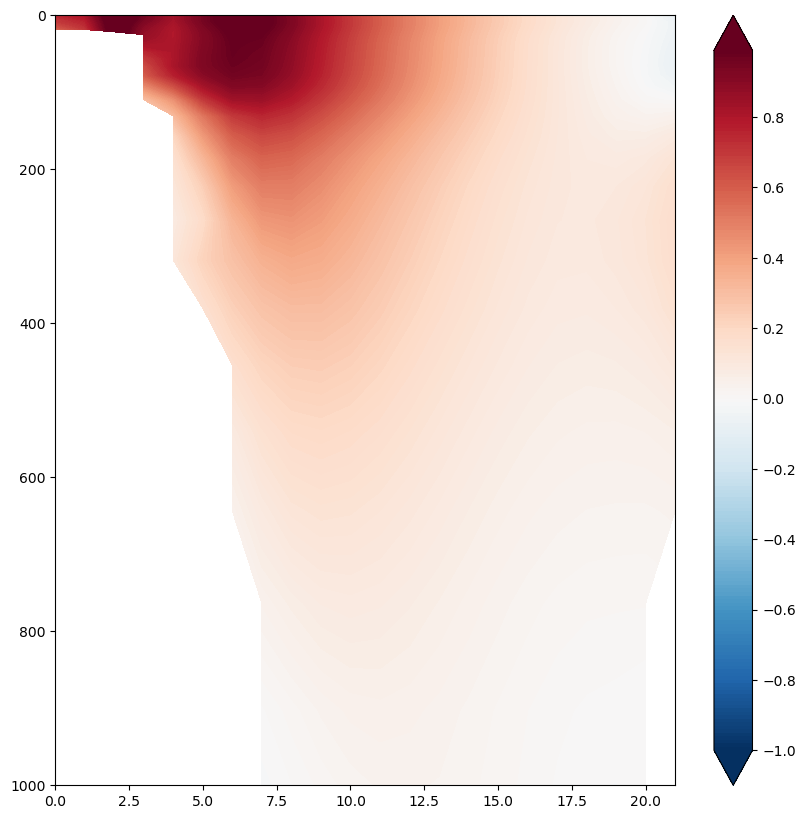

In [351]:
plt.figure(figsize=(10,10))
plt.contourf(yucatan.point,yucatan.depth,yucatan.along_vel.mean(dim='time'),levels=np.arange(-1,1,0.01),extend='both',cmap='RdBu_r')
plt.ylim(1000,0)
plt.colorbar()

## Interp onto regular depth grid to make the transport calculations smoother

In [368]:
dz = 1
grid_depth = np.arange(0.5, np.nanmax(yucatan.depth.values), dz)


#yucatan = yucatan.chunk({'time': -1})

yucatan = yucatan.chunk(dict(depth=-1))


# Define a function that applies np.gradient along the depth dimension
def interp_along_depth(depth, var, grid_depth):
    interp_func = interp1d(depth, var, kind='linear',fill_value=np.nan,bounds_error=False)
    return interp_func(grid_depth)


# Use xarray's apply_ufunc to interpolate along the depth dimension
yucatan_uvel_interp = xr.apply_ufunc(
    interp_along_depth,          # function to apply
    yucatan['depth'],            # depth array
    yucatan['uvel'],        # cross_vel array
    grid_depth,                  # additional argument: new depth levels
    input_core_dims=[['depth'], ['time', 'point', 'depth'], ['grid_depth']],  # specify input dimensions
    output_core_dims=[['time', 'point', 'grid_depth']],           # specify output dimension
    vectorize=True,              # vectorize the function
    dask='parallelized',         # enable parallel computation with dask
    output_dtypes=[yucatan.cross_vel.dtype]     # output dtype
)

# Use xarray's apply_ufunc to interpolate along the depth dimension
yucatan_vvel_interp = xr.apply_ufunc(
    interp_along_depth,          # function to apply
    yucatan['depth'],            # depth array
    yucatan['vvel'],        # cross_vel array
    grid_depth,                  # additional argument: new depth levels
    input_core_dims=[['depth'], ['time', 'point', 'depth'], ['grid_depth']],  # specify input dimensions
    output_core_dims=[['time', 'point', 'grid_depth']],           # specify output dimension
    vectorize=True,              # vectorize the function
    dask='parallelized',         # enable parallel computation with dask
    output_dtypes=[yucatan.cross_vel.dtype]     # output dtype
)


# Use xarray's apply_ufunc to interpolate along the depth dimension
yucatan_cross_vel_interp = xr.apply_ufunc(
    interp_along_depth,          # function to apply
    yucatan['depth'],            # depth array
    yucatan['cross_vel'],        # cross_vel array
    grid_depth,                  # additional argument: new depth levels
    input_core_dims=[['depth'], ['time', 'point', 'depth'], ['grid_depth']],  # specify input dimensions
    output_core_dims=[['time', 'point', 'grid_depth']],           # specify output dimension
    vectorize=True,              # vectorize the function
    dask='parallelized',         # enable parallel computation with dask
    output_dtypes=[yucatan.cross_vel.dtype]     # output dtype
)


# Use xarray's apply_ufunc to interpolate along the depth dimension
yucatan_along_vel_interp = xr.apply_ufunc(
    interp_along_depth,          # function to apply
    yucatan['depth'],            # depth array
    yucatan['along_vel'],        # cross_vel array
    grid_depth,                  # additional argument: new depth levels
    input_core_dims=[['depth'], ['time', 'point', 'depth'], ['grid_depth']],  # specify input dimensions
    output_core_dims=[['time', 'point', 'grid_depth']],           # specify output dimension
    vectorize=True,              # vectorize the function
    dask='parallelized',         # enable parallel computation with dask
    output_dtypes=[yucatan.cross_vel.dtype]     # output dtype
)


# Use xarray's apply_ufunc to interpolate along the depth dimension
yucatan_absolute_salinity_interp = xr.apply_ufunc(
    interp_along_depth,          # function to apply
    yucatan['depth'],            # depth array
    yucatan['absolute_salinity'],        # cross_vel array
    grid_depth,                  # additional argument: new depth levels
    input_core_dims=[['depth'], ['time', 'point', 'depth'], ['grid_depth']],  # specify input dimensions
    output_core_dims=[['time', 'point', 'grid_depth']],           # specify output dimension
    vectorize=True,              # vectorize the function
    dask='parallelized',         # enable parallel computation with dask
    output_dtypes=[yucatan.cross_vel.dtype]     # output dtype
)


# Use xarray's apply_ufunc to interpolate along the depth dimension
yucatan_conservative_temperature_interp = xr.apply_ufunc(
    interp_along_depth,          # function to apply
    yucatan['depth'],            # depth array
    yucatan['conservative_temperature'],        # cross_vel array
    grid_depth,                  # additional argument: new depth levels
    input_core_dims=[['depth'], ['time', 'point', 'depth'], ['grid_depth']],  # specify input dimensions
    output_core_dims=[['time', 'point', 'grid_depth']],           # specify output dimension
    vectorize=True,              # vectorize the function
    dask='parallelized',         # enable parallel computation with dask
    output_dtypes=[yucatan.cross_vel.dtype]     # output dtype
)


# Use xarray's apply_ufunc to interpolate along the depth dimension
yucatan_potential_density_interp = xr.apply_ufunc(
    interp_along_depth,          # function to apply
    yucatan['depth'],            # depth array
    yucatan['potential_density'],        # cross_vel array
    grid_depth,                  # additional argument: new depth levels
    input_core_dims=[['depth'], ['time', 'point', 'depth'], ['grid_depth']],  # specify input dimensions
    output_core_dims=[['time', 'point', 'grid_depth']],           # specify output dimension
    vectorize=True,              # vectorize the function
    dask='parallelized',         # enable parallel computation with dask
    output_dtypes=[yucatan.cross_vel.dtype]     # output dtype
)


In [369]:
# Create a new xarray Dataset with the interpolated data
yucatan_interp = xr.Dataset(
    {
        'conservative_temperature': (['time', 'point', 'depth'], yucatan_conservative_temperature_interp.values),
        'absolute_salinity': (['time', 'point', 'depth'], yucatan_absolute_salinity_interp.values),
        'potential_density': (['time', 'point', 'depth'], yucatan_potential_density_interp.values),
        'cross_vel': (['time', 'point', 'depth'], yucatan_cross_vel_interp.values),
        'along_vel': (['time', 'point', 'depth'], yucatan_along_vel_interp.values),
        'uvel': (['time', 'point', 'depth'], yucatan_uvel_interp.values),
        'vvel': (['time', 'point', 'depth'], yucatan_vvel_interp.values),        
    },
    coords={
        'time': yucatan.time.values,
        'point': yucatan.point.values,
        'depth': grid_depth  # Use grid_depth as the new depth dimension
    }
)


In [370]:
yucatan_interp

<xarray.Dataset>
Dimensions:                   (time: 373, point: 22, depth: 5728)
Coordinates:
  * time                      (time) datetime64[ns] 1993-01-01 ... 2023-12-01
  * point                     (point) int64 0 1 2 3 4 5 6 ... 16 17 18 19 20 21
  * depth                     (depth) float64 0.5 1.5 ... 5.726e+03 5.728e+03
Data variables:
    conservative_temperature  (time, point, depth) float64 26.29 26.28 ... nan
    absolute_salinity         (time, point, depth) float64 36.28 36.28 ... nan
    potential_density         (time, point, depth) float64 1.024e+03 ... nan
    cross_vel                 (time, point, depth) float64 -0.1502 ... nan
    along_vel                 (time, point, depth) float64 0.5626 0.5625 ... nan
    uvel                      (time, point, depth) float64 0.05128 ... nan
    vvel                      (time, point, depth) float64 0.58 0.5789 ... nan

## SAVE

In [371]:
yucatan_interp.to_netcdf('/Users/joegradone/SynologyDrive/Drive/Rutgers/Research/data/GLORYS/Sections/GLORYS_Yucatan_Straits_Interp.nc')

## RELOAD

In [372]:
yucatan_interp = xr.open_dataset('/Users/joegradone/SynologyDrive/Drive/Rutgers/Research/data/GLORYS/Sections/GLORYS_Yucatan_Straits_Interp.nc')
yucatan_interp

<xarray.Dataset>
Dimensions:                   (time: 373, point: 22, depth: 5728)
Coordinates:
  * time                      (time) datetime64[ns] 1993-01-01 ... 2023-12-01
  * point                     (point) int64 0 1 2 3 4 5 6 ... 16 17 18 19 20 21
  * depth                     (depth) float64 0.5 1.5 ... 5.726e+03 5.728e+03
Data variables:
    conservative_temperature  (time, point, depth) float64 ...
    absolute_salinity         (time, point, depth) float64 ...
    potential_density         (time, point, depth) float64 ...
    cross_vel                 (time, point, depth) float64 ...
    along_vel                 (time, point, depth) float64 ...
    uvel                      (time, point, depth) float64 ...
    vvel                      (time, point, depth) float64 ...

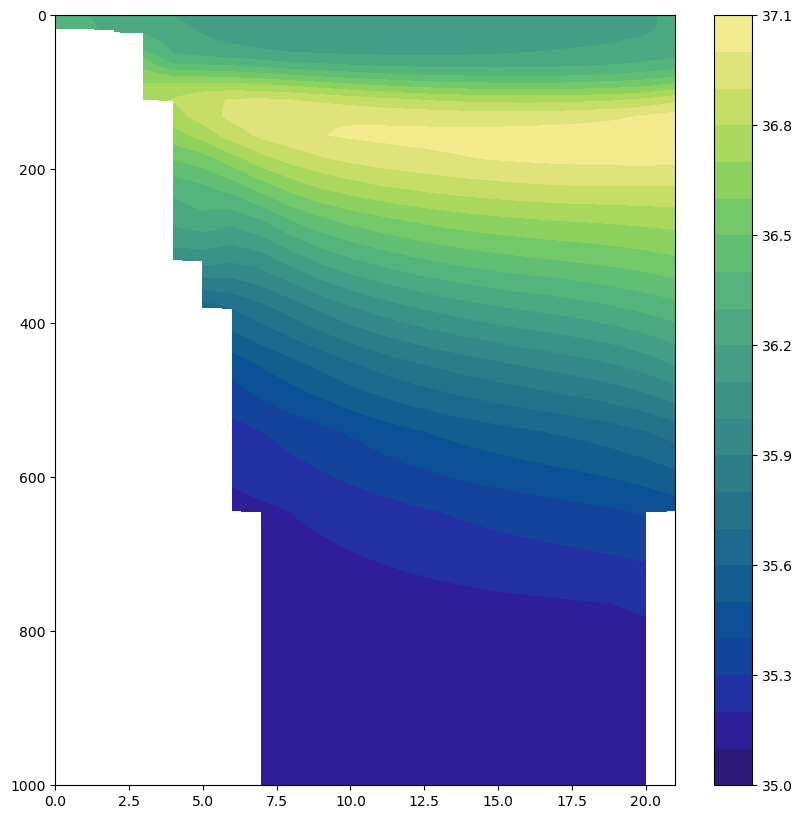

In [373]:
plt.figure(figsize=(10,10))
plt.contourf(yucatan_interp.point,yucatan_interp.depth,yucatan_interp.absolute_salinity.mean(dim='time').transpose(),levels=np.arange(35,37.1,0.1),cmap=cmo.haline)
plt.ylim(1000,0)
plt.colorbar()

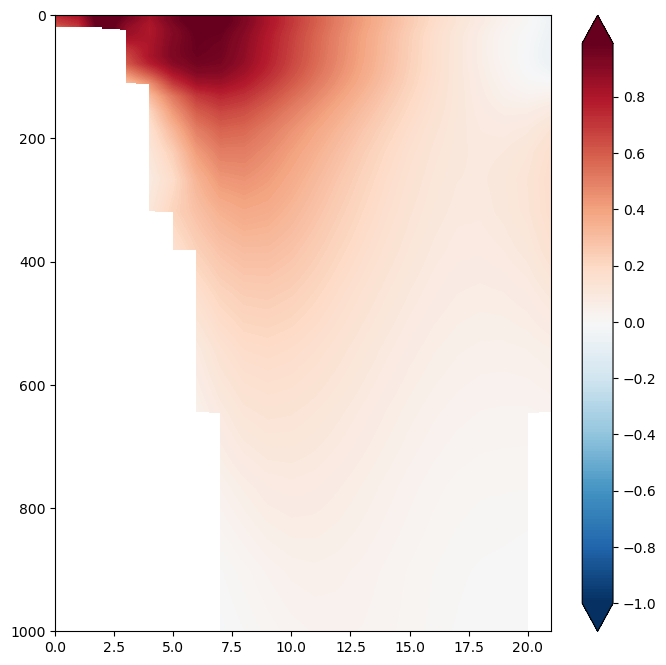

In [412]:
plt.figure(figsize=(8,8))
plt.contourf(yucatan_interp.point,yucatan_interp.depth,yucatan_interp.along_vel.mean(dim='time').transpose(),levels=np.arange(-1,1,0.01),extend='both',cmap='RdBu_r')
plt.ylim(1000,0)
plt.colorbar()

Text(0.5, 1.0, 'Yucatan Straits')

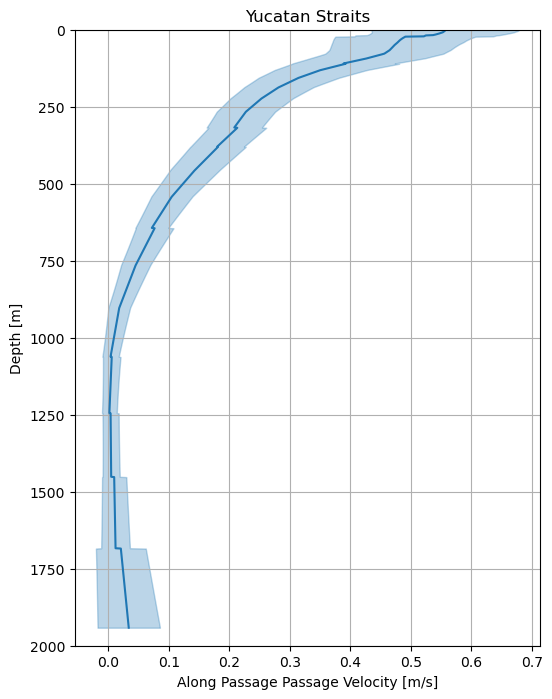

In [390]:
plt.figure(figsize=(6,8))
plt.plot(yucatan_interp.along_vel.mean(dim=['time','point']),yucatan_interp.depth,color='tab:blue')
plt.fill_betweenx(yucatan_interp.depth,yucatan_interp.along_vel.mean(dim=['time','point'])-yucatan_interp.along_vel.mean(dim='point').std(dim='time'),yucatan_interp.along_vel.mean(dim=['time','point'])+yucatan_interp.along_vel.mean(dim='point').std(dim='time'),color='tab:blue',alpha=0.3)
plt.ylim(2000,0)
plt.grid()
plt.ylabel('Depth [m]')
plt.xlabel('Along Passage Passage Velocity [m/s]')
plt.title('Yucatan Straits')

Text(0.5, 1.0, 'Yucatan Straits')

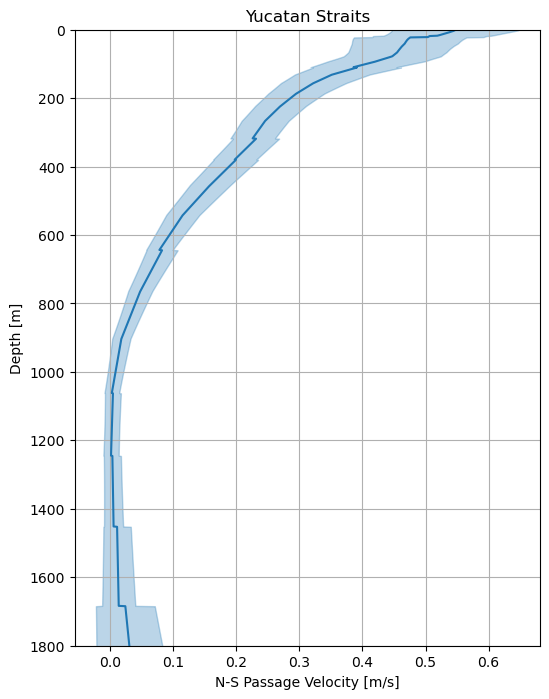

In [388]:
plt.figure(figsize=(6,8))
plt.plot(yucatan_interp.vvel.mean(dim=['time','point']),yucatan_interp.depth,color='tab:blue')
plt.fill_betweenx(yucatan_interp.depth,yucatan_interp.vvel.mean(dim=['time','point'])-yucatan_interp.vvel.mean(dim='point').std(dim='time'),yucatan_interp.vvel.mean(dim=['time','point'])+yucatan_interp.vvel.mean(dim='point').std(dim='time'),color='tab:blue',alpha=0.3)
plt.ylim(1800,0)
plt.grid()
plt.ylabel('Depth [m]')
plt.xlabel('N-S Passage Velocity [m/s]')
plt.title('Yucatan Straits')

In [411]:
yucatan_dx

9000

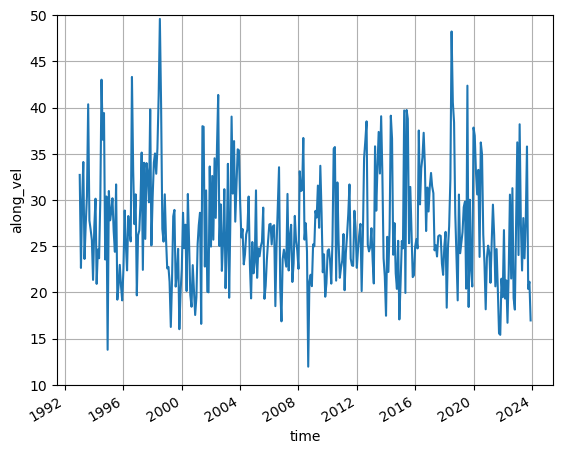

In [377]:
((yucatan_interp.along_vel*yucatan_dx).sum(dim=['point','depth'])/(10**6)).plot()
plt.ylim(10,50)
plt.grid()

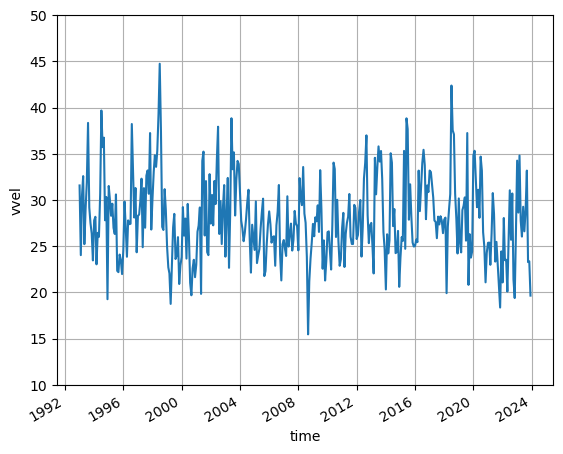

In [378]:
((yucatan_interp.vvel*yucatan_dx).sum(dim=['point','depth'])/(10**6)).plot()
plt.ylim(10,50)
plt.grid()

In [380]:
(yucatan_interp.vvel*yucatan_dx).sum(dim=['point','depth']).mean(dim='time')/(10**6)

<xarray.DataArray 'vvel' ()>
array(27.90291456)

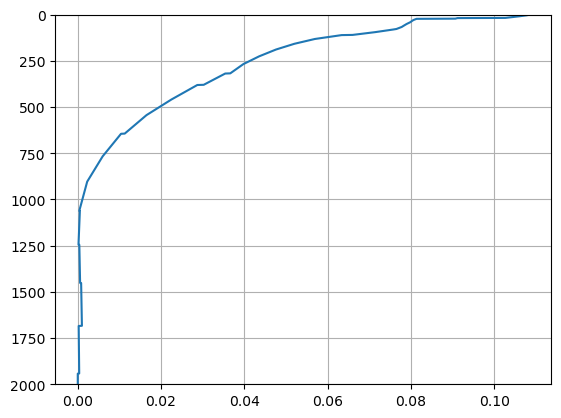

In [414]:
plt.plot((yucatan_interp.vvel*yucatan_dx).sum(dim=['point']).mean(dim='time')/(10**6),yucatan_interp.depth)
plt.ylim(2000,0)
plt.grid()

In [415]:
yucatan_transport_per_unit_depth = (yucatan_interp.vvel*yucatan_dx).sum(dim=['point']).mean(dim='time')/(10**6)
yucatan_transport_per_unit_depth

<xarray.DataArray 'vvel' (depth: 5728)>
array([0.1082782 , 0.10821656, 0.10801101, ..., 0.        , 0.        ,
       0.        ])
Coordinates:
  * depth    (depth) float64 0.5 1.5 2.5 3.5 ... 5.726e+03 5.726e+03 5.728e+03

In [416]:
yucatan_transport_per_unit_depth.to_netcdf('/Users/joegradone/SynologyDrive/Drive/Rutgers/Research/data/GLORYS/Sections/GLORYS_Yucatan_Straits_Interp_Transport_Profile.nc')


/Users/joegradone/anaconda3/envs/rutgers-phd/lib/python3.11/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/Users/joegradone/anaconda3/envs/rutgers-phd/lib/python3.11/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


(-90.0, -15.0)

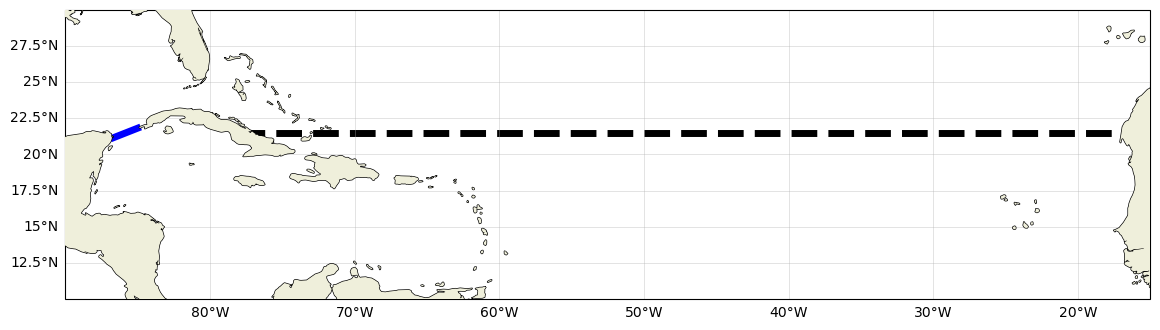

In [410]:

fig, ax = plt.subplots(figsize=(14,12),subplot_kw=dict(projection=cartopy.crs.PlateCarree()))

plt.plot([-78, -15], [21.5, 21.5],'k--', linewidth=5,transform=cartopy.crs.PlateCarree())

plt.plot([yucatan.x[-1], yucatan.x[0]], [yucatan.y[-1], yucatan.y[0]],'blue', linewidth=5,transform=cartopy.crs.PlateCarree())

ax.coastlines(linewidth=1.0,zorder=10)
ax.add_feature(cartopy.feature.LAND,zorder=10)
glb = ax.gridlines(draw_labels=True, alpha=0.5, linewidth=.5 )
glb.xlabels_top = glb.ylabels_right = False
ax.set_ylim(10,30)
ax.set_xlim(-90,-15)